# **Fine-Tuning ESM for PHF20 Protein Structure Prediction**


In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Installation of Necessary Libraries

In [ ]:
! pip install --upgrade transformers py3Dmol accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.2/11.2 MB 136.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 124.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 97.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 59.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 42.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 103.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink

In [ ]:
!pip install biopython

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 77.6 MB/s eta 0:00:00


In [ ]:
!pip install mdtraj numpy pandas ace-tools

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 108.4 MB/s eta 0:00:00


### Setting seed for reproducibility

In [ ]:
import random
import numpy as np
import torch

# Set a fixed random seed
seed = 42

# Python built-in random module
random.seed(seed)

# NumPy
np.random.seed(seed)

# PyTorch CPU
torch.manual_seed(seed)

# If CUDA is available:
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # for multi-GPU setups

# Configure cudnn for deterministic behavior
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False



### Clearing the CUDA Cache/Memory (!important to manage memory usage )

In [ ]:
import os, gc
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

import torch
gc.collect()
torch.cuda.empty_cache()

In [ ]:
from Bio.PDB import PDBParser, PPBuilder
from Bio.SeqRecord import SeqRecord
from Bio.Seq import Seq
from Bio import SeqIO

pdb_path = "/content/drive/MyDrive/Protein_str/phf20_100ns_clustered.pdb"
parser = PDBParser(QUIET=True)
structure = parser.get_structure("protein", pdb_path)

ppb = PPBuilder()
sequence = ""
for pp in ppb.build_peptides(structure):
    sequence += str(pp.get_sequence())

# Write to FASTA
fasta_path = "/content/drive/MyDrive/Protein_str/protein_sequence_100ns.fasta"
record = SeqRecord(Seq(sequence), id="ref100ns", description="Extracted from rphf20_100ns_clustered.pdb")
SeqIO.write(record, fasta_path, "fasta")


1

In [ ]:
from Bio import SeqIO
from Bio.PDB import PDBParser
import torch

# Load sequence
fasta_path = "/content/drive/MyDrive/Protein_str/protein_sequence_100ns.fasta"
record = next(SeqIO.parse(fasta_path, "fasta"))
sequence = str(record.seq)
print(f"FASTA sequence length: {len(sequence)}")

# Load CA atoms from PDB
pdb_path = "/content/drive/MyDrive/Protein_str/phf20_100ns_clustered.pdb"
parser = PDBParser(QUIET=True)
structure = parser.get_structure("protein", pdb_path)
ca_coords = [residue['CA'].get_coord() for model in structure for chain in model for residue in chain if 'CA' in residue]
print(f"CA atoms found in PDB: {len(ca_coords)}")

# check alignment
if len(sequence) == len(ca_coords):
    print("Sequence matches the number of CA atoms in the PDB.")
else:
    print("Mismatch: sequence and CA atoms are not equal.")


FASTA sequence length: 1012
CA atoms found in PDB: 1012
Sequence matches the number of CA atoms in the PDB.


### Protein structure loading

In [ ]:
import torch
import torch.nn as nn
import numpy as np
from Bio import SeqIO
from Bio.PDB import PDBParser
from transformers import AutoTokenizer, EsmModel

# Load sequence
fasta_path = "/content/drive/MyDrive/Protein_str/protein_sequence_100ns.fasta"
record = next(SeqIO.parse(fasta_path, "fasta"))
sequence = str(record.seq)
print(f"Loaded protein sequence with {len(sequence)} residues.")

# Load CA coordinates from reference PDB
pdb_path = "/content/drive/MyDrive/Protein_str/phf20_100ns_clustered.pdb"
parser = PDBParser(QUIET=True)
structure = parser.get_structure("protein", pdb_path)
ref_coords = torch.tensor(
    [residue['CA'].get_coord() for model in structure for chain in model for residue in chain if 'CA' in residue],
    dtype=torch.float32
).unsqueeze(0).cuda()  # shape: [1, N, 3]

print(f"Reference CA coordinates shape: {ref_coords.shape}")

Loaded protein sequence with 1012 residues.
Reference CA coordinates shape: torch.Size([1, 1012, 3])


/tmp/ipython-input-3188506443.py:18: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  ref_coords = torch.tensor(


### Load the Transformer (Lighter EsmFold2 Model)

In [ ]:
from transformers import AutoTokenizer, EsmModel

model_id = "facebook/esm2_t12_35M_UR50D"
tokenizer = AutoTokenizer.from_pretrained(model_id)

# Load ESM2 in eval mode to reduce memory during load
esm = EsmModel.from_pretrained(model_id).eval().cuda()
esm.train()  # Enable gradients for full fine-tuning

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/95.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/93.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/778 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/136M [00:00<?, ?B/s]

Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t12_35M_UR50D and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


EsmModel(
  (embeddings): EsmEmbeddings(
    (word_embeddings): Embedding(33, 480, padding_idx=1)
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (encoder): EsmEncoder(
    (layer): ModuleList(
      (0-11): 12 x EsmLayer(
        (attention): EsmAttention(
          (self): EsmSelfAttention(
            (query): Linear(in_features=480, out_features=480, bias=True)
            (key): Linear(in_features=480, out_features=480, bias=True)
            (value): Linear(in_features=480, out_features=480, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
            (rotary_embeddings): RotaryEmbedding()
          )
          (output): EsmSelfOutput(
            (dense): Linear(in_features=480, out_features=480, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
          (LayerNorm): LayerNorm((480,), eps=1e-05, elementwise_affine=True)
        )
        (intermediate): EsmIntermediate(
          (dense): Linear(in_features=480, out_features=1920, bia

### Tokenization of the Input Protein Structure  

In [ ]:
# Tokenize input sequence
inputs = tokenizer(sequence, return_tensors="pt", add_special_tokens=False)
inputs = {k: v.cuda() for k, v in inputs.items()}

# check and trim
with torch.no_grad():
    with torch.cuda.amp.autocast():
        temp_embed = esm(**inputs).last_hidden_state  # [1, N, d_model]

min_len = min(temp_embed.shape[1], ref_coords.shape[1])
ref_coords = ref_coords[:, :min_len, :]

/tmp/ipython-input-269021842.py:7: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


### Hyperparameter Tuning

Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t12_35M_UR50D and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



--- Running model with architecture [128], lr=0.01, wd=0.0, dropout=0.0 ---
Epoch 1/500 — Loss: 27.2869 — <2Å: 0.0% — <4Å: 0.4%
Epoch 51/500 — Loss: 15.8338 — <2Å: 0.1% — <4Å: 0.9%
Epoch 101/500 — Loss: 15.9816 — <2Å: 0.2% — <4Å: 0.6%
Epoch 151/500 — Loss: 9.2817 — <2Å: 0.6% — <4Å: 2.9%
Epoch 201/500 — Loss: 8.2645 — <2Å: 0.8% — <4Å: 4.1%
Epoch 251/500 — Loss: 7.7195 — <2Å: 1.1% — <4Å: 5.1%
Epoch 301/500 — Loss: 7.3000 — <2Å: 0.9% — <4Å: 7.1%
Epoch 351/500 — Loss: 6.8618 — <2Å: 0.9% — <4Å: 8.0%
Epoch 401/500 — Loss: 6.6373 — <2Å: 0.5% — <4Å: 7.9%
Epoch 451/500 — Loss: 6.4999 — <2Å: 1.6% — <4Å: 7.8%
Epoch 500/500 — Loss: 6.1075 — <2Å: 1.8% — <4Å: 10.0%


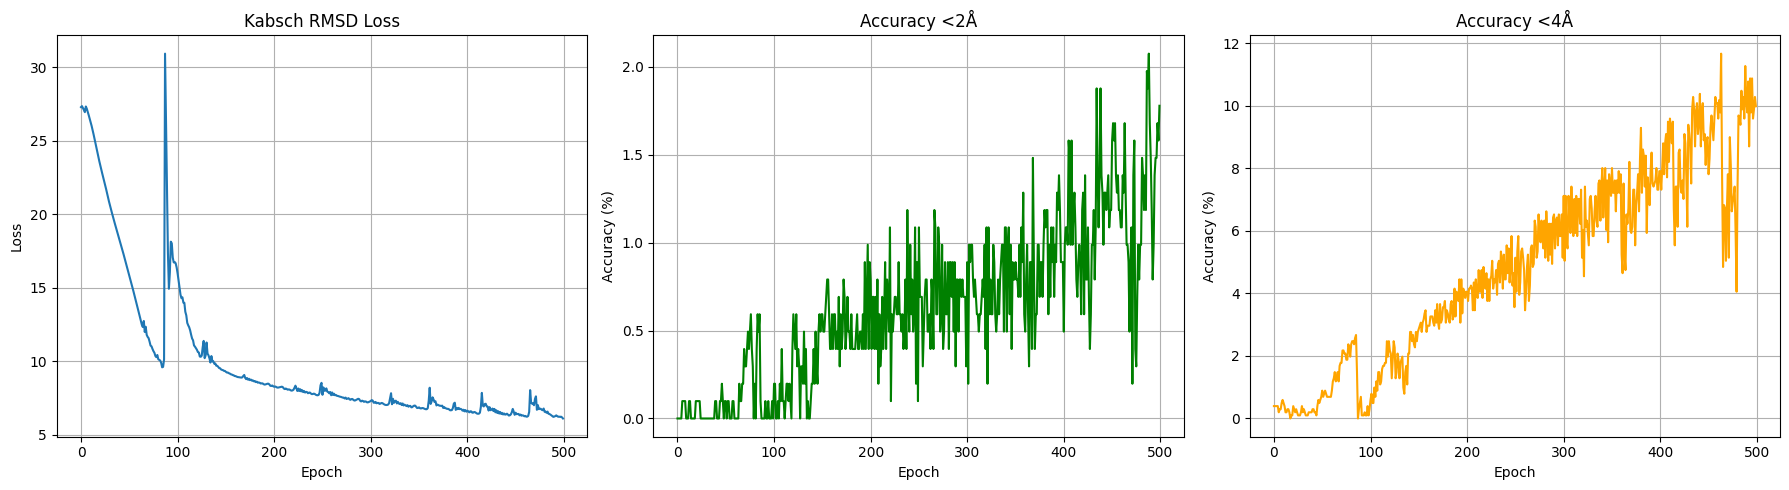

Saved plot to /content/drive/MyDrive/Protein_str/FineTuned_ESM2/plots/model_arch128_lr0.01_wd0.0_drop0.0.png

--- Running model with architecture [128], lr=0.01, wd=0.0, dropout=0.2 ---
Epoch 1/500 — Loss: 27.2874 — <2Å: 0.0% — <4Å: 0.4%
Epoch 51/500 — Loss: 24.1323 — <2Å: 0.0% — <4Å: 0.1%
Epoch 101/500 — Loss: 17.2896 — <2Å: 0.0% — <4Å: 0.8%
Epoch 151/500 — Loss: 13.3581 — <2Å: 0.1% — <4Å: 1.7%
Epoch 201/500 — Loss: 12.0919 — <2Å: 0.1% — <4Å: 1.4%
Epoch 251/500 — Loss: 11.1995 — <2Å: 0.6% — <4Å: 2.8%
Epoch 301/500 — Loss: 10.7552 — <2Å: 0.3% — <4Å: 1.8%
Epoch 351/500 — Loss: 11.2844 — <2Å: 0.2% — <4Å: 1.6%
Epoch 401/500 — Loss: 9.5360 — <2Å: 0.4% — <4Å: 3.5%
Epoch 451/500 — Loss: 11.8063 — <2Å: 0.1% — <4Å: 1.4%
Epoch 500/500 — Loss: 9.9102 — <2Å: 0.4% — <4Å: 3.5%


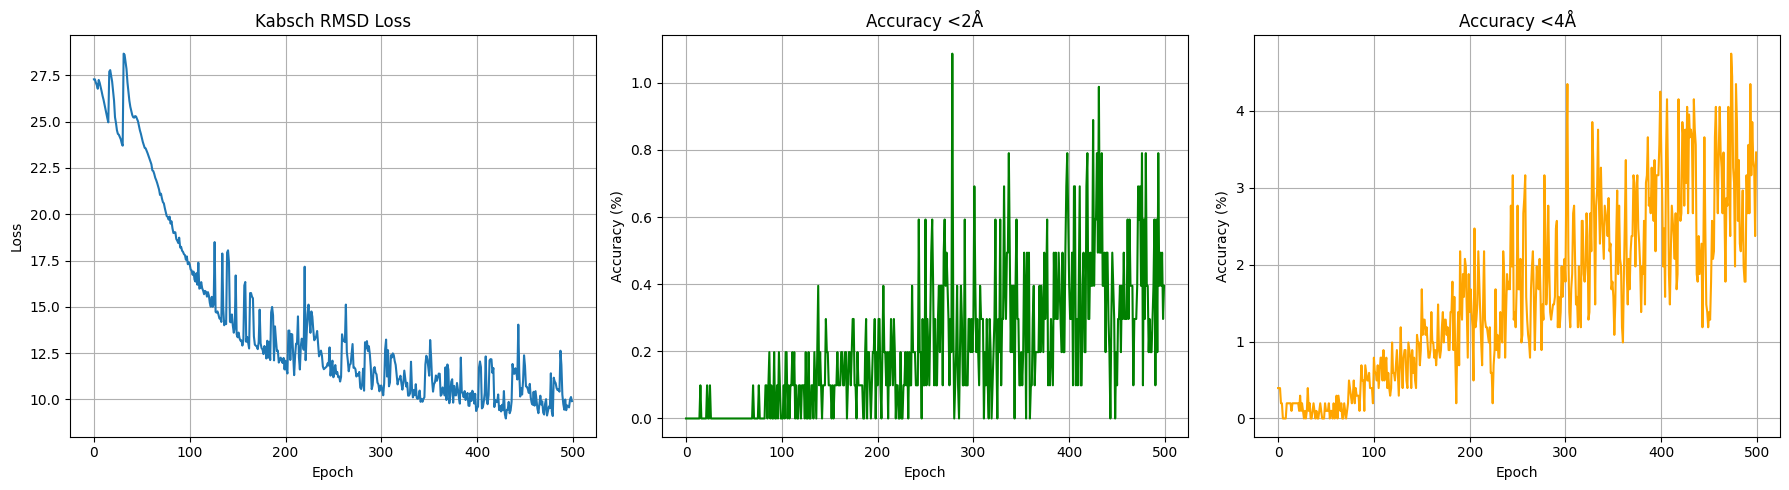

Saved plot to /content/drive/MyDrive/Protein_str/FineTuned_ESM2/plots/model_arch128_lr0.01_wd0.0_drop0.2.png

--- Running model with architecture [128], lr=0.01, wd=0.0001, dropout=0.0 ---
Epoch 1/500 — Loss: 27.2832 — <2Å: 0.0% — <4Å: 0.4%
Epoch 51/500 — Loss: 18.6279 — <2Å: 0.1% — <4Å: 0.2%
Epoch 101/500 — Loss: 12.8348 — <2Å: 0.2% — <4Å: 2.0%
Epoch 151/500 — Loss: 11.6083 — <2Å: 0.3% — <4Å: 1.4%
Epoch 201/500 — Loss: 8.4190 — <2Å: 1.0% — <4Å: 6.0%
Epoch 251/500 — Loss: 11.9958 — <2Å: 0.1% — <4Å: 1.5%
Epoch 301/500 — Loss: 7.5331 — <2Å: 1.7% — <4Å: 8.3%
Epoch 351/500 — Loss: 6.8127 — <2Å: 1.9% — <4Å: 11.9%
Epoch 401/500 — Loss: 6.5897 — <2Å: 1.7% — <4Å: 14.2%
Epoch 451/500 — Loss: 6.4854 — <2Å: 2.8% — <4Å: 13.4%
Epoch 500/500 — Loss: 7.3876 — <2Å: 0.5% — <4Å: 6.9%


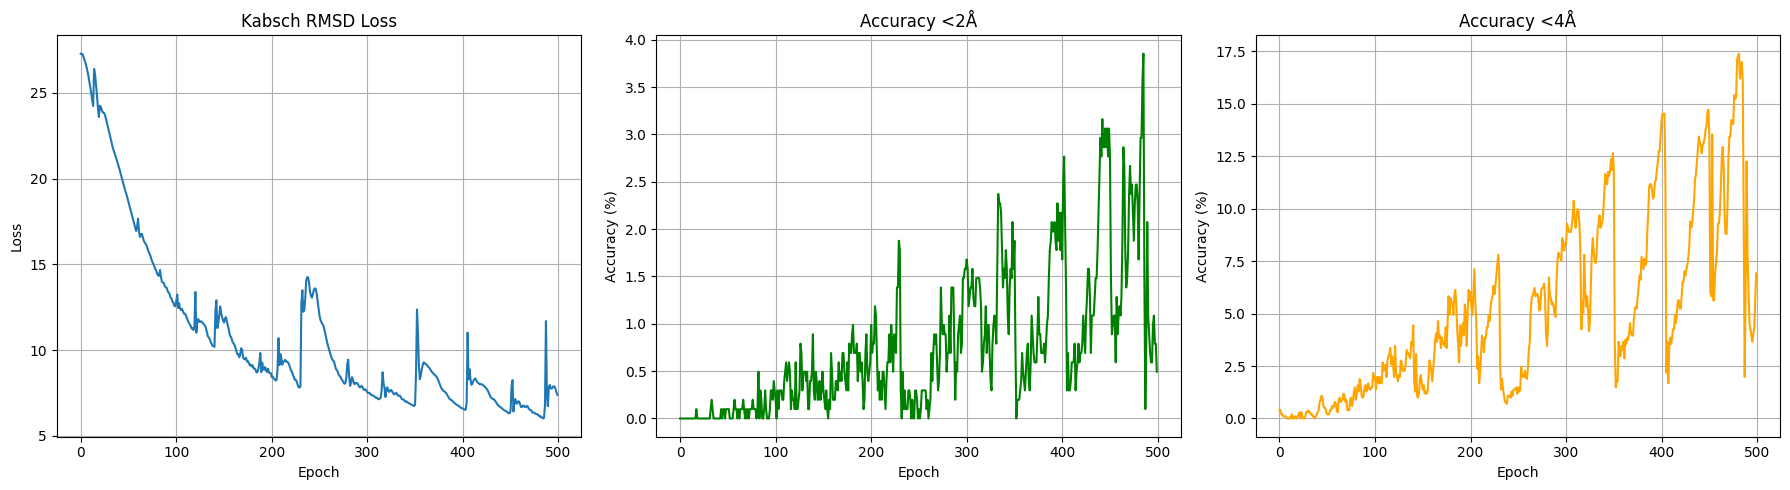

Saved plot to /content/drive/MyDrive/Protein_str/FineTuned_ESM2/plots/model_arch128_lr0.01_wd0.0001_drop0.0.png

--- Running model with architecture [128], lr=0.01, wd=0.0001, dropout=0.2 ---
Epoch 1/500 — Loss: 27.2869 — <2Å: 0.0% — <4Å: 0.4%
Epoch 51/500 — Loss: 21.6425 — <2Å: 0.1% — <4Å: 0.2%
Epoch 101/500 — Loss: 16.2165 — <2Å: 0.2% — <4Å: 0.7%
Epoch 151/500 — Loss: 11.9239 — <2Å: 0.3% — <4Å: 2.7%
Epoch 201/500 — Loss: 11.3680 — <2Å: 0.3% — <4Å: 2.5%
Epoch 251/500 — Loss: 10.1036 — <2Å: 0.2% — <4Å: 4.4%
Epoch 301/500 — Loss: 10.8248 — <2Å: 0.3% — <4Å: 3.0%
Epoch 351/500 — Loss: 9.5449 — <2Å: 0.2% — <4Å: 4.1%
Epoch 401/500 — Loss: 9.7261 — <2Å: 0.6% — <4Å: 3.6%
Epoch 451/500 — Loss: 9.1184 — <2Å: 1.0% — <4Å: 4.5%
Epoch 500/500 — Loss: 7.9753 — <2Å: 0.7% — <4Å: 7.4%


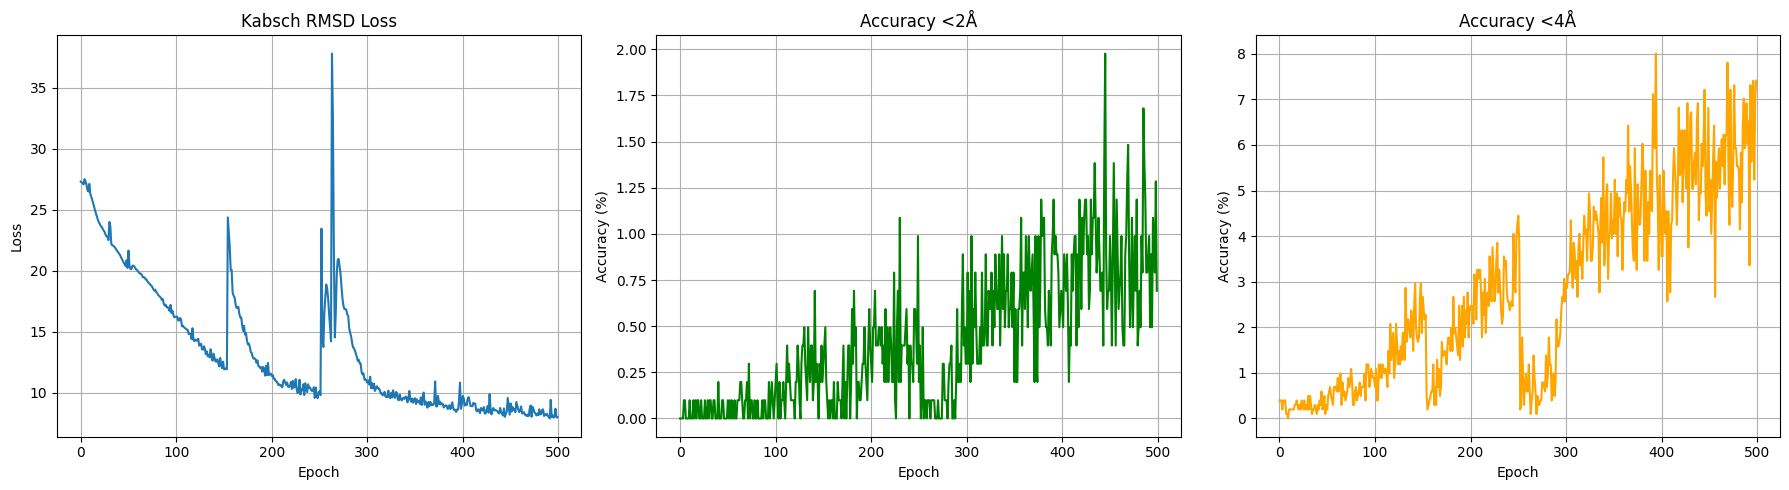

Saved plot to /content/drive/MyDrive/Protein_str/FineTuned_ESM2/plots/model_arch128_lr0.01_wd0.0001_drop0.2.png

--- Running model with architecture [128], lr=0.001, wd=0.0, dropout=0.0 ---
Epoch 1/500 — Loss: 27.2865 — <2Å: 0.0% — <4Å: 0.4%
Epoch 51/500 — Loss: 25.8105 — <2Å: 0.0% — <4Å: 0.1%
Epoch 101/500 — Loss: 24.5572 — <2Å: 0.0% — <4Å: 0.3%
Epoch 151/500 — Loss: 22.8223 — <2Å: 0.0% — <4Å: 0.1%
Epoch 201/500 — Loss: 21.7931 — <2Å: 0.1% — <4Å: 0.3%
Epoch 251/500 — Loss: 20.7837 — <2Å: 0.2% — <4Å: 0.5%
Epoch 301/500 — Loss: 19.6272 — <2Å: 0.1% — <4Å: 0.8%
Epoch 351/500 — Loss: 18.2015 — <2Å: 0.1% — <4Å: 1.0%
Epoch 401/500 — Loss: 16.9292 — <2Å: 0.3% — <4Å: 0.7%
Epoch 451/500 — Loss: 16.1511 — <2Å: 0.0% — <4Å: 1.3%
Epoch 500/500 — Loss: 15.7682 — <2Å: 0.1% — <4Å: 1.1%


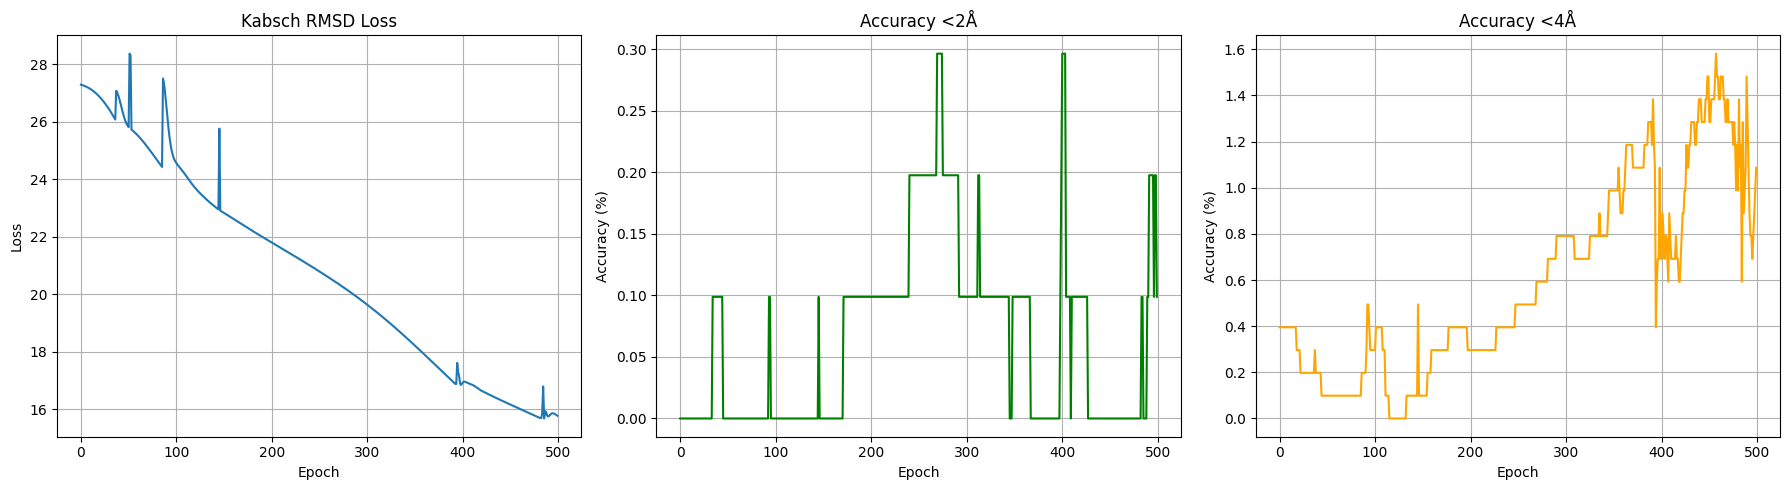

Saved plot to /content/drive/MyDrive/Protein_str/FineTuned_ESM2/plots/model_arch128_lr0.001_wd0.0_drop0.0.png

--- Running model with architecture [128], lr=0.001, wd=0.0, dropout=0.2 ---
Epoch 1/500 — Loss: 27.2836 — <2Å: 0.0% — <4Å: 0.4%
Epoch 51/500 — Loss: 26.0592 — <2Å: 0.0% — <4Å: 0.0%
Epoch 101/500 — Loss: 24.0100 — <2Å: 0.0% — <4Å: 0.0%
Epoch 151/500 — Loss: 24.0505 — <2Å: 0.0% — <4Å: 0.4%
Epoch 201/500 — Loss: 21.6184 — <2Å: 0.0% — <4Å: 0.5%
Epoch 251/500 — Loss: 21.3396 — <2Å: 0.1% — <4Å: 0.2%
Epoch 301/500 — Loss: 18.9908 — <2Å: 0.2% — <4Å: 0.5%
Epoch 351/500 — Loss: 17.6124 — <2Å: 0.1% — <4Å: 0.5%
Epoch 401/500 — Loss: 16.3978 — <2Å: 0.1% — <4Å: 0.7%
Epoch 451/500 — Loss: 15.2296 — <2Å: 0.2% — <4Å: 1.4%
Epoch 500/500 — Loss: 14.2057 — <2Å: 0.3% — <4Å: 1.0%


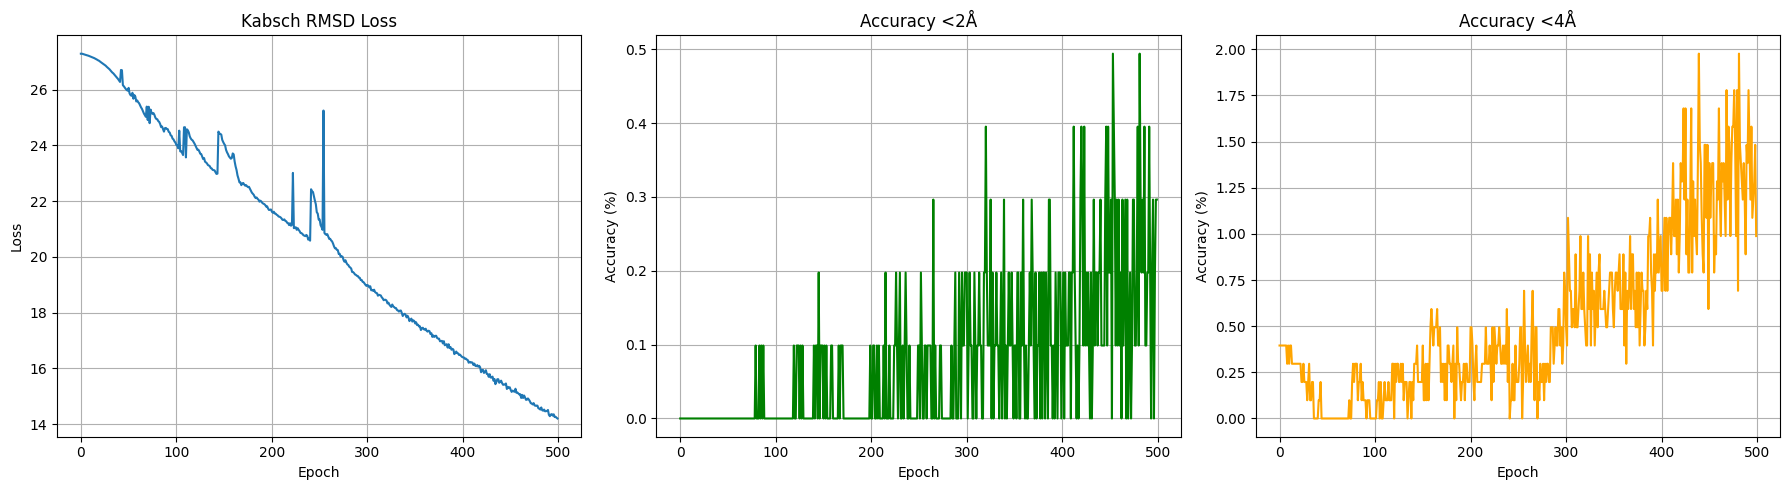

Saved plot to /content/drive/MyDrive/Protein_str/FineTuned_ESM2/plots/model_arch128_lr0.001_wd0.0_drop0.2.png

--- Running model with architecture [128], lr=0.001, wd=0.0001, dropout=0.0 ---
Epoch 1/500 — Loss: 27.2877 — <2Å: 0.0% — <4Å: 0.4%
Epoch 51/500 — Loss: 26.1045 — <2Å: 0.0% — <4Å: 0.1%
Epoch 101/500 — Loss: 23.3226 — <2Å: 0.0% — <4Å: 0.1%
Epoch 151/500 — Loss: 21.7263 — <2Å: 0.0% — <4Å: 0.0%
Epoch 201/500 — Loss: 19.8708 — <2Å: 0.1% — <4Å: 0.3%
Epoch 251/500 — Loss: 18.2436 — <2Å: 0.1% — <4Å: 0.3%
Epoch 301/500 — Loss: 16.7715 — <2Å: 0.0% — <4Å: 0.5%
Epoch 351/500 — Loss: 15.4102 — <2Å: 0.0% — <4Å: 0.7%
Epoch 401/500 — Loss: 14.0889 — <2Å: 0.4% — <4Å: 1.4%
Epoch 451/500 — Loss: 12.7691 — <2Å: 0.3% — <4Å: 1.6%
Epoch 500/500 — Loss: 11.4791 — <2Å: 0.0% — <4Å: 2.1%


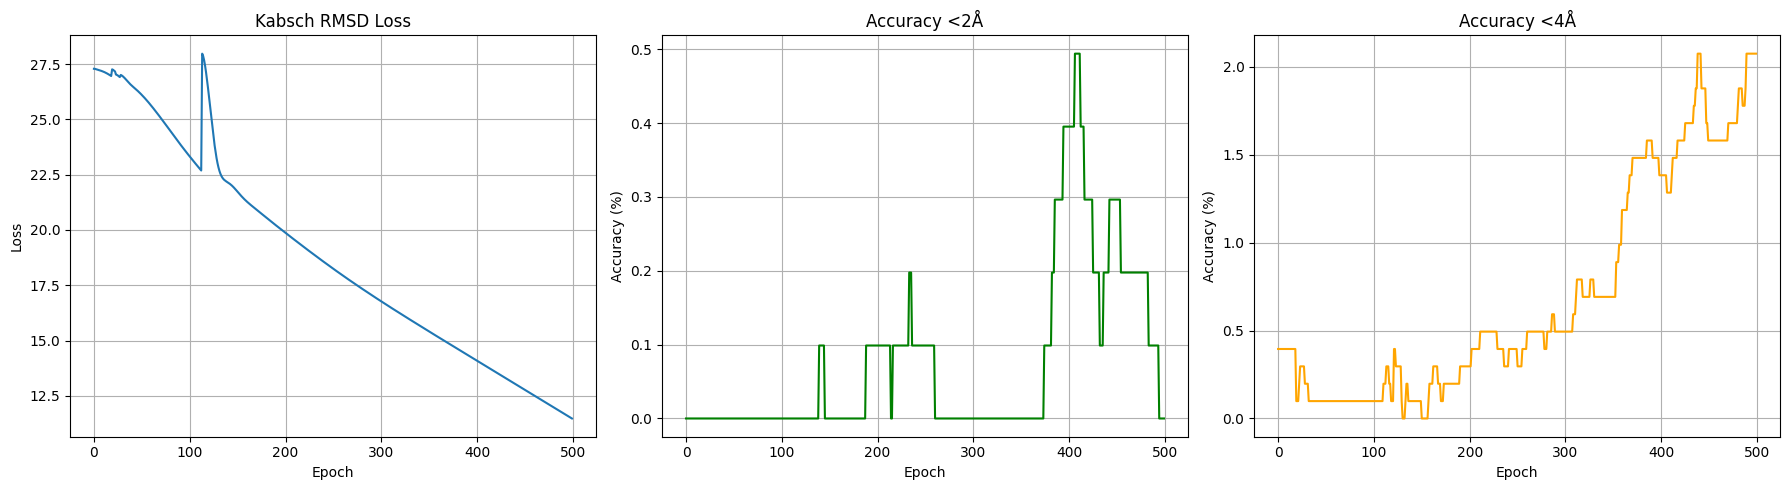

Saved plot to /content/drive/MyDrive/Protein_str/FineTuned_ESM2/plots/model_arch128_lr0.001_wd0.0001_drop0.0.png

--- Running model with architecture [128], lr=0.001, wd=0.0001, dropout=0.2 ---
Epoch 1/500 — Loss: 27.2819 — <2Å: 0.0% — <4Å: 0.4%
Epoch 51/500 — Loss: 26.0650 — <2Å: 0.0% — <4Å: 0.1%
Epoch 101/500 — Loss: 22.9965 — <2Å: 0.0% — <4Å: 0.0%
Epoch 151/500 — Loss: 20.8643 — <2Å: 0.0% — <4Å: 0.5%
Epoch 201/500 — Loss: 18.8909 — <2Å: 0.2% — <4Å: 0.7%
Epoch 251/500 — Loss: 17.0535 — <2Å: 0.0% — <4Å: 0.8%
Epoch 301/500 — Loss: 15.3318 — <2Å: 0.1% — <4Å: 0.7%
Epoch 351/500 — Loss: 24.7175 — <2Å: 0.0% — <4Å: 0.1%
Epoch 401/500 — Loss: 16.3730 — <2Å: 0.1% — <4Å: 0.1%
Epoch 451/500 — Loss: 15.6017 — <2Å: 0.1% — <4Å: 0.2%
Epoch 500/500 — Loss: 15.3346 — <2Å: 0.1% — <4Å: 0.2%


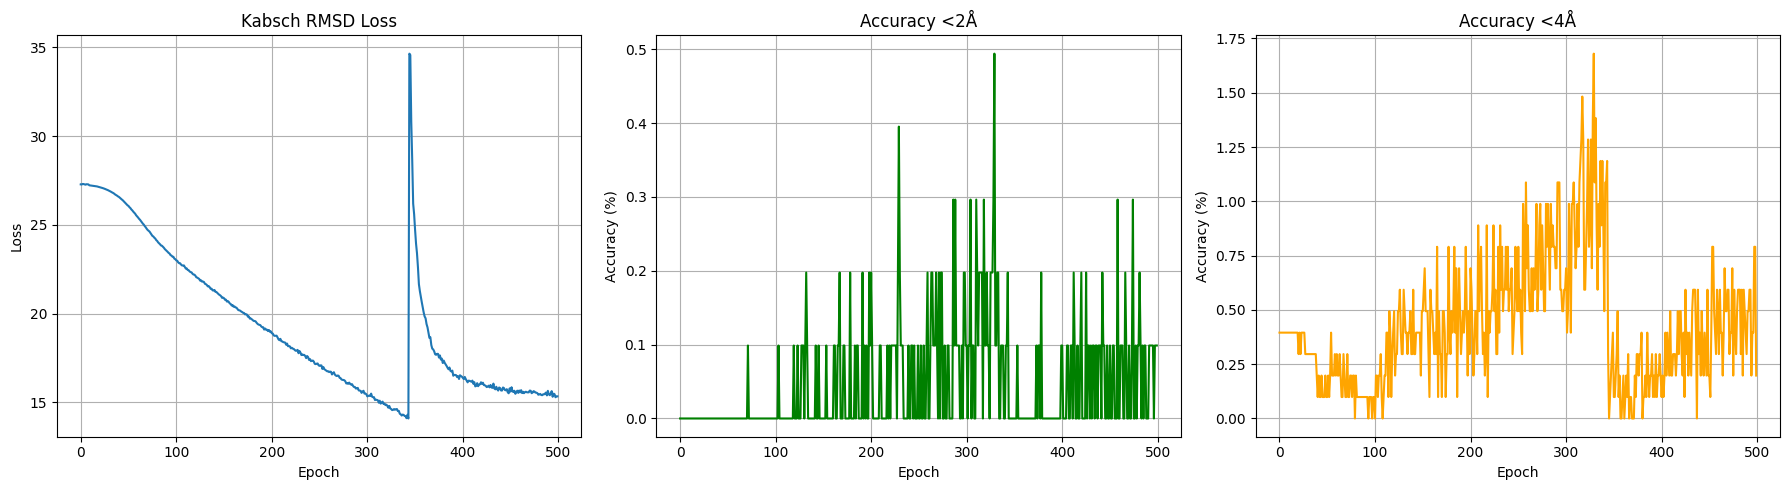

Saved plot to /content/drive/MyDrive/Protein_str/FineTuned_ESM2/plots/model_arch128_lr0.001_wd0.0001_drop0.2.png

--- Running model with architecture [128], lr=0.0001, wd=0.0, dropout=0.0 ---
Epoch 1/500 — Loss: 27.2801 — <2Å: 0.0% — <4Å: 0.4%
Epoch 51/500 — Loss: 27.2498 — <2Å: 0.0% — <4Å: 0.4%
Epoch 101/500 — Loss: 27.1418 — <2Å: 0.0% — <4Å: 0.4%
Epoch 151/500 — Loss: 27.0775 — <2Å: 0.0% — <4Å: 0.4%
Epoch 201/500 — Loss: 26.8610 — <2Å: 0.0% — <4Å: 0.4%
Epoch 251/500 — Loss: 26.6610 — <2Å: 0.0% — <4Å: 0.4%
Epoch 301/500 — Loss: 26.7484 — <2Å: 0.0% — <4Å: 0.3%
Epoch 351/500 — Loss: 26.1386 — <2Å: 0.0% — <4Å: 0.3%
Epoch 401/500 — Loss: 25.8444 — <2Å: 0.0% — <4Å: 0.2%
Epoch 451/500 — Loss: 25.5418 — <2Å: 0.0% — <4Å: 0.3%
Epoch 500/500 — Loss: 26.1361 — <2Å: 0.0% — <4Å: 0.2%


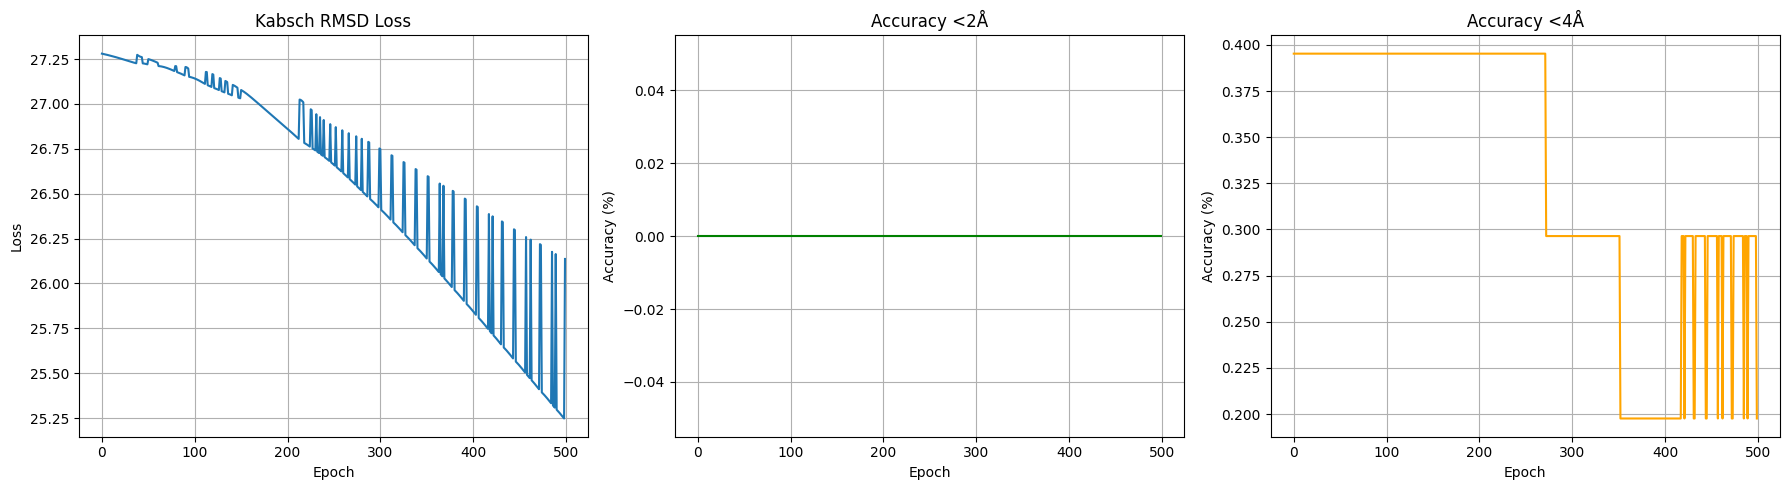

Saved plot to /content/drive/MyDrive/Protein_str/FineTuned_ESM2/plots/model_arch128_lr0.0001_wd0.0_drop0.0.png

--- Running model with architecture [128], lr=0.0001, wd=0.0, dropout=0.2 ---
Epoch 1/500 — Loss: 27.2864 — <2Å: 0.0% — <4Å: 0.4%
Epoch 51/500 — Loss: 27.2533 — <2Å: 0.0% — <4Å: 0.4%
Epoch 101/500 — Loss: 27.1892 — <2Å: 0.0% — <4Å: 0.4%
Epoch 151/500 — Loss: 27.0616 — <2Å: 0.0% — <4Å: 0.4%
Epoch 201/500 — Loss: 26.8697 — <2Å: 0.0% — <4Å: 0.4%
Epoch 251/500 — Loss: 26.6100 — <2Å: 0.0% — <4Å: 0.1%
Epoch 301/500 — Loss: 26.2981 — <2Å: 0.0% — <4Å: 0.1%
Epoch 351/500 — Loss: 25.9524 — <2Å: 0.0% — <4Å: 0.1%
Epoch 401/500 — Loss: 25.5680 — <2Å: 0.1% — <4Å: 0.1%
Epoch 451/500 — Loss: 25.1964 — <2Å: 0.0% — <4Å: 0.1%
Epoch 500/500 — Loss: 24.8038 — <2Å: 0.0% — <4Å: 0.1%


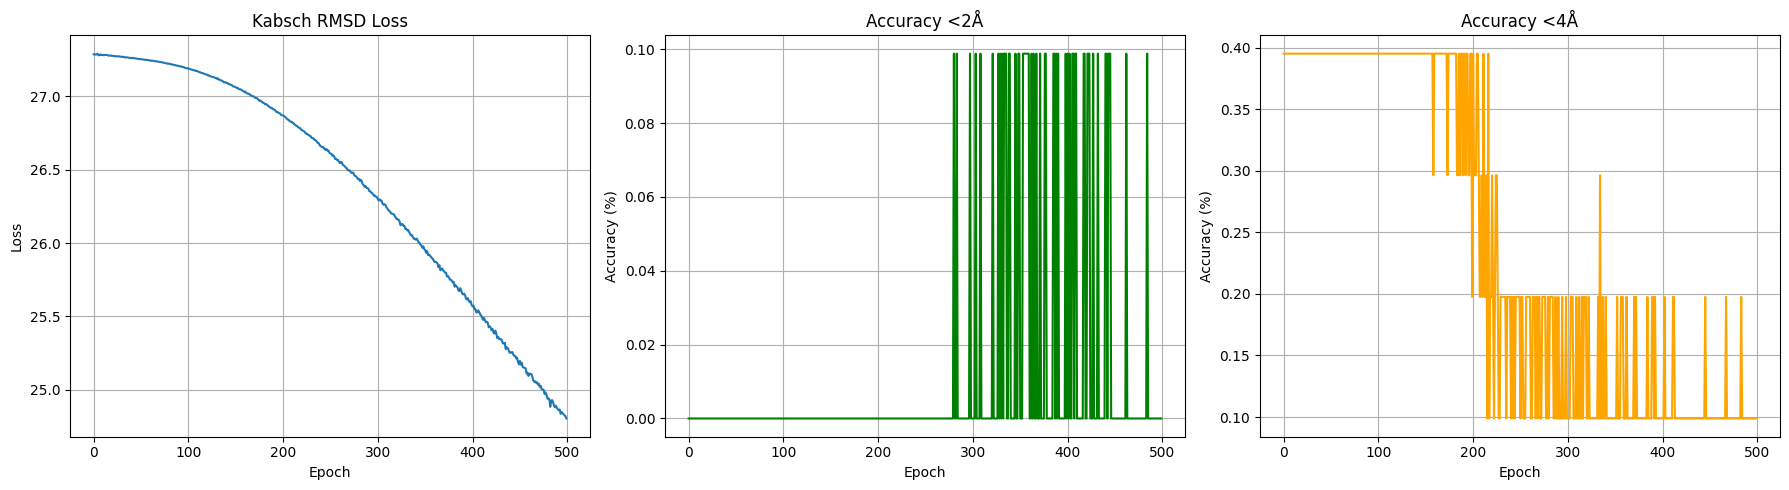

Saved plot to /content/drive/MyDrive/Protein_str/FineTuned_ESM2/plots/model_arch128_lr0.0001_wd0.0_drop0.2.png

--- Running model with architecture [128], lr=0.0001, wd=0.0001, dropout=0.0 ---
Epoch 1/500 — Loss: 27.2839 — <2Å: 0.0% — <4Å: 0.4%
Epoch 51/500 — Loss: 27.2356 — <2Å: 0.0% — <4Å: 0.4%
Epoch 101/500 — Loss: 27.1609 — <2Å: 0.0% — <4Å: 0.4%
Epoch 151/500 — Loss: 27.0552 — <2Å: 0.0% — <4Å: 0.4%
Epoch 201/500 — Loss: 26.9339 — <2Å: 0.0% — <4Å: 0.4%
Epoch 251/500 — Loss: 26.8250 — <2Å: 0.0% — <4Å: 0.4%
Epoch 301/500 — Loss: 26.7374 — <2Å: 0.0% — <4Å: 0.3%
Epoch 351/500 — Loss: 26.4984 — <2Å: 0.0% — <4Å: 0.2%
Epoch 401/500 — Loss: 26.2793 — <2Å: 0.0% — <4Å: 0.2%
Epoch 451/500 — Loss: 26.0716 — <2Å: 0.0% — <4Å: 0.2%
Epoch 500/500 — Loss: 25.8809 — <2Å: 0.0% — <4Å: 0.3%


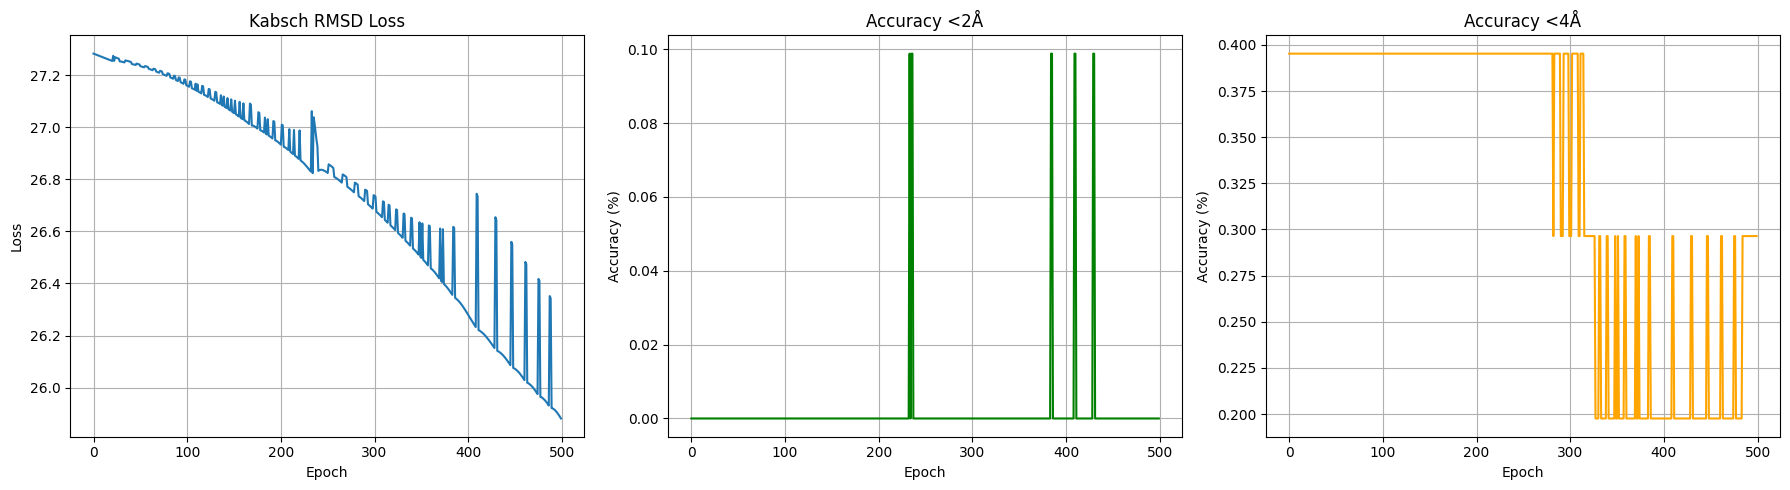

Saved plot to /content/drive/MyDrive/Protein_str/FineTuned_ESM2/plots/model_arch128_lr0.0001_wd0.0001_drop0.0.png

--- Running model with architecture [128], lr=0.0001, wd=0.0001, dropout=0.2 ---
Epoch 1/500 — Loss: 27.2905 — <2Å: 0.0% — <4Å: 0.4%
Epoch 51/500 — Loss: 27.2240 — <2Å: 0.0% — <4Å: 0.4%
Epoch 101/500 — Loss: 27.1305 — <2Å: 0.0% — <4Å: 0.4%
Epoch 151/500 — Loss: 26.9590 — <2Å: 0.0% — <4Å: 0.4%
Epoch 201/500 — Loss: 26.7272 — <2Å: 0.0% — <4Å: 0.2%
Epoch 251/500 — Loss: 26.4390 — <2Å: 0.1% — <4Å: 0.2%
Epoch 301/500 — Loss: 26.0982 — <2Å: 0.0% — <4Å: 0.2%
Epoch 351/500 — Loss: 25.7372 — <2Å: 0.0% — <4Å: 0.2%
Epoch 401/500 — Loss: 25.3584 — <2Å: 0.1% — <4Å: 0.1%
Epoch 451/500 — Loss: 24.9606 — <2Å: 0.0% — <4Å: 0.1%
Epoch 500/500 — Loss: 24.5915 — <2Å: 0.1% — <4Å: 0.1%


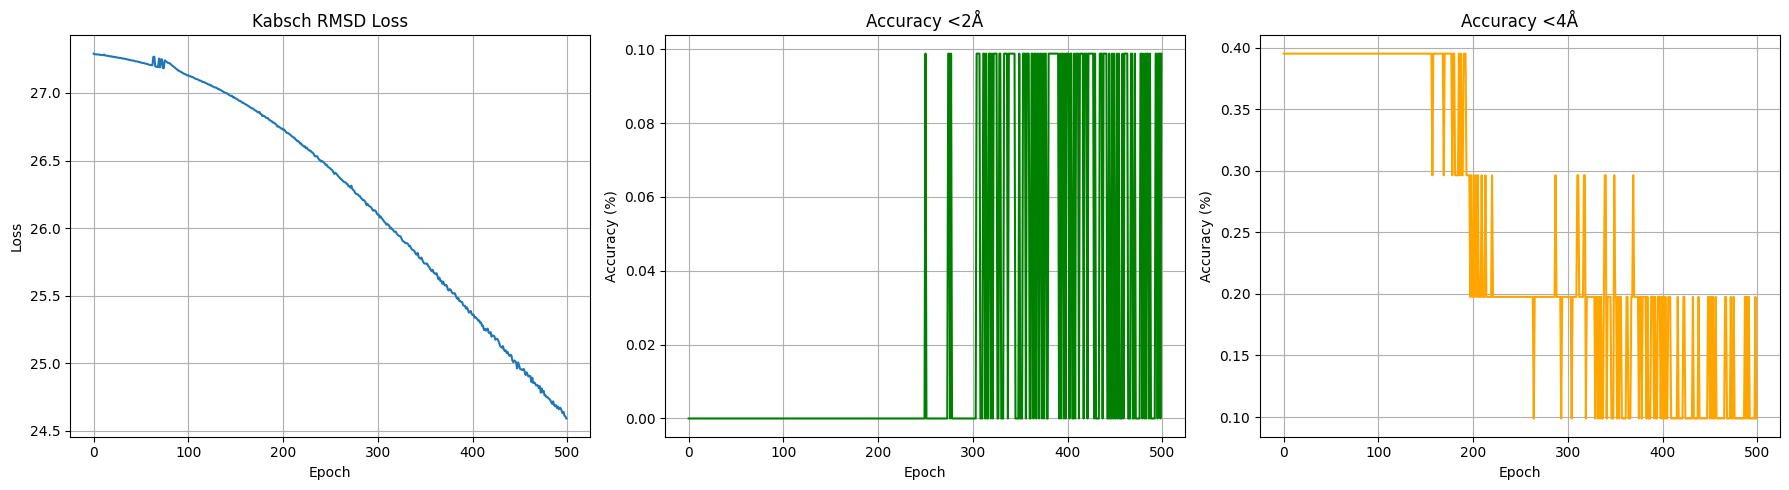

Saved plot to /content/drive/MyDrive/Protein_str/FineTuned_ESM2/plots/model_arch128_lr0.0001_wd0.0001_drop0.2.png

--- Running model with architecture [256, 128], lr=0.01, wd=0.0, dropout=0.0 ---
Epoch 1/500 — Loss: 27.2867 — <2Å: 0.0% — <4Å: 0.4%
Epoch 51/500 — Loss: 20.6695 — <2Å: 0.0% — <4Å: 0.2%
Epoch 101/500 — Loss: 10.3639 — <2Å: 0.2% — <4Å: 1.2%
Epoch 151/500 — Loss: 11.3588 — <2Å: 0.1% — <4Å: 1.4%
Epoch 201/500 — Loss: 7.3631 — <2Å: 0.8% — <4Å: 6.2%
Epoch 251/500 — Loss: 6.6681 — <2Å: 1.1% — <4Å: 6.4%
Epoch 301/500 — Loss: 9.6236 — <2Å: 0.2% — <4Å: 2.3%
Epoch 351/500 — Loss: 7.2737 — <2Å: 1.0% — <4Å: 6.8%
Epoch 401/500 — Loss: 7.6932 — <2Å: 0.7% — <4Å: 6.4%
Epoch 451/500 — Loss: 5.9977 — <2Å: 1.7% — <4Å: 7.9%
Epoch 500/500 — Loss: 5.5146 — <2Å: 2.9% — <4Å: 12.5%


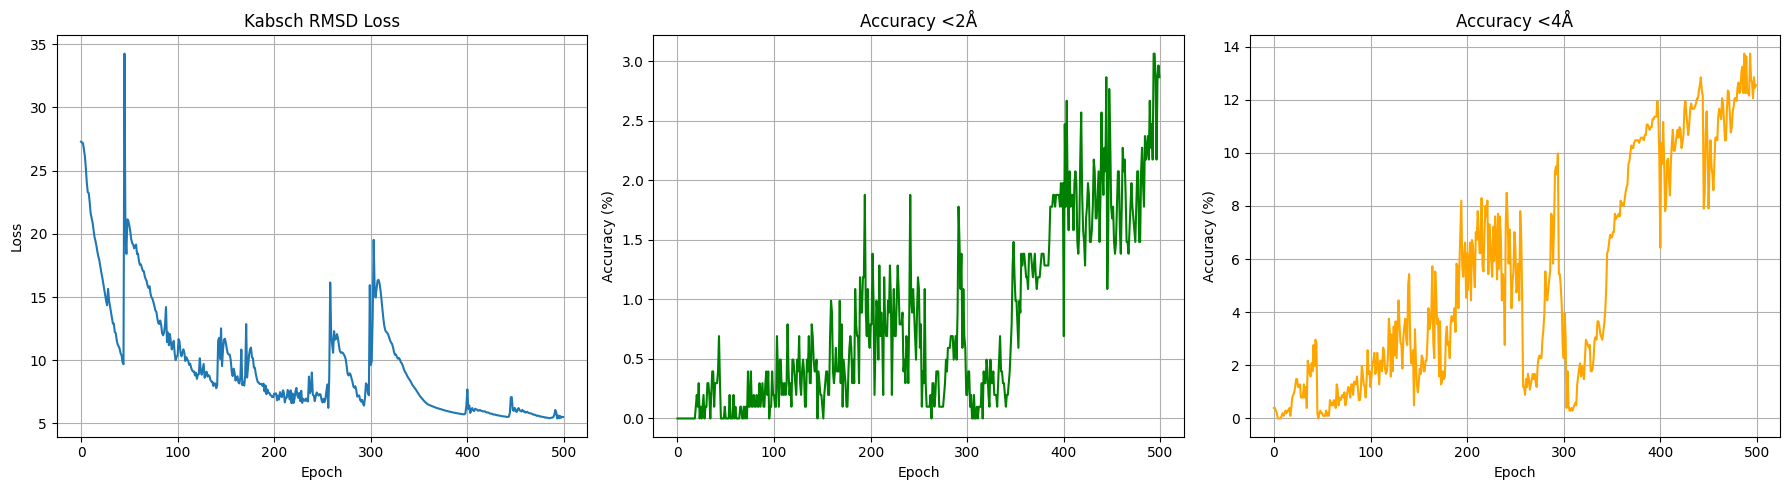

Saved plot to /content/drive/MyDrive/Protein_str/FineTuned_ESM2/plots/model_arch256_128_lr0.01_wd0.0_drop0.0.png

--- Running model with architecture [256, 128], lr=0.01, wd=0.0, dropout=0.2 ---
Epoch 1/500 — Loss: 27.2845 — <2Å: 0.0% — <4Å: 0.4%
Epoch 51/500 — Loss: 14.3793 — <2Å: 0.2% — <4Å: 0.7%
Epoch 101/500 — Loss: 21.0806 — <2Å: 0.0% — <4Å: 0.0%
Epoch 151/500 — Loss: 10.2964 — <2Å: 0.3% — <4Å: 2.9%
Epoch 201/500 — Loss: 11.8057 — <2Å: 0.1% — <4Å: 1.9%
Epoch 251/500 — Loss: 10.6907 — <2Å: 0.3% — <4Å: 1.7%
Epoch 301/500 — Loss: 8.5143 — <2Å: 0.2% — <4Å: 3.9%
Epoch 351/500 — Loss: 19.0026 — <2Å: 0.2% — <4Å: 0.5%
Epoch 401/500 — Loss: 7.9987 — <2Å: 0.6% — <4Å: 5.2%
Epoch 451/500 — Loss: 7.4912 — <2Å: 1.2% — <4Å: 6.0%
Epoch 500/500 — Loss: 7.4498 — <2Å: 1.1% — <4Å: 7.9%


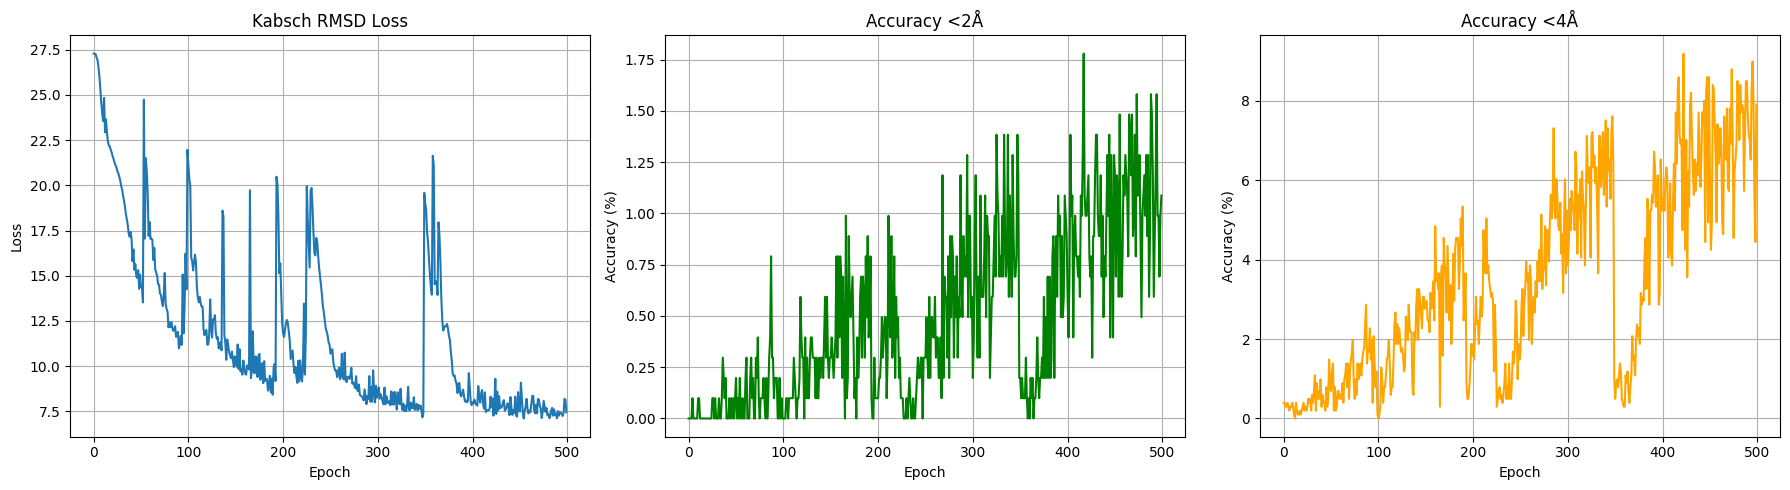

Saved plot to /content/drive/MyDrive/Protein_str/FineTuned_ESM2/plots/model_arch256_128_lr0.01_wd0.0_drop0.2.png

--- Running model with architecture [256, 128], lr=0.01, wd=0.0001, dropout=0.0 ---
Epoch 1/500 — Loss: 27.2864 — <2Å: 0.0% — <4Å: 0.4%
Epoch 51/500 — Loss: 16.2197 — <2Å: 0.2% — <4Å: 1.0%
Epoch 101/500 — Loss: 14.4971 — <2Å: 0.1% — <4Å: 0.2%
Epoch 151/500 — Loss: 15.6054 — <2Å: 0.2% — <4Å: 0.9%
Epoch 201/500 — Loss: 12.2163 — <2Å: 0.6% — <4Å: 3.1%
Epoch 251/500 — Loss: 6.1350 — <2Å: 2.2% — <4Å: 15.0%
Epoch 301/500 — Loss: 9.5085 — <2Å: 0.2% — <4Å: 2.8%
Epoch 351/500 — Loss: 4.6075 — <2Å: 7.6% — <4Å: 28.7%
Epoch 401/500 — Loss: 4.3277 — <2Å: 5.4% — <4Å: 27.0%
Epoch 451/500 — Loss: 5.8580 — <2Å: 1.3% — <4Å: 9.3%
Epoch 500/500 — Loss: 4.8402 — <2Å: 3.7% — <4Å: 18.4%


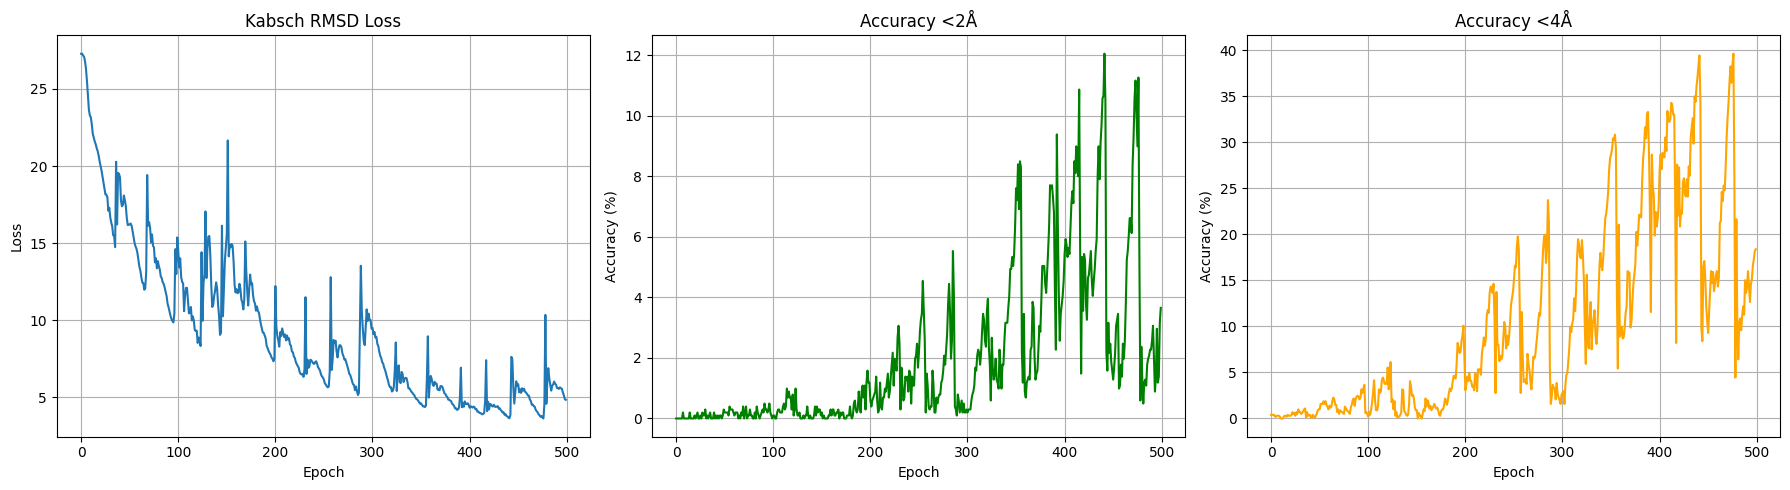

Saved plot to /content/drive/MyDrive/Protein_str/FineTuned_ESM2/plots/model_arch256_128_lr0.01_wd0.0001_drop0.0.png

--- Running model with architecture [256, 128], lr=0.01, wd=0.0001, dropout=0.2 ---
Epoch 1/500 — Loss: 27.2876 — <2Å: 0.0% — <4Å: 0.4%
Epoch 51/500 — Loss: 20.1904 — <2Å: 0.0% — <4Å: 0.2%
Epoch 101/500 — Loss: 30.5263 — <2Å: 0.0% — <4Å: 0.2%
Epoch 151/500 — Loss: 15.0209 — <2Å: 0.1% — <4Å: 0.9%
Epoch 201/500 — Loss: 11.8975 — <2Å: 0.4% — <4Å: 2.0%
Epoch 251/500 — Loss: 11.2881 — <2Å: 0.5% — <4Å: 2.6%
Epoch 301/500 — Loss: 10.8216 — <2Å: 0.2% — <4Å: 2.9%
Epoch 351/500 — Loss: 11.3955 — <2Å: 0.2% — <4Å: 2.9%
Epoch 401/500 — Loss: 8.7563 — <2Å: 0.9% — <4Å: 5.3%
Epoch 451/500 — Loss: 8.6927 — <2Å: 1.3% — <4Å: 5.1%
Epoch 500/500 — Loss: 8.4429 — <2Å: 1.0% — <4Å: 4.9%


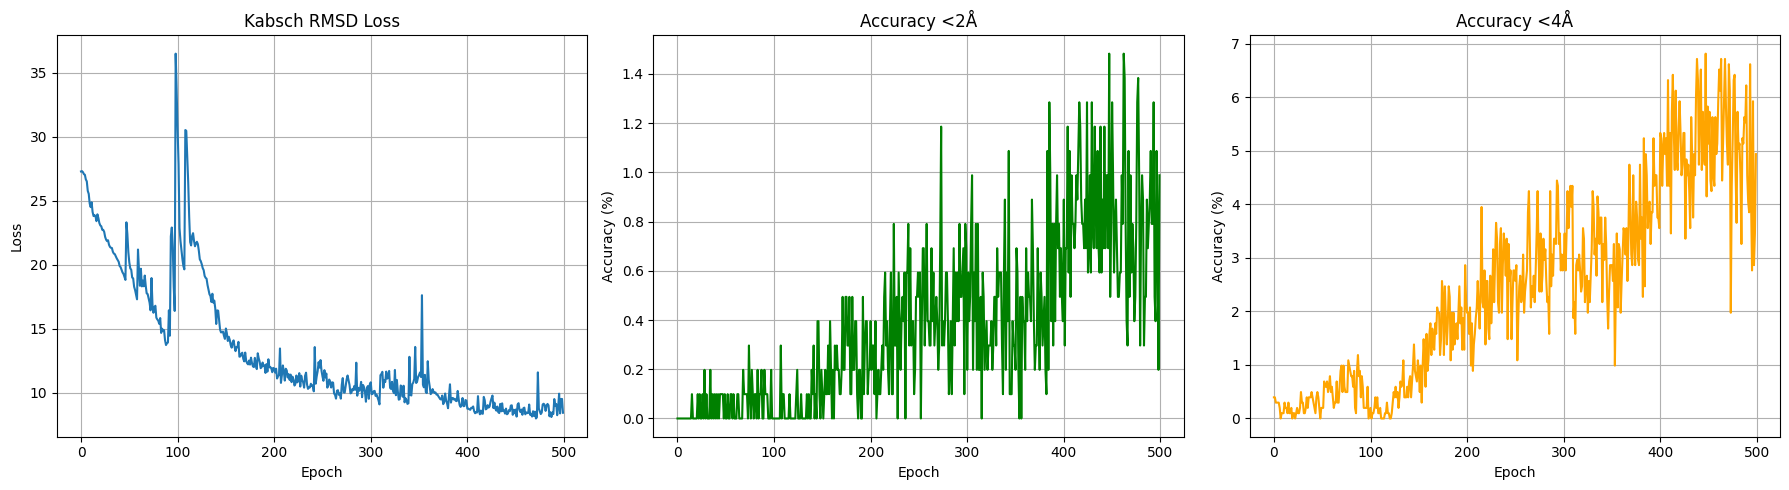

Saved plot to /content/drive/MyDrive/Protein_str/FineTuned_ESM2/plots/model_arch256_128_lr0.01_wd0.0001_drop0.2.png

--- Running model with architecture [256, 128], lr=0.001, wd=0.0, dropout=0.0 ---
Epoch 1/500 — Loss: 27.2869 — <2Å: 0.0% — <4Å: 0.4%
Epoch 51/500 — Loss: 23.1851 — <2Å: 0.0% — <4Å: 0.4%
Epoch 101/500 — Loss: 20.8319 — <2Å: 0.1% — <4Å: 0.2%
Epoch 151/500 — Loss: 16.6858 — <2Å: 0.1% — <4Å: 1.1%
Epoch 201/500 — Loss: 12.7061 — <2Å: 0.3% — <4Å: 1.2%
Epoch 251/500 — Loss: 12.0731 — <2Å: 0.1% — <4Å: 1.4%
Epoch 301/500 — Loss: 9.8452 — <2Å: 0.6% — <4Å: 2.8%
Epoch 351/500 — Loss: 8.4140 — <2Å: 0.8% — <4Å: 4.5%
Epoch 401/500 — Loss: 7.6555 — <2Å: 0.5% — <4Å: 5.5%
Epoch 451/500 — Loss: 6.6934 — <2Å: 1.6% — <4Å: 8.6%
Epoch 500/500 — Loss: 6.2204 — <2Å: 1.9% — <4Å: 10.7%


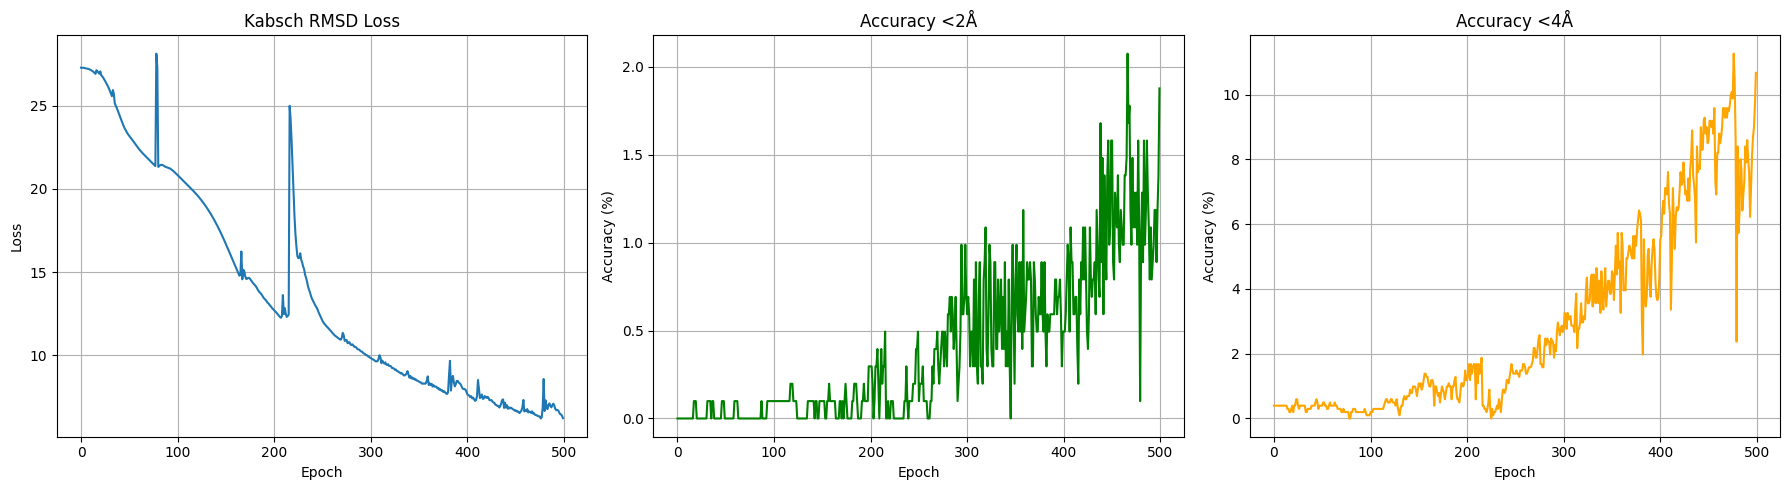

Saved plot to /content/drive/MyDrive/Protein_str/FineTuned_ESM2/plots/model_arch256_128_lr0.001_wd0.0_drop0.0.png

--- Running model with architecture [256, 128], lr=0.001, wd=0.0, dropout=0.2 ---
Epoch 1/500 — Loss: 27.2869 — <2Å: 0.0% — <4Å: 0.4%
Epoch 51/500 — Loss: 24.2029 — <2Å: 0.1% — <4Å: 0.3%
Epoch 101/500 — Loss: 17.3696 — <2Å: 0.1% — <4Å: 0.8%
Epoch 151/500 — Loss: 12.4675 — <2Å: 0.3% — <4Å: 1.0%
Epoch 201/500 — Loss: 10.8983 — <2Å: 0.6% — <4Å: 2.3%
Epoch 251/500 — Loss: 10.3042 — <2Å: 0.2% — <4Å: 2.1%
Epoch 301/500 — Loss: 9.9838 — <2Å: 0.3% — <4Å: 2.0%
Epoch 351/500 — Loss: 9.3762 — <2Å: 0.4% — <4Å: 2.1%
Epoch 401/500 — Loss: 8.7994 — <2Å: 0.2% — <4Å: 2.6%
Epoch 451/500 — Loss: 9.7929 — <2Å: 0.5% — <4Å: 3.3%
Epoch 500/500 — Loss: 8.6925 — <2Å: 0.6% — <4Å: 4.2%


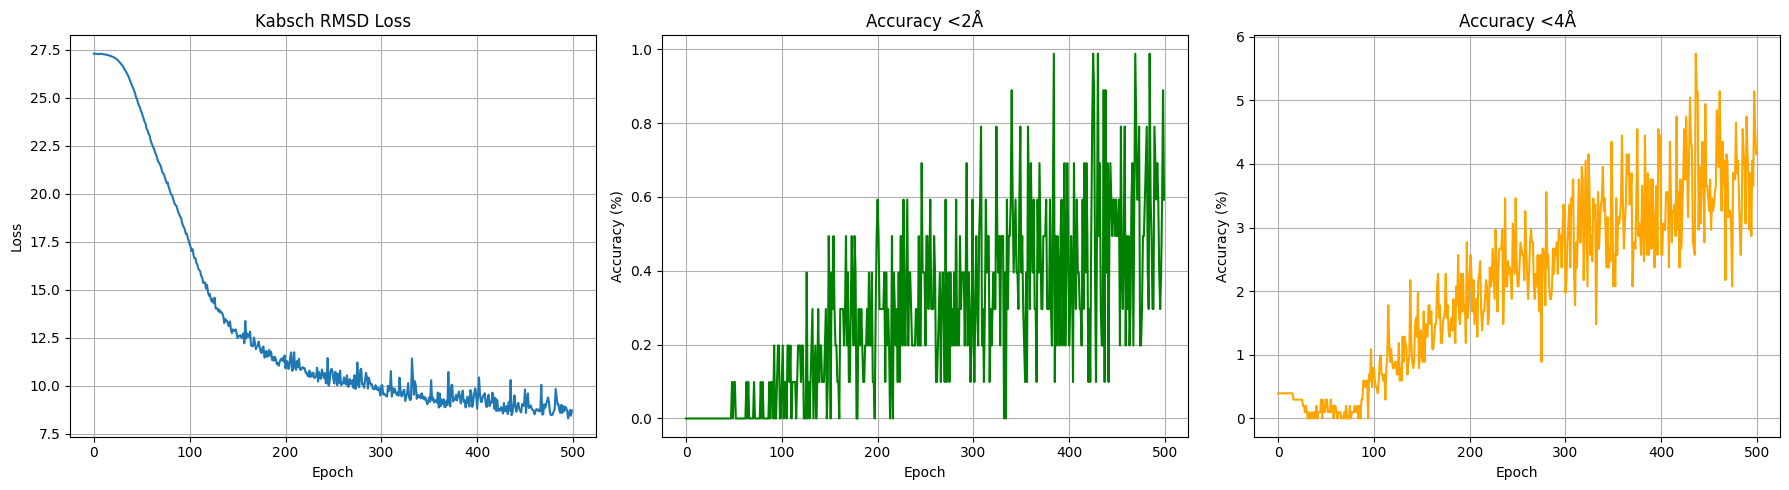

Saved plot to /content/drive/MyDrive/Protein_str/FineTuned_ESM2/plots/model_arch256_128_lr0.001_wd0.0_drop0.2.png

--- Running model with architecture [256, 128], lr=0.001, wd=0.0001, dropout=0.0 ---
Epoch 1/500 — Loss: 27.2862 — <2Å: 0.0% — <4Å: 0.4%
Epoch 51/500 — Loss: 23.1914 — <2Å: 0.1% — <4Å: 0.4%
Epoch 101/500 — Loss: 20.8871 — <2Å: 0.0% — <4Å: 0.2%
Epoch 151/500 — Loss: 18.7422 — <2Å: 0.0% — <4Å: 0.0%
Epoch 201/500 — Loss: 13.8496 — <2Å: 0.2% — <4Å: 1.4%
Epoch 251/500 — Loss: 14.1758 — <2Å: 0.2% — <4Å: 0.9%
Epoch 301/500 — Loss: 11.5743 — <2Å: 0.1% — <4Å: 1.4%
Epoch 351/500 — Loss: 10.6065 — <2Å: 0.1% — <4Å: 1.9%
Epoch 401/500 — Loss: 9.3995 — <2Å: 0.8% — <4Å: 3.9%
Epoch 451/500 — Loss: 9.1780 — <2Å: 0.1% — <4Å: 2.6%
Epoch 500/500 — Loss: 10.9051 — <2Å: 0.2% — <4Å: 0.7%


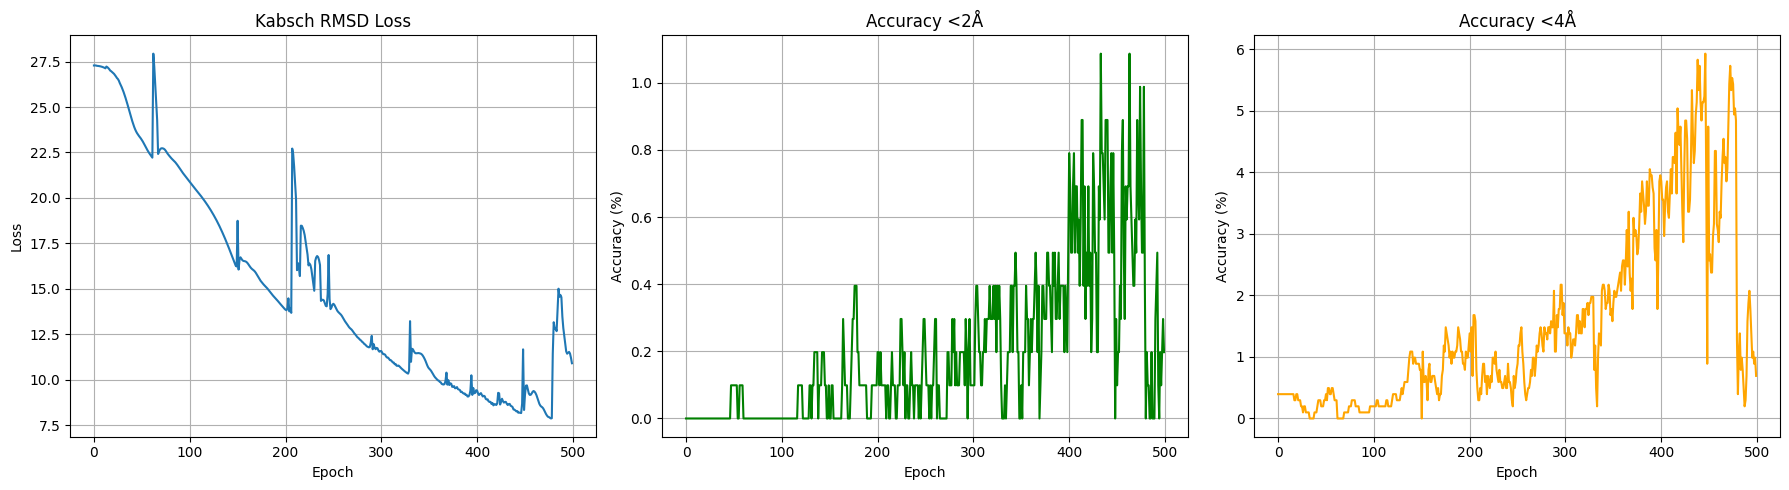

Saved plot to /content/drive/MyDrive/Protein_str/FineTuned_ESM2/plots/model_arch256_128_lr0.001_wd0.0001_drop0.0.png

--- Running model with architecture [256, 128], lr=0.001, wd=0.0001, dropout=0.2 ---
Epoch 1/500 — Loss: 27.2867 — <2Å: 0.0% — <4Å: 0.4%
Epoch 51/500 — Loss: 22.4012 — <2Å: 0.0% — <4Å: 0.2%
Epoch 101/500 — Loss: 17.1861 — <2Å: 0.1% — <4Å: 0.5%
Epoch 151/500 — Loss: 11.6217 — <2Å: 0.3% — <4Å: 1.5%
Epoch 201/500 — Loss: 8.9277 — <2Å: 0.3% — <4Å: 3.7%
Epoch 251/500 — Loss: 8.3214 — <2Å: 0.8% — <4Å: 5.8%
Epoch 301/500 — Loss: 7.2600 — <2Å: 1.4% — <4Å: 7.3%
Epoch 351/500 — Loss: 6.7084 — <2Å: 1.2% — <4Å: 9.4%
Epoch 401/500 — Loss: 6.2664 — <2Å: 2.0% — <4Å: 9.8%
Epoch 451/500 — Loss: 5.8816 — <2Å: 1.1% — <4Å: 11.5%
Epoch 500/500 — Loss: 5.8180 — <2Å: 2.0% — <4Å: 11.8%


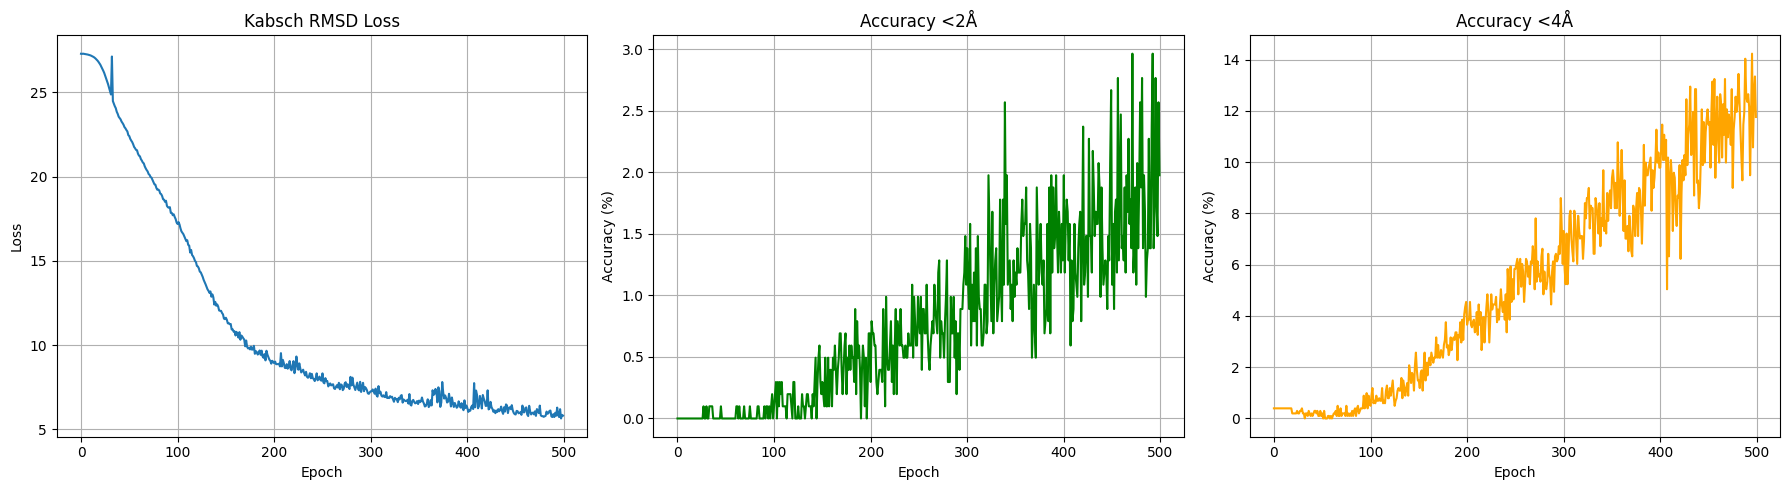

Saved plot to /content/drive/MyDrive/Protein_str/FineTuned_ESM2/plots/model_arch256_128_lr0.001_wd0.0001_drop0.2.png

--- Running model with architecture [256, 128], lr=0.0001, wd=0.0, dropout=0.0 ---
Epoch 1/500 — Loss: 27.2879 — <2Å: 0.0% — <4Å: 0.4%
Epoch 51/500 — Loss: 27.2472 — <2Å: 0.0% — <4Å: 0.4%
Epoch 101/500 — Loss: 26.9753 — <2Å: 0.0% — <4Å: 0.4%
Epoch 151/500 — Loss: 26.2398 — <2Å: 0.0% — <4Å: 0.1%
Epoch 201/500 — Loss: 26.7250 — <2Å: 0.1% — <4Å: 0.2%
Epoch 251/500 — Loss: 23.9994 — <2Å: 0.0% — <4Å: 0.2%
Epoch 301/500 — Loss: 23.4933 — <2Å: 0.0% — <4Å: 0.2%
Epoch 351/500 — Loss: 22.8214 — <2Å: 0.0% — <4Å: 0.2%
Epoch 401/500 — Loss: 22.3919 — <2Å: 0.0% — <4Å: 0.2%
Epoch 451/500 — Loss: 21.9573 — <2Å: 0.0% — <4Å: 0.2%
Epoch 500/500 — Loss: 21.5321 — <2Å: 0.0% — <4Å: 0.0%


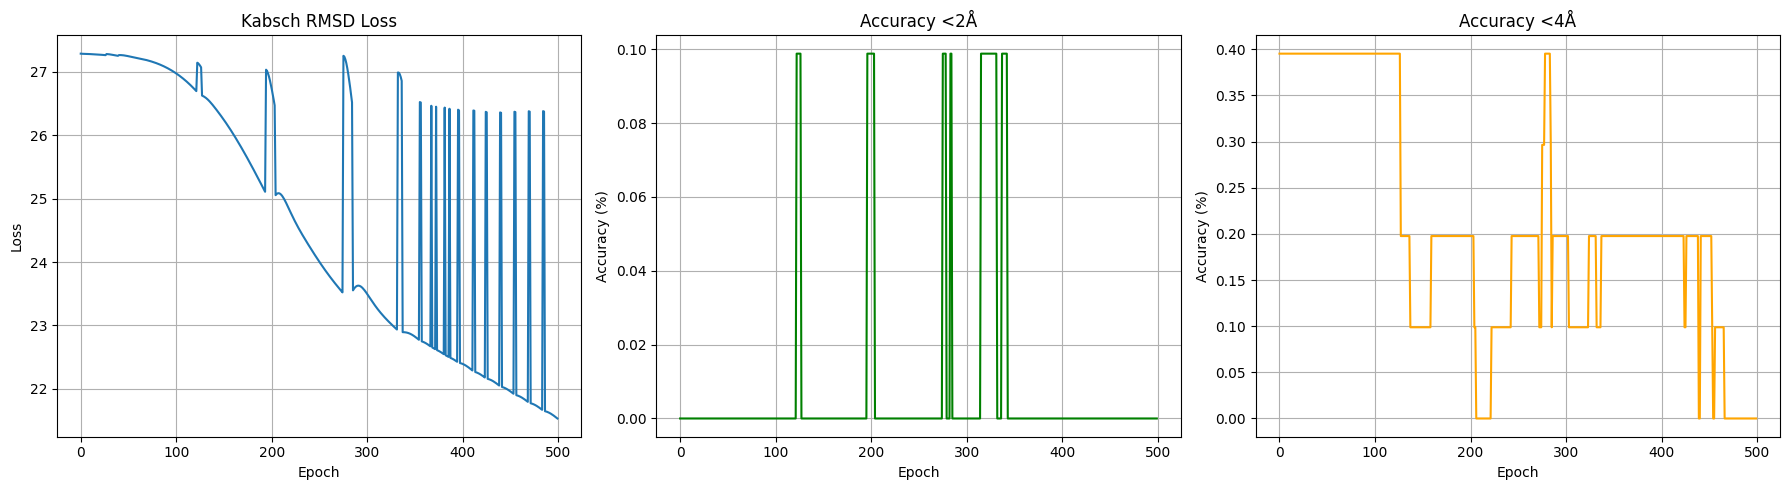

Saved plot to /content/drive/MyDrive/Protein_str/FineTuned_ESM2/plots/model_arch256_128_lr0.0001_wd0.0_drop0.0.png

--- Running model with architecture [256, 128], lr=0.0001, wd=0.0, dropout=0.2 ---
Epoch 1/500 — Loss: 27.2875 — <2Å: 0.0% — <4Å: 0.4%
Epoch 51/500 — Loss: 27.2517 — <2Å: 0.0% — <4Å: 0.4%
Epoch 101/500 — Loss: 27.0196 — <2Å: 0.0% — <4Å: 0.4%
Epoch 151/500 — Loss: 26.0949 — <2Å: 0.0% — <4Å: 0.3%
Epoch 201/500 — Loss: 24.5570 — <2Å: 0.1% — <4Å: 0.3%
Epoch 251/500 — Loss: 23.3910 — <2Å: 0.0% — <4Å: 0.3%
Epoch 301/500 — Loss: 22.7326 — <2Å: 0.0% — <4Å: 0.2%
Epoch 351/500 — Loss: 22.1565 — <2Å: 0.1% — <4Å: 0.3%
Epoch 401/500 — Loss: 21.6391 — <2Å: 0.0% — <4Å: 0.4%
Epoch 451/500 — Loss: 21.1507 — <2Å: 0.1% — <4Å: 0.4%
Epoch 500/500 — Loss: 20.6169 — <2Å: 0.0% — <4Å: 0.3%


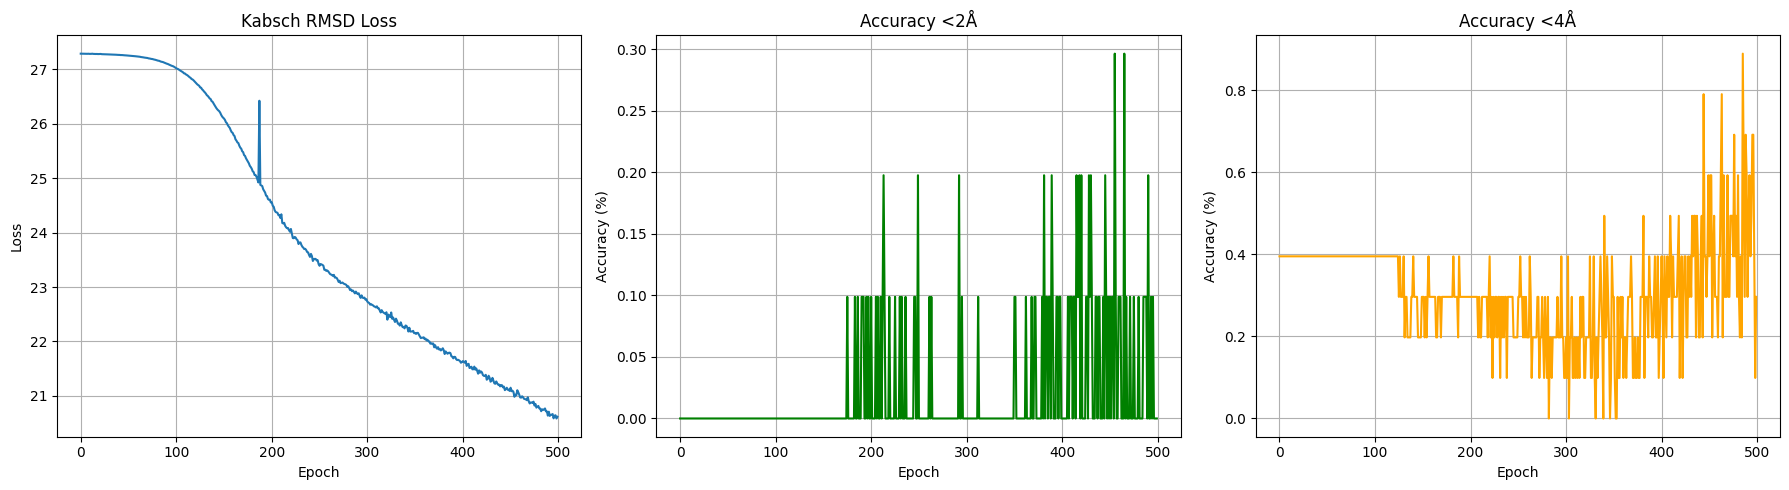

Saved plot to /content/drive/MyDrive/Protein_str/FineTuned_ESM2/plots/model_arch256_128_lr0.0001_wd0.0_drop0.2.png

--- Running model with architecture [256, 128], lr=0.0001, wd=0.0001, dropout=0.0 ---
Epoch 1/500 — Loss: 27.2844 — <2Å: 0.0% — <4Å: 0.4%
Epoch 51/500 — Loss: 27.1963 — <2Å: 0.0% — <4Å: 0.4%
Epoch 101/500 — Loss: 27.0857 — <2Å: 0.0% — <4Å: 0.3%
Epoch 151/500 — Loss: 26.4555 — <2Å: 0.0% — <4Å: 0.3%
Epoch 201/500 — Loss: 25.2837 — <2Å: 0.0% — <4Å: 0.2%
Epoch 251/500 — Loss: 25.7206 — <2Å: 0.0% — <4Å: 0.4%
Epoch 301/500 — Loss: 23.6308 — <2Å: 0.0% — <4Å: 0.2%
Epoch 351/500 — Loss: 25.5795 — <2Å: 0.2% — <4Å: 0.4%
Epoch 401/500 — Loss: 22.9768 — <2Å: 0.0% — <4Å: 0.3%
Epoch 451/500 — Loss: 22.9210 — <2Å: 0.0% — <4Å: 0.2%
Epoch 500/500 — Loss: 22.7066 — <2Å: 0.0% — <4Å: 0.3%


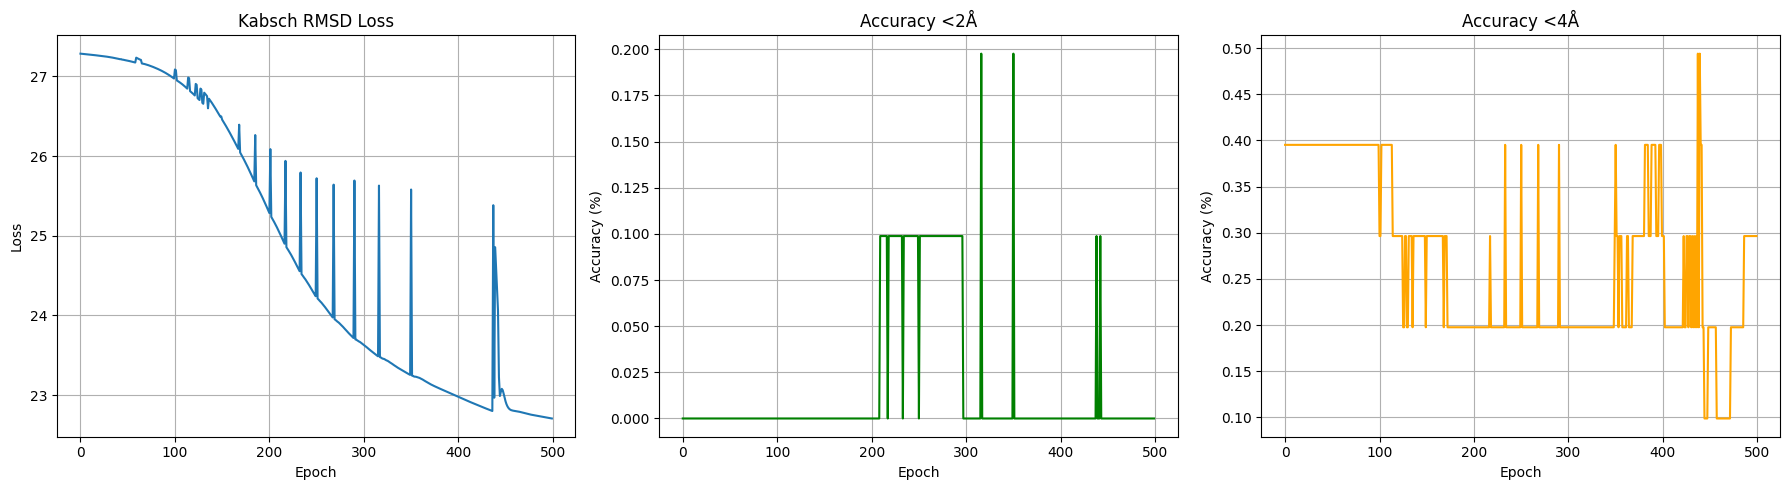

Saved plot to /content/drive/MyDrive/Protein_str/FineTuned_ESM2/plots/model_arch256_128_lr0.0001_wd0.0001_drop0.0.png

--- Running model with architecture [256, 128], lr=0.0001, wd=0.0001, dropout=0.2 ---
Epoch 1/500 — Loss: 27.2848 — <2Å: 0.0% — <4Å: 0.4%
Epoch 51/500 — Loss: 27.2391 — <2Å: 0.0% — <4Å: 0.4%
Epoch 101/500 — Loss: 26.9554 — <2Å: 0.0% — <4Å: 0.4%
Epoch 151/500 — Loss: 25.9620 — <2Å: 0.0% — <4Å: 0.1%
Epoch 201/500 — Loss: 24.3496 — <2Å: 0.1% — <4Å: 0.2%
Epoch 251/500 — Loss: 23.0830 — <2Å: 0.0% — <4Å: 0.2%
Epoch 301/500 — Loss: 22.0029 — <2Å: 0.0% — <4Å: 0.0%
Epoch 351/500 — Loss: 21.0583 — <2Å: 0.0% — <4Å: 0.0%
Epoch 401/500 — Loss: 20.2443 — <2Å: 0.0% — <4Å: 0.3%
Epoch 451/500 — Loss: 19.4189 — <2Å: 0.0% — <4Å: 0.1%
Epoch 500/500 — Loss: 18.8293 — <2Å: 0.1% — <4Å: 0.4%


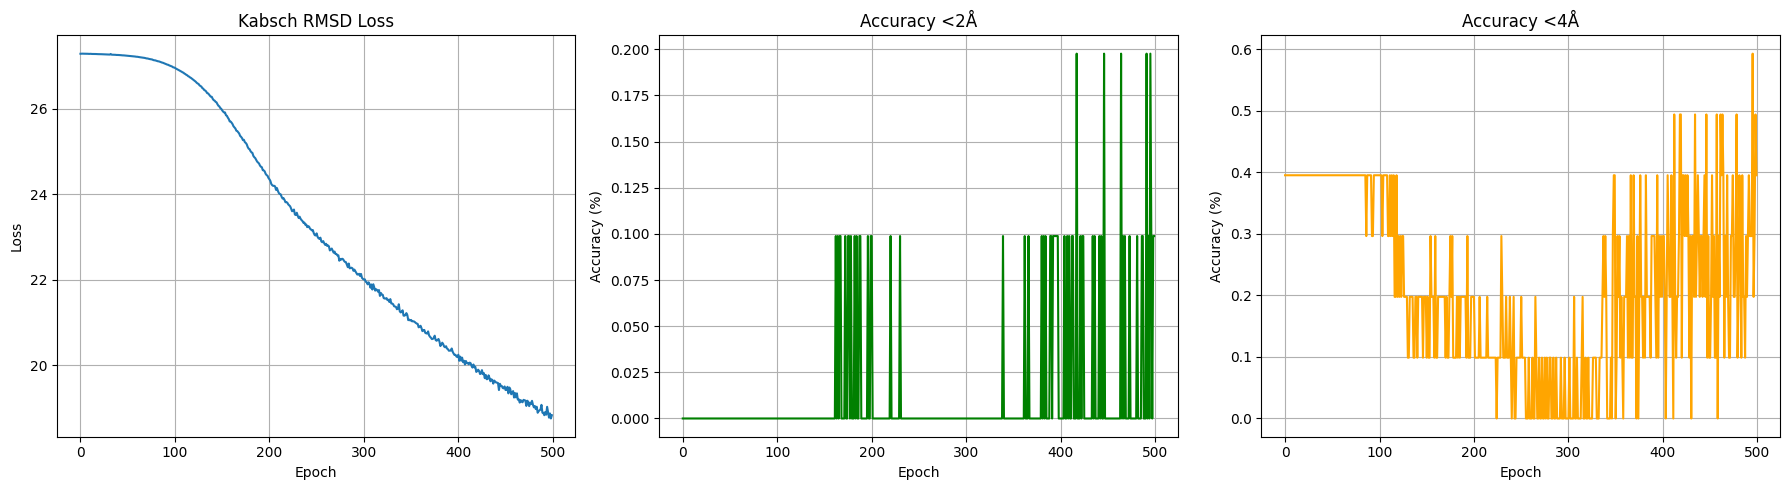

Saved plot to /content/drive/MyDrive/Protein_str/FineTuned_ESM2/plots/model_arch256_128_lr0.0001_wd0.0001_drop0.2.png

--- Running model with architecture [512, 256, 128], lr=0.01, wd=0.0, dropout=0.0 ---
Epoch 1/500 — Loss: 27.2859 — <2Å: 0.0% — <4Å: 0.4%
Epoch 51/500 — Loss: 14.9915 — <2Å: 0.1% — <4Å: 0.7%
Epoch 101/500 — Loss: 16.9199 — <2Å: 0.0% — <4Å: 0.4%
Epoch 151/500 — Loss: 4.5420 — <2Å: 5.5% — <4Å: 28.8%
Epoch 201/500 — Loss: 3.1777 — <2Å: 15.3% — <4Å: 52.1%
Epoch 251/500 — Loss: 4.3877 — <2Å: 5.7% — <4Å: 26.7%
Epoch 301/500 — Loss: 1.9312 — <2Å: 30.9% — <4Å: 80.0%
Epoch 351/500 — Loss: 2.0845 — <2Å: 21.1% — <4Å: 77.0%
Epoch 401/500 — Loss: 1.1744 — <2Å: 69.6% — <4Å: 96.2%
Epoch 451/500 — Loss: 1.2727 — <2Å: 58.8% — <4Å: 96.3%
Epoch 500/500 — Loss: 0.6437 — <2Å: 95.1% — <4Å: 99.5%


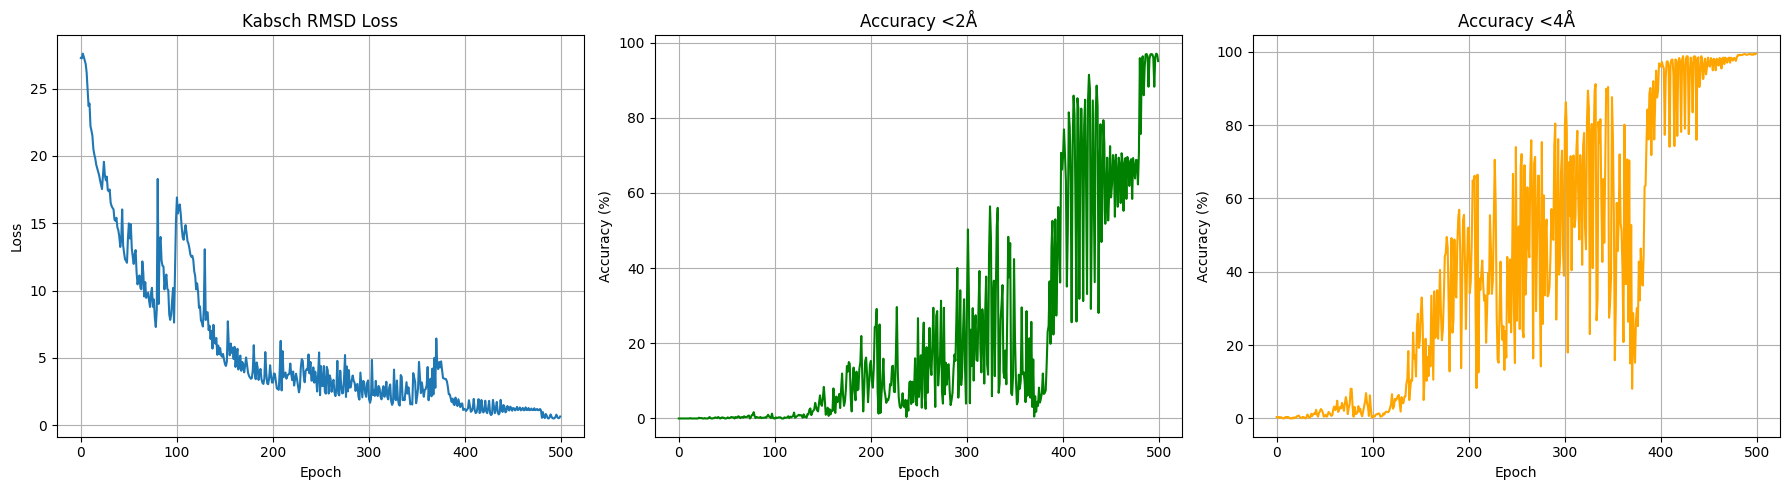

Saved plot to /content/drive/MyDrive/Protein_str/FineTuned_ESM2/plots/model_arch512_256_128_lr0.01_wd0.0_drop0.0.png

--- Running model with architecture [512, 256, 128], lr=0.01, wd=0.0, dropout=0.2 ---
Epoch 1/500 — Loss: 27.2864 — <2Å: 0.0% — <4Å: 0.4%
Epoch 51/500 — Loss: 13.8875 — <2Å: 0.1% — <4Å: 1.3%
Epoch 101/500 — Loss: 15.9235 — <2Å: 0.1% — <4Å: 0.8%
Epoch 151/500 — Loss: 9.4274 — <2Å: 0.5% — <4Å: 5.9%
Epoch 201/500 — Loss: 10.5517 — <2Å: 0.6% — <4Å: 3.0%
Epoch 251/500 — Loss: 9.2907 — <2Å: 0.6% — <4Å: 5.0%
Epoch 301/500 — Loss: 11.6953 — <2Å: 0.8% — <4Å: 2.4%
Epoch 351/500 — Loss: 8.4398 — <2Å: 0.8% — <4Å: 6.1%
Epoch 401/500 — Loss: 8.5123 — <2Å: 0.8% — <4Å: 7.4%
Epoch 451/500 — Loss: 7.9531 — <2Å: 1.5% — <4Å: 8.0%
Epoch 500/500 — Loss: 6.9951 — <2Å: 1.2% — <4Å: 8.7%


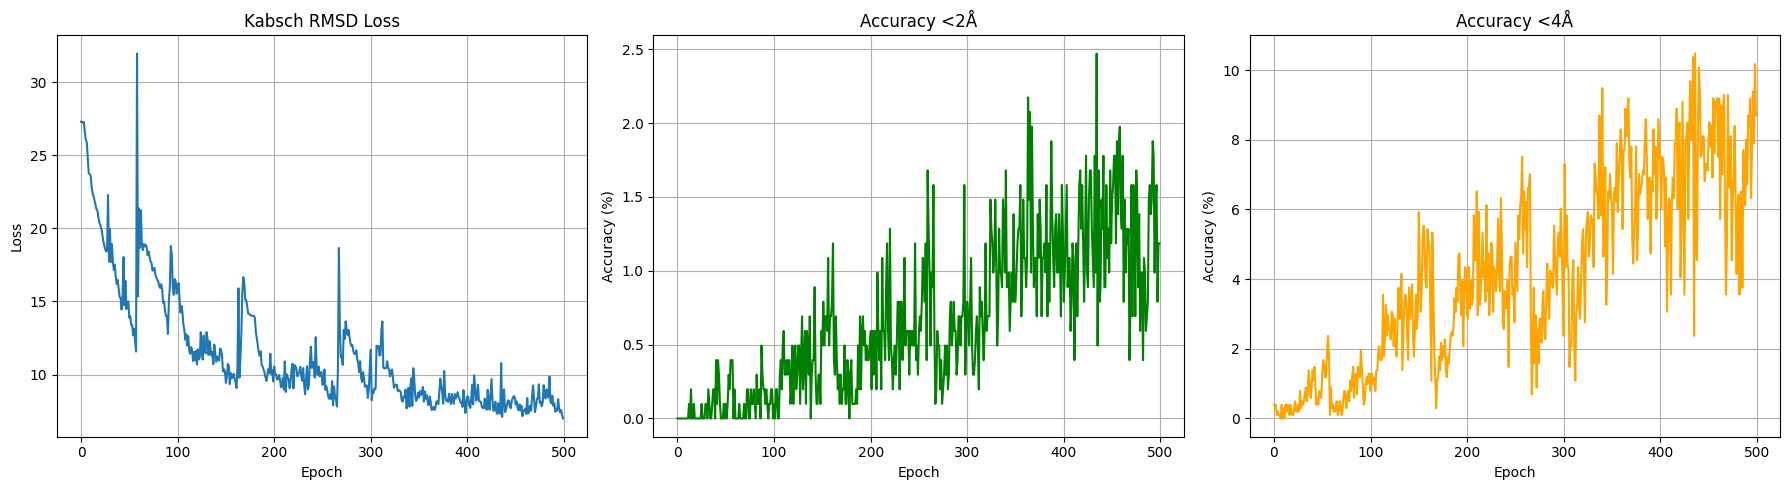

Saved plot to /content/drive/MyDrive/Protein_str/FineTuned_ESM2/plots/model_arch512_256_128_lr0.01_wd0.0_drop0.2.png

--- Running model with architecture [512, 256, 128], lr=0.01, wd=0.0001, dropout=0.0 ---
Epoch 1/500 — Loss: 27.2866 — <2Å: 0.0% — <4Å: 0.4%
Epoch 51/500 — Loss: 19.5334 — <2Å: 0.0% — <4Å: 0.4%
Epoch 101/500 — Loss: 13.7497 — <2Å: 0.3% — <4Å: 1.2%
Epoch 151/500 — Loss: 19.6858 — <2Å: 0.0% — <4Å: 0.5%
Epoch 201/500 — Loss: 19.7600 — <2Å: 0.0% — <4Å: 0.2%
Epoch 251/500 — Loss: 11.4799 — <2Å: 0.1% — <4Å: 1.5%
Epoch 301/500 — Loss: 10.6185 — <2Å: 0.4% — <4Å: 2.7%
Epoch 351/500 — Loss: 7.6602 — <2Å: 1.5% — <4Å: 9.5%
Epoch 401/500 — Loss: 11.5814 — <2Å: 0.3% — <4Å: 2.9%
Epoch 451/500 — Loss: 15.7990 — <2Å: 0.0% — <4Å: 0.2%
Epoch 500/500 — Loss: 9.1948 — <2Å: 0.9% — <4Å: 5.2%


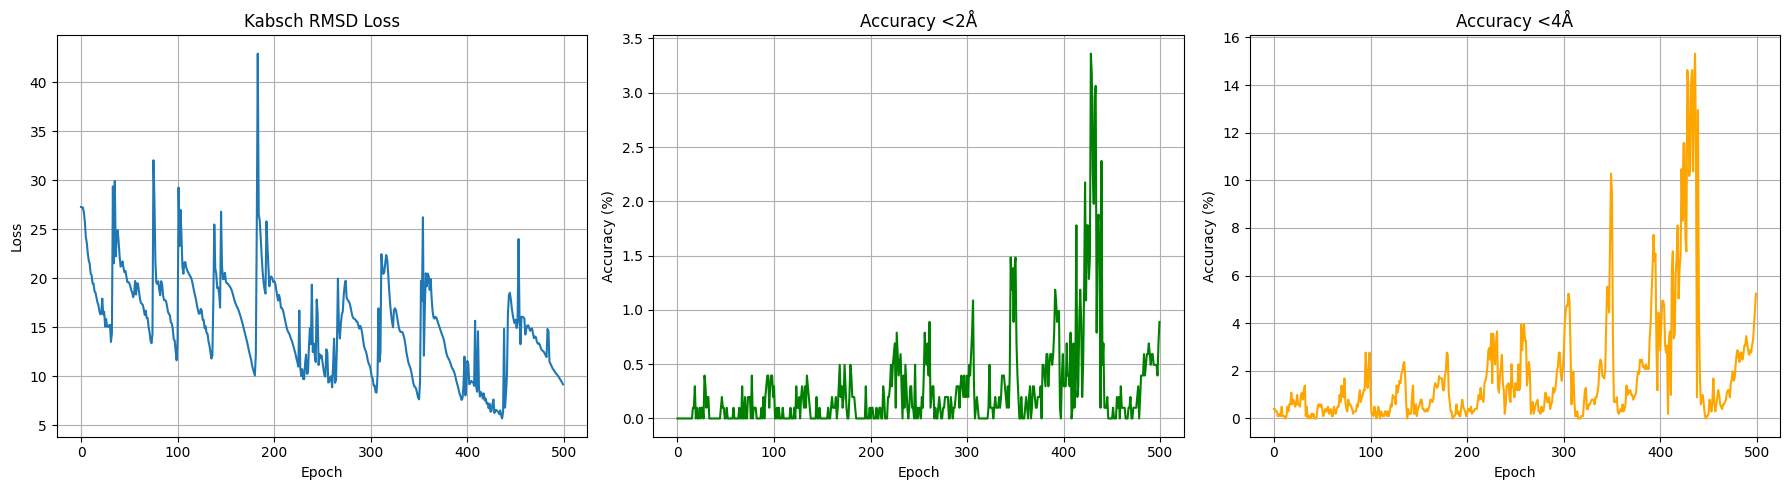

Saved plot to /content/drive/MyDrive/Protein_str/FineTuned_ESM2/plots/model_arch512_256_128_lr0.01_wd0.0001_drop0.0.png

--- Running model with architecture [512, 256, 128], lr=0.01, wd=0.0001, dropout=0.2 ---
Epoch 1/500 — Loss: 27.2867 — <2Å: 0.0% — <4Å: 0.4%
Epoch 51/500 — Loss: 15.0179 — <2Å: 0.4% — <4Å: 0.8%
Epoch 101/500 — Loss: 10.6646 — <2Å: 0.5% — <4Å: 2.9%
Epoch 151/500 — Loss: 18.9318 — <2Å: 0.0% — <4Å: 0.5%
Epoch 201/500 — Loss: 12.6180 — <2Å: 0.1% — <4Å: 2.9%
Epoch 251/500 — Loss: 10.9382 — <2Å: 0.6% — <4Å: 3.6%
Epoch 301/500 — Loss: 9.2325 — <2Å: 1.0% — <4Å: 6.7%
Epoch 351/500 — Loss: 9.4389 — <2Å: 1.3% — <4Å: 6.0%
Epoch 401/500 — Loss: 8.6900 — <2Å: 0.6% — <4Å: 7.3%
Epoch 451/500 — Loss: 8.6612 — <2Å: 1.6% — <4Å: 6.3%
Epoch 500/500 — Loss: 8.6928 — <2Å: 1.7% — <4Å: 7.0%


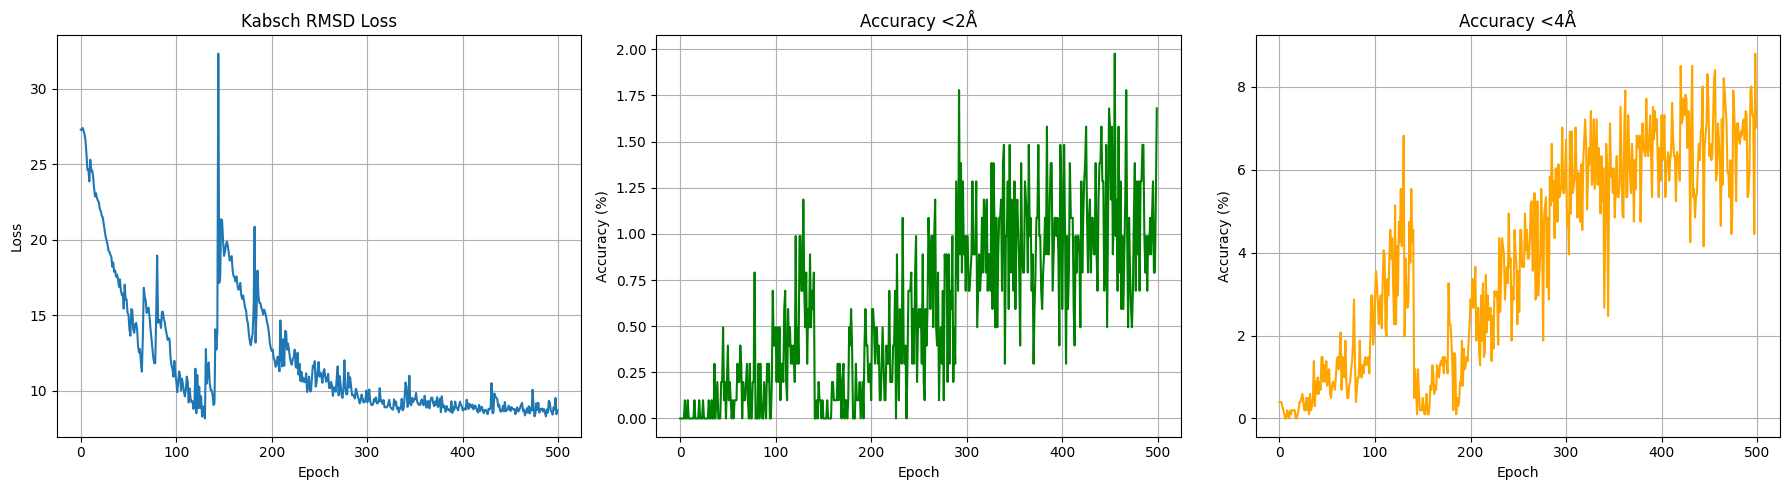

Saved plot to /content/drive/MyDrive/Protein_str/FineTuned_ESM2/plots/model_arch512_256_128_lr0.01_wd0.0001_drop0.2.png

--- Running model with architecture [512, 256, 128], lr=0.001, wd=0.0, dropout=0.0 ---
Epoch 1/500 — Loss: 27.2861 — <2Å: 0.0% — <4Å: 0.4%
Epoch 51/500 — Loss: 22.1948 — <2Å: 0.0% — <4Å: 0.1%
Epoch 101/500 — Loss: 16.9740 — <2Å: 0.0% — <4Å: 0.7%
Epoch 151/500 — Loss: 10.6223 — <2Å: 0.5% — <4Å: 2.4%
Epoch 201/500 — Loss: 8.3336 — <2Å: 0.8% — <4Å: 4.5%
Epoch 251/500 — Loss: 24.1323 — <2Å: 0.0% — <4Å: 0.0%
Epoch 301/500 — Loss: 14.6928 — <2Å: 0.0% — <4Å: 1.7%
Epoch 351/500 — Loss: 10.0336 — <2Å: 0.4% — <4Å: 4.3%
Epoch 401/500 — Loss: 8.1439 — <2Å: 0.9% — <4Å: 6.6%
Epoch 451/500 — Loss: 7.5182 — <2Å: 1.3% — <4Å: 7.8%
Epoch 500/500 — Loss: 7.1935 — <2Å: 1.5% — <4Å: 8.3%


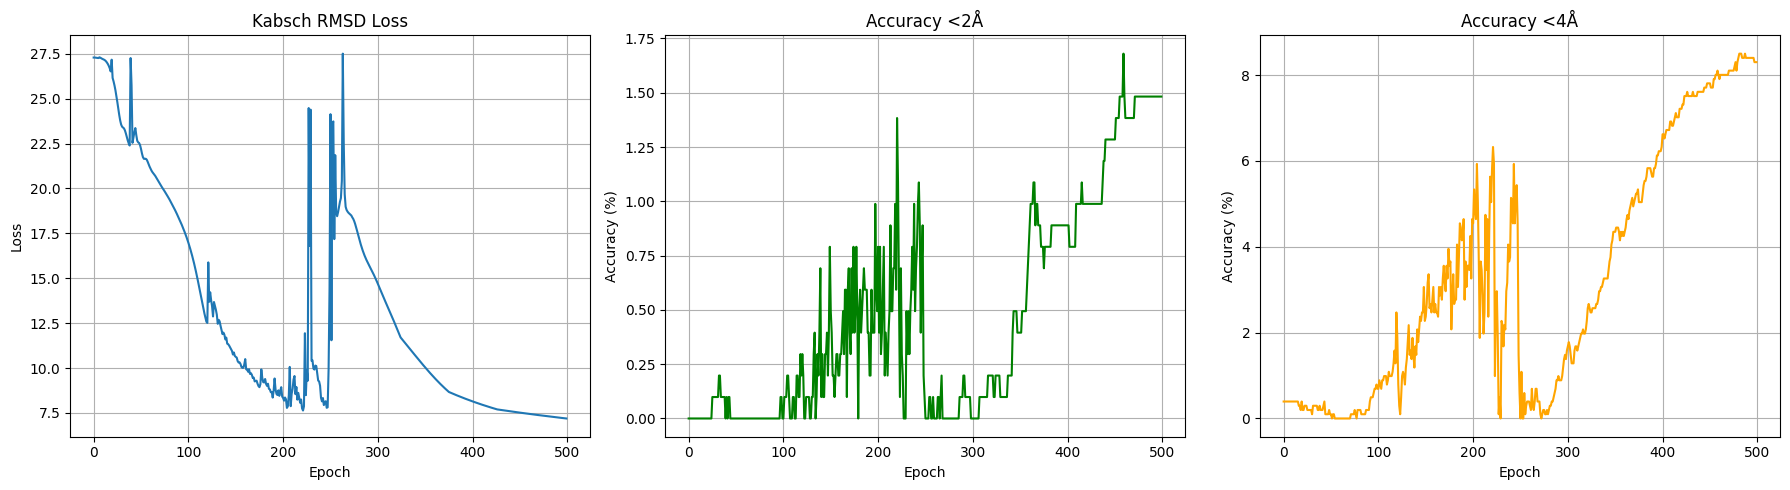

Saved plot to /content/drive/MyDrive/Protein_str/FineTuned_ESM2/plots/model_arch512_256_128_lr0.001_wd0.0_drop0.0.png

--- Running model with architecture [512, 256, 128], lr=0.001, wd=0.0, dropout=0.2 ---
Epoch 1/500 — Loss: 27.2871 — <2Å: 0.0% — <4Å: 0.4%
Epoch 51/500 — Loss: 22.8366 — <2Å: 0.1% — <4Å: 0.4%
Epoch 101/500 — Loss: 21.2116 — <2Å: 0.0% — <4Å: 0.3%
Epoch 151/500 — Loss: 20.4240 — <2Å: 0.0% — <4Å: 0.5%
Epoch 201/500 — Loss: 16.7575 — <2Å: 0.2% — <4Å: 0.8%
Epoch 251/500 — Loss: 16.2322 — <2Å: 0.1% — <4Å: 0.9%
Epoch 301/500 — Loss: 11.5486 — <2Å: 0.2% — <4Å: 1.7%
Epoch 351/500 — Loss: 12.3046 — <2Å: 0.5% — <4Å: 2.7%
Epoch 401/500 — Loss: 9.1947 — <2Å: 1.1% — <4Å: 3.1%
Epoch 451/500 — Loss: 9.2342 — <2Å: 0.5% — <4Å: 4.3%
Epoch 500/500 — Loss: 9.2572 — <2Å: 0.8% — <4Å: 4.1%


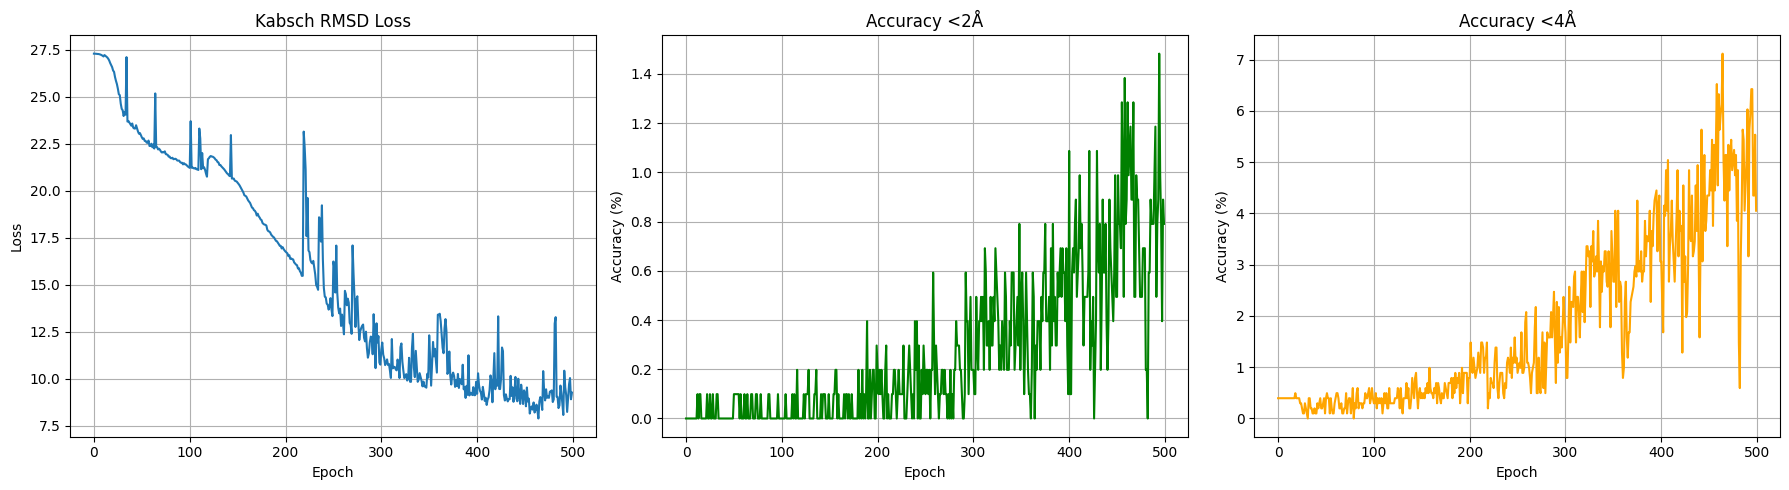

Saved plot to /content/drive/MyDrive/Protein_str/FineTuned_ESM2/plots/model_arch512_256_128_lr0.001_wd0.0_drop0.2.png

--- Running model with architecture [512, 256, 128], lr=0.001, wd=0.0001, dropout=0.0 ---
Epoch 1/500 — Loss: 27.2863 — <2Å: 0.0% — <4Å: 0.4%
Epoch 51/500 — Loss: 21.6592 — <2Å: 0.0% — <4Å: 0.1%
Epoch 101/500 — Loss: 13.6823 — <2Å: 0.0% — <4Å: 1.4%
Epoch 151/500 — Loss: 9.3335 — <2Å: 0.5% — <4Å: 3.3%
Epoch 201/500 — Loss: 7.7012 — <2Å: 1.2% — <4Å: 5.5%
Epoch 251/500 — Loss: 7.2048 — <2Å: 1.6% — <4Å: 8.8%
Epoch 301/500 — Loss: 6.7289 — <2Å: 1.1% — <4Å: 7.3%
Epoch 351/500 — Loss: 5.9395 — <2Å: 1.1% — <4Å: 12.6%
Epoch 401/500 — Loss: 6.0621 — <2Å: 1.6% — <4Å: 11.6%
Epoch 451/500 — Loss: 5.8561 — <2Å: 1.8% — <4Å: 12.6%
Epoch 500/500 — Loss: 5.1498 — <2Å: 2.1% — <4Å: 17.0%


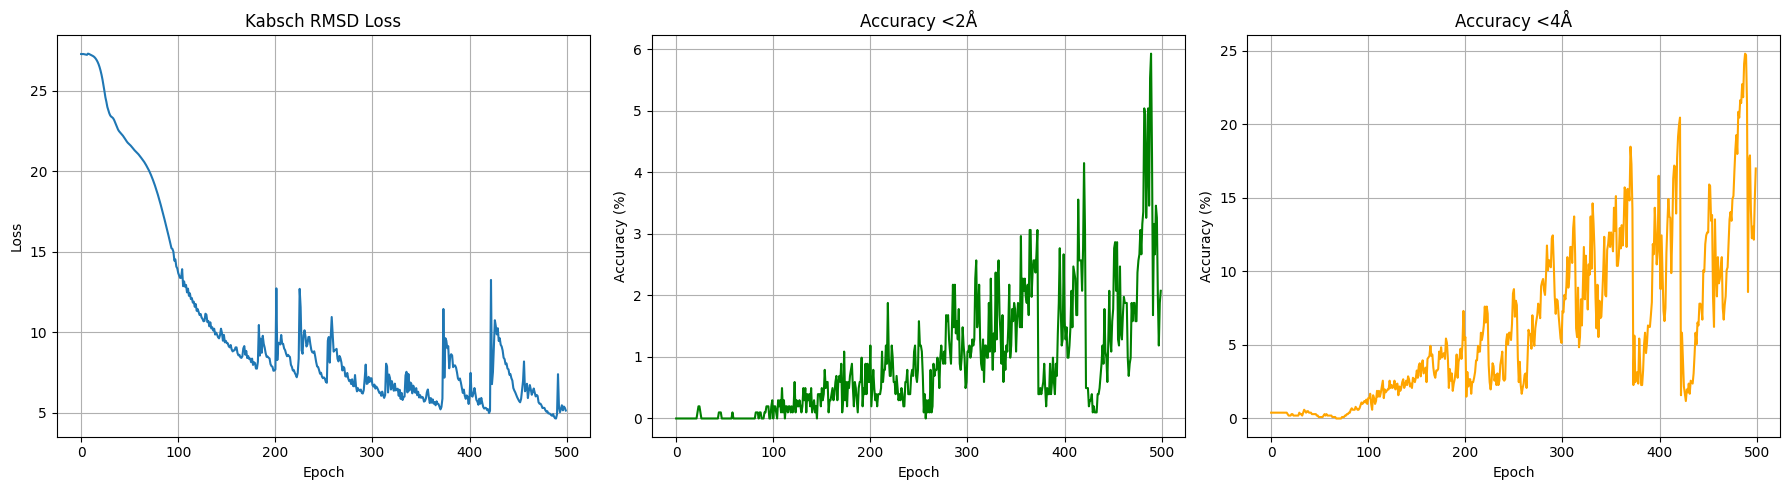

Saved plot to /content/drive/MyDrive/Protein_str/FineTuned_ESM2/plots/model_arch512_256_128_lr0.001_wd0.0001_drop0.0.png

--- Running model with architecture [512, 256, 128], lr=0.001, wd=0.0001, dropout=0.2 ---
Epoch 1/500 — Loss: 27.2866 — <2Å: 0.0% — <4Å: 0.4%
Epoch 51/500 — Loss: 25.1490 — <2Å: 0.1% — <4Å: 0.2%
Epoch 101/500 — Loss: 22.9871 — <2Å: 0.0% — <4Å: 0.2%
Epoch 151/500 — Loss: 22.7332 — <2Å: 0.1% — <4Å: 0.4%
Epoch 201/500 — Loss: 22.1881 — <2Å: 0.0% — <4Å: 0.6%
Epoch 251/500 — Loss: 21.2547 — <2Å: 0.0% — <4Å: 0.5%
Epoch 301/500 — Loss: 18.4487 — <2Å: 0.0% — <4Å: 0.7%
Epoch 351/500 — Loss: 15.1613 — <2Å: 0.2% — <4Å: 1.5%
Epoch 401/500 — Loss: 11.7707 — <2Å: 0.2% — <4Å: 1.4%
Epoch 451/500 — Loss: 15.5672 — <2Å: 0.0% — <4Å: 0.2%
Epoch 500/500 — Loss: 9.6867 — <2Å: 0.3% — <4Å: 4.1%


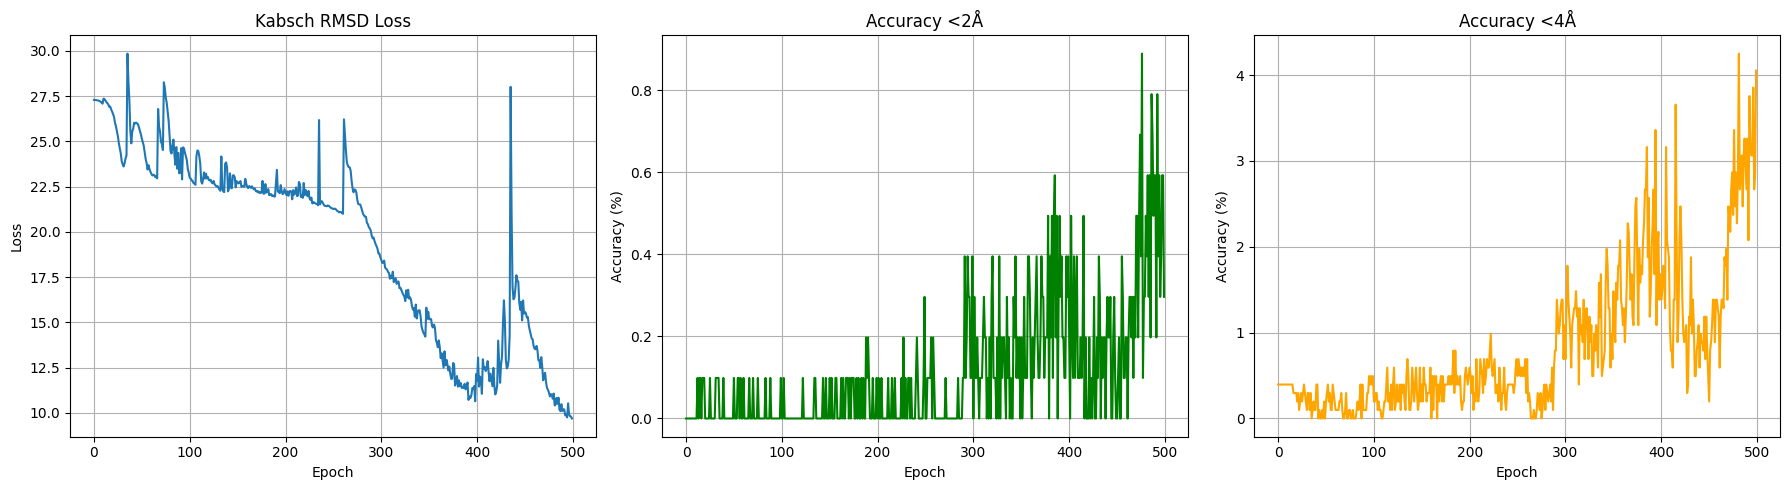

Saved plot to /content/drive/MyDrive/Protein_str/FineTuned_ESM2/plots/model_arch512_256_128_lr0.001_wd0.0001_drop0.2.png

--- Running model with architecture [512, 256, 128], lr=0.0001, wd=0.0, dropout=0.0 ---
Epoch 1/500 — Loss: 27.2859 — <2Å: 0.0% — <4Å: 0.4%
Epoch 51/500 — Loss: 27.2327 — <2Å: 0.0% — <4Å: 0.4%
Epoch 101/500 — Loss: 26.5693 — <2Å: 0.0% — <4Å: 0.3%
Epoch 151/500 — Loss: 23.7499 — <2Å: 0.0% — <4Å: 0.1%
Epoch 201/500 — Loss: 22.7233 — <2Å: 0.0% — <4Å: 0.2%
Epoch 251/500 — Loss: 22.2583 — <2Å: 0.0% — <4Å: 0.1%
Epoch 301/500 — Loss: 21.9033 — <2Å: 0.0% — <4Å: 0.2%
Epoch 351/500 — Loss: 21.6908 — <2Å: 0.0% — <4Å: 0.2%
Epoch 401/500 — Loss: 21.5638 — <2Å: 0.0% — <4Å: 0.3%
Epoch 451/500 — Loss: 21.4703 — <2Å: 0.0% — <4Å: 0.4%
Epoch 500/500 — Loss: 21.4067 — <2Å: 0.0% — <4Å: 0.5%


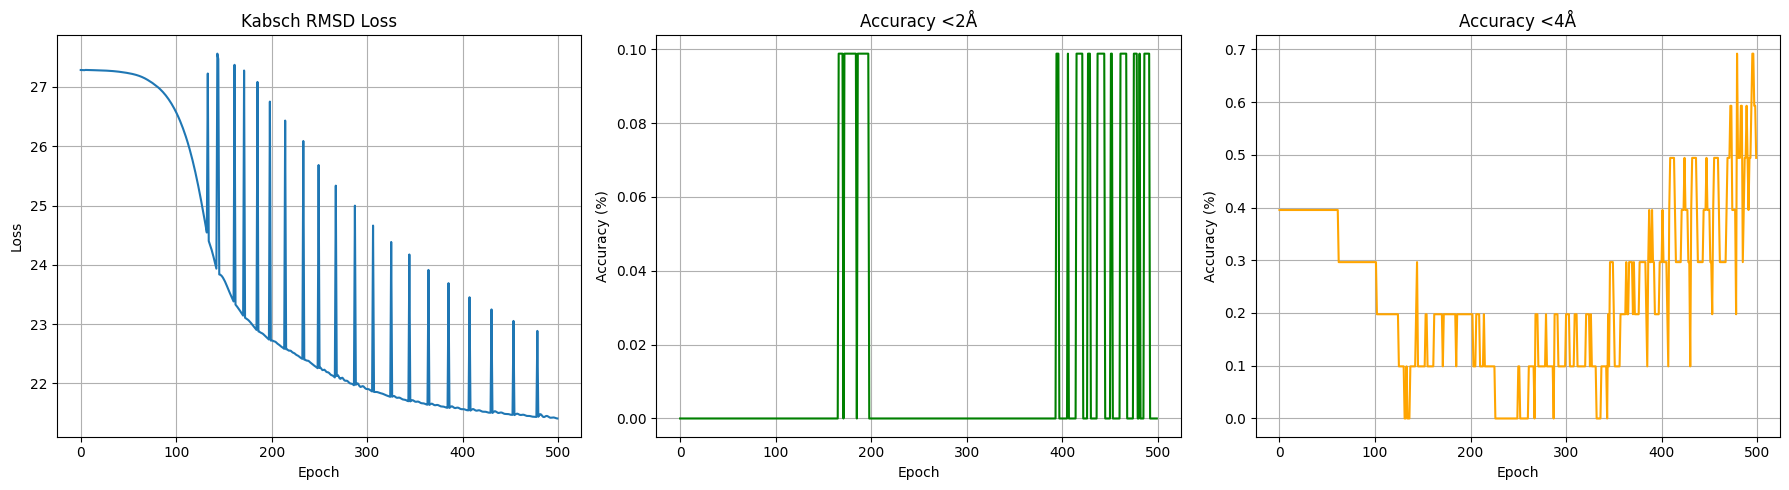

Saved plot to /content/drive/MyDrive/Protein_str/FineTuned_ESM2/plots/model_arch512_256_128_lr0.0001_wd0.0_drop0.0.png

--- Running model with architecture [512, 256, 128], lr=0.0001, wd=0.0, dropout=0.2 ---
Epoch 1/500 — Loss: 27.2861 — <2Å: 0.0% — <4Å: 0.4%
Epoch 51/500 — Loss: 27.2171 — <2Å: 0.0% — <4Å: 0.4%
Epoch 101/500 — Loss: 26.2180 — <2Å: 0.0% — <4Å: 0.1%
Epoch 151/500 — Loss: 23.8972 — <2Å: 0.0% — <4Å: 0.1%
Epoch 201/500 — Loss: 23.3634 — <2Å: 0.0% — <4Å: 0.2%
Epoch 251/500 — Loss: 21.8903 — <2Å: 0.0% — <4Å: 0.1%
Epoch 301/500 — Loss: 20.7599 — <2Å: 0.0% — <4Å: 0.0%
Epoch 351/500 — Loss: 19.3017 — <2Å: 0.0% — <4Å: 0.2%
Epoch 401/500 — Loss: 17.7071 — <2Å: 0.1% — <4Å: 0.7%
Epoch 451/500 — Loss: 15.6503 — <2Å: 0.1% — <4Å: 1.2%
Epoch 500/500 — Loss: 14.1962 — <2Å: 0.1% — <4Å: 1.4%


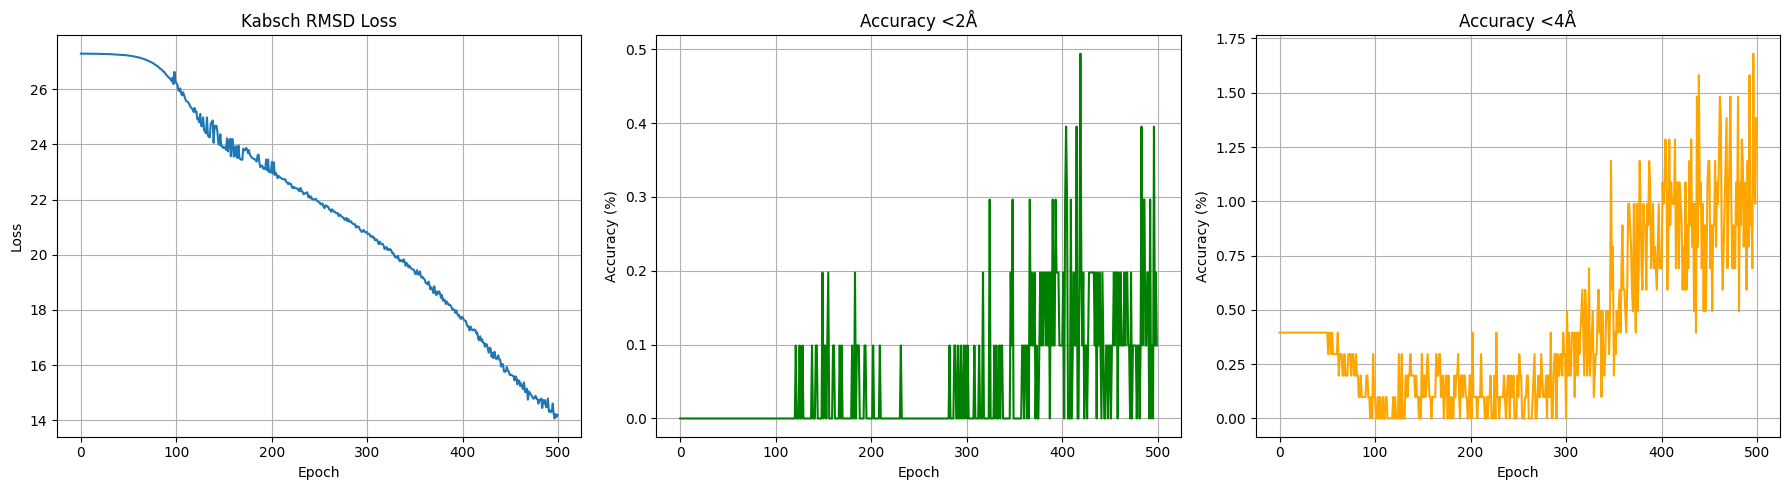

Saved plot to /content/drive/MyDrive/Protein_str/FineTuned_ESM2/plots/model_arch512_256_128_lr0.0001_wd0.0_drop0.2.png

--- Running model with architecture [512, 256, 128], lr=0.0001, wd=0.0001, dropout=0.0 ---
Epoch 1/500 — Loss: 27.2866 — <2Å: 0.0% — <4Å: 0.4%
Epoch 51/500 — Loss: 27.1089 — <2Å: 0.0% — <4Å: 0.4%
Epoch 101/500 — Loss: 25.0445 — <2Å: 0.0% — <4Å: 0.2%
Epoch 151/500 — Loss: 22.5017 — <2Å: 0.0% — <4Å: 0.5%
Epoch 201/500 — Loss: 20.8397 — <2Å: 0.0% — <4Å: 0.1%
Epoch 251/500 — Loss: 19.2738 — <2Å: 0.0% — <4Å: 0.1%
Epoch 301/500 — Loss: 17.9680 — <2Å: 0.1% — <4Å: 0.2%
Epoch 351/500 — Loss: 16.5998 — <2Å: 0.3% — <4Å: 0.7%
Epoch 401/500 — Loss: 14.5222 — <2Å: 0.2% — <4Å: 1.5%
Epoch 451/500 — Loss: 11.6265 — <2Å: 0.4% — <4Å: 2.6%
Epoch 500/500 — Loss: 8.8220 — <2Å: 0.4% — <4Å: 5.9%


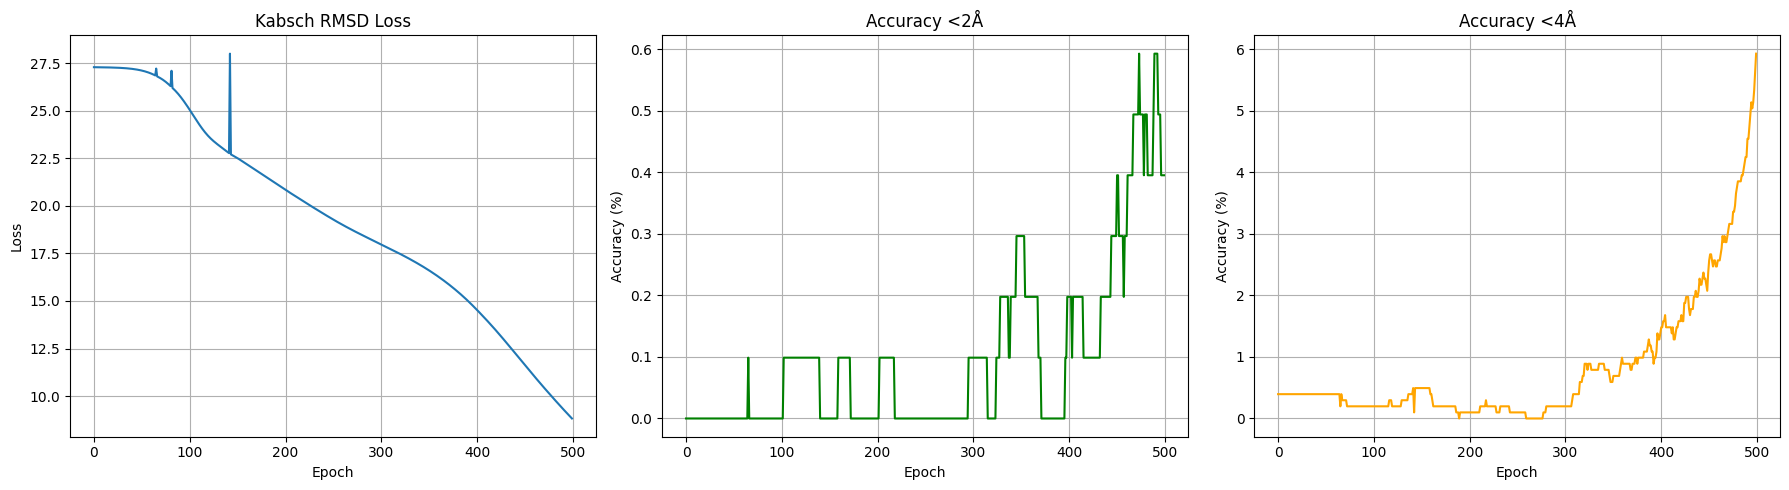

Saved plot to /content/drive/MyDrive/Protein_str/FineTuned_ESM2/plots/model_arch512_256_128_lr0.0001_wd0.0001_drop0.0.png

--- Running model with architecture [512, 256, 128], lr=0.0001, wd=0.0001, dropout=0.2 ---
Epoch 1/500 — Loss: 27.2857 — <2Å: 0.0% — <4Å: 0.4%
Epoch 51/500 — Loss: 27.2211 — <2Å: 0.0% — <4Å: 0.4%
Epoch 101/500 — Loss: 26.5398 — <2Å: 0.0% — <4Å: 0.3%
Epoch 151/500 — Loss: 23.9353 — <2Å: 0.0% — <4Å: 0.1%
Epoch 201/500 — Loss: 22.7207 — <2Å: 0.0% — <4Å: 0.3%
Epoch 251/500 — Loss: 21.9833 — <2Å: 0.1% — <4Å: 0.3%
Epoch 301/500 — Loss: 21.5480 — <2Å: 0.0% — <4Å: 0.0%
Epoch 351/500 — Loss: 21.0147 — <2Å: 0.0% — <4Å: 0.3%
Epoch 401/500 — Loss: 20.5557 — <2Å: 0.0% — <4Å: 0.2%
Epoch 451/500 — Loss: 19.7337 — <2Å: 0.0% — <4Å: 0.4%
Epoch 500/500 — Loss: 18.7717 — <2Å: 0.1% — <4Å: 0.6%


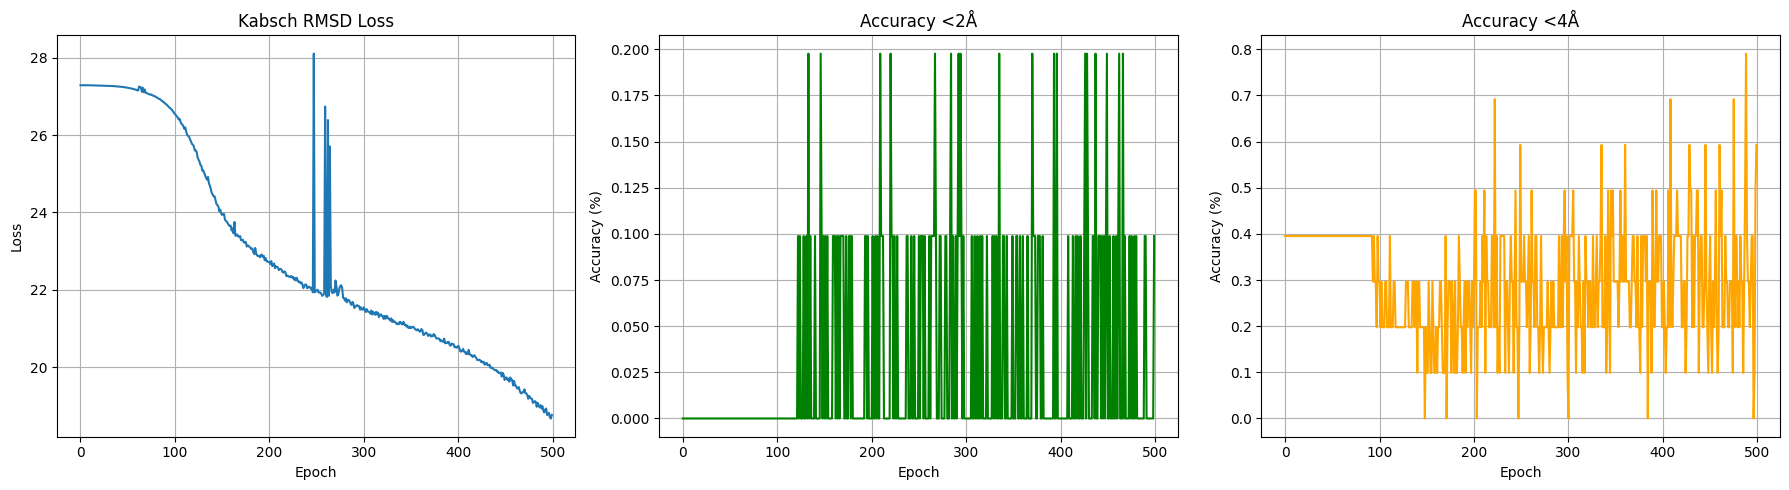

Saved plot to /content/drive/MyDrive/Protein_str/FineTuned_ESM2/plots/model_arch512_256_128_lr0.0001_wd0.0001_drop0.2.png

--- Running model with architecture [1024, 512, 256, 128], lr=0.01, wd=0.0, dropout=0.0 ---
Epoch 1/500 — Loss: 27.2865 — <2Å: 0.0% — <4Å: 0.4%
Epoch 51/500 — Loss: 22.9037 — <2Å: 0.0% — <4Å: 0.1%
Epoch 101/500 — Loss: 17.7395 — <2Å: 0.2% — <4Å: 1.3%
Epoch 151/500 — Loss: 10.2898 — <2Å: 1.0% — <4Å: 5.1%
Epoch 201/500 — Loss: 10.0214 — <2Å: 0.4% — <4Å: 3.5%
Epoch 251/500 — Loss: 16.7311 — <2Å: 0.2% — <4Å: 1.3%
Epoch 301/500 — Loss: 16.2571 — <2Å: 0.2% — <4Å: 1.2%
Epoch 351/500 — Loss: 13.2983 — <2Å: 0.7% — <4Å: 3.0%
Epoch 401/500 — Loss: 10.5759 — <2Å: 0.3% — <4Å: 4.8%
Epoch 451/500 — Loss: 11.6314 — <2Å: 0.3% — <4Å: 2.1%
Epoch 500/500 — Loss: 8.4978 — <2Å: 0.8% — <4Å: 5.6%


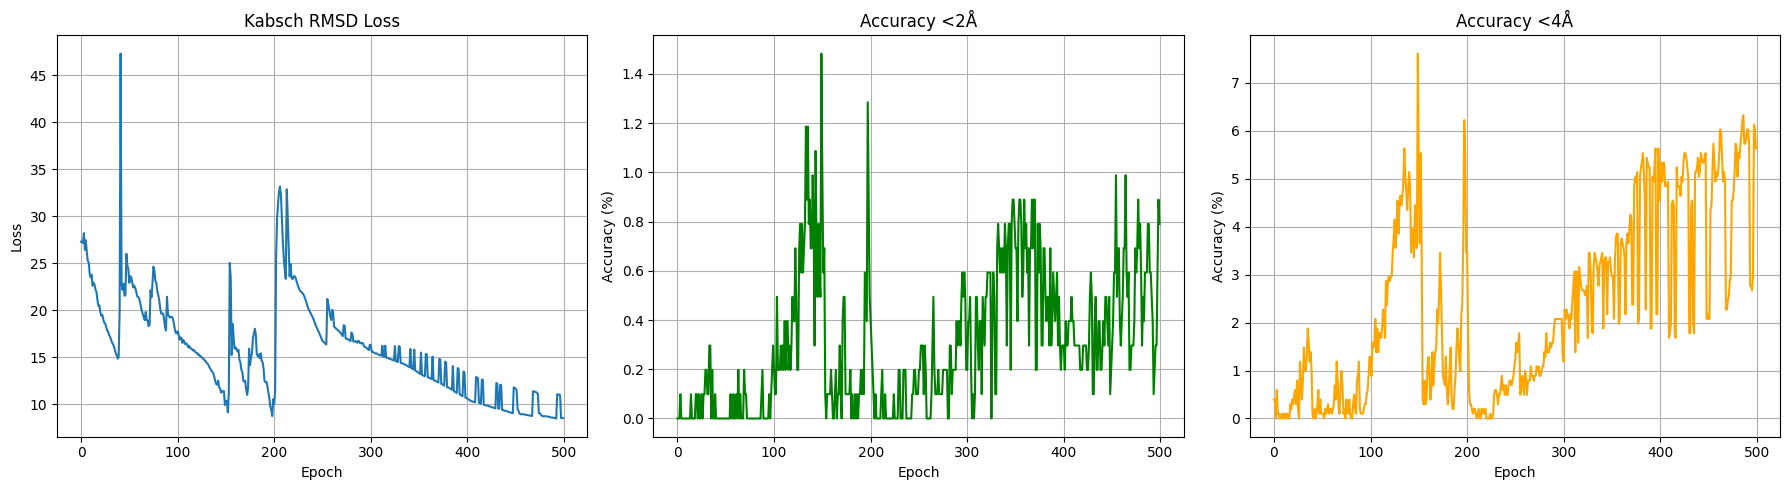

Saved plot to /content/drive/MyDrive/Protein_str/FineTuned_ESM2/plots/model_arch1024_512_256_128_lr0.01_wd0.0_drop0.0.png

--- Running model with architecture [1024, 512, 256, 128], lr=0.01, wd=0.0, dropout=0.2 ---
Epoch 1/500 — Loss: 27.2865 — <2Å: 0.0% — <4Å: 0.4%
Epoch 51/500 — Loss: 19.8937 — <2Å: 0.0% — <4Å: 0.5%
Epoch 101/500 — Loss: 21.4024 — <2Å: 0.0% — <4Å: 0.3%
Epoch 151/500 — Loss: 17.9065 — <2Å: 0.2% — <4Å: 1.0%
Epoch 201/500 — Loss: 16.4187 — <2Å: 0.3% — <4Å: 1.1%
Epoch 251/500 — Loss: 12.8227 — <2Å: 0.3% — <4Å: 2.6%
Epoch 301/500 — Loss: 15.7030 — <2Å: 0.3% — <4Å: 1.7%
Epoch 351/500 — Loss: 10.0365 — <2Å: 0.5% — <4Å: 5.8%
Epoch 401/500 — Loss: 15.7493 — <2Å: 0.0% — <4Å: 1.2%
Epoch 451/500 — Loss: 9.9089 — <2Å: 1.0% — <4Å: 3.8%
Epoch 500/500 — Loss: 9.6999 — <2Å: 0.5% — <4Å: 3.6%


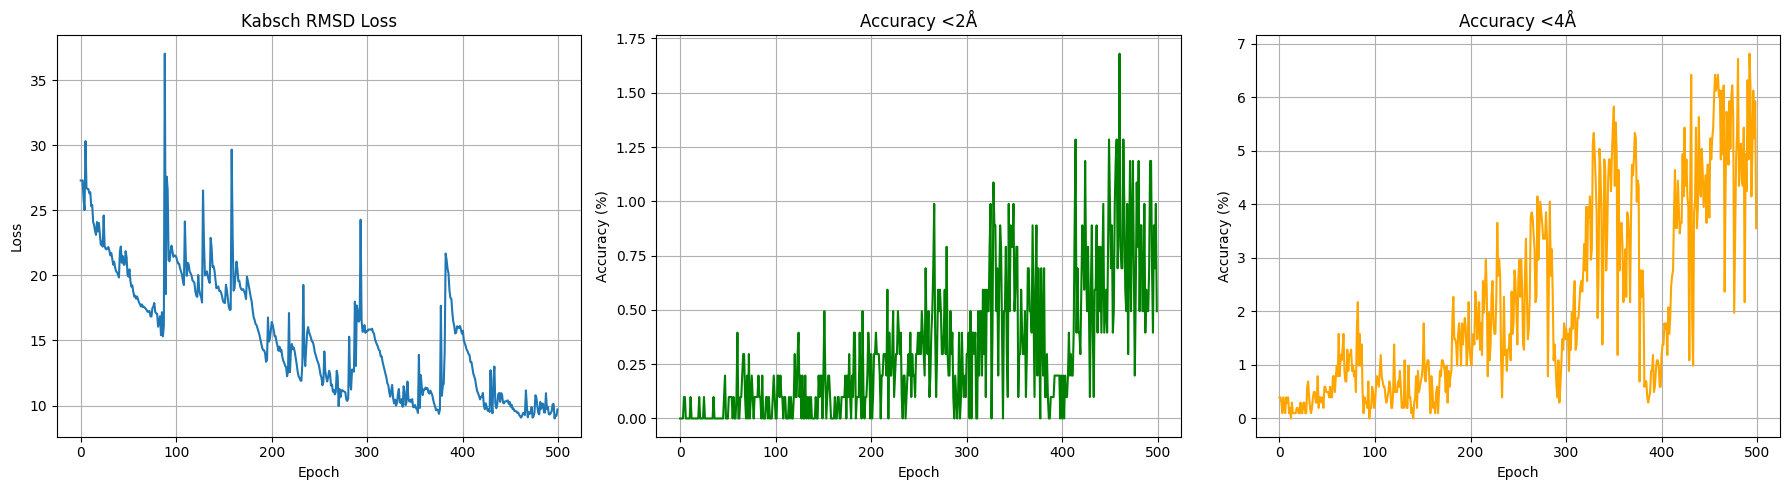

Saved plot to /content/drive/MyDrive/Protein_str/FineTuned_ESM2/plots/model_arch1024_512_256_128_lr0.01_wd0.0_drop0.2.png

--- Running model with architecture [1024, 512, 256, 128], lr=0.01, wd=0.0001, dropout=0.0 ---
Epoch 1/500 — Loss: 27.2866 — <2Å: 0.0% — <4Å: 0.4%
Epoch 51/500 — Loss: 21.2360 — <2Å: 0.0% — <4Å: 0.5%
Epoch 101/500 — Loss: 16.3540 — <2Å: 0.1% — <4Å: 1.2%
Epoch 151/500 — Loss: 19.2214 — <2Å: 0.0% — <4Å: 0.9%
Epoch 201/500 — Loss: 14.5703 — <2Å: 0.1% — <4Å: 0.5%
Epoch 251/500 — Loss: 11.1694 — <2Å: 0.5% — <4Å: 3.0%
Epoch 301/500 — Loss: 10.1284 — <2Å: 0.4% — <4Å: 2.1%
Epoch 351/500 — Loss: 12.1699 — <2Å: 0.3% — <4Å: 1.7%
Epoch 401/500 — Loss: 12.4570 — <2Å: 0.4% — <4Å: 2.4%
Epoch 451/500 — Loss: 13.0546 — <2Å: 0.2% — <4Å: 1.6%
Epoch 500/500 — Loss: 6.8025 — <2Å: 2.3% — <4Å: 11.2%


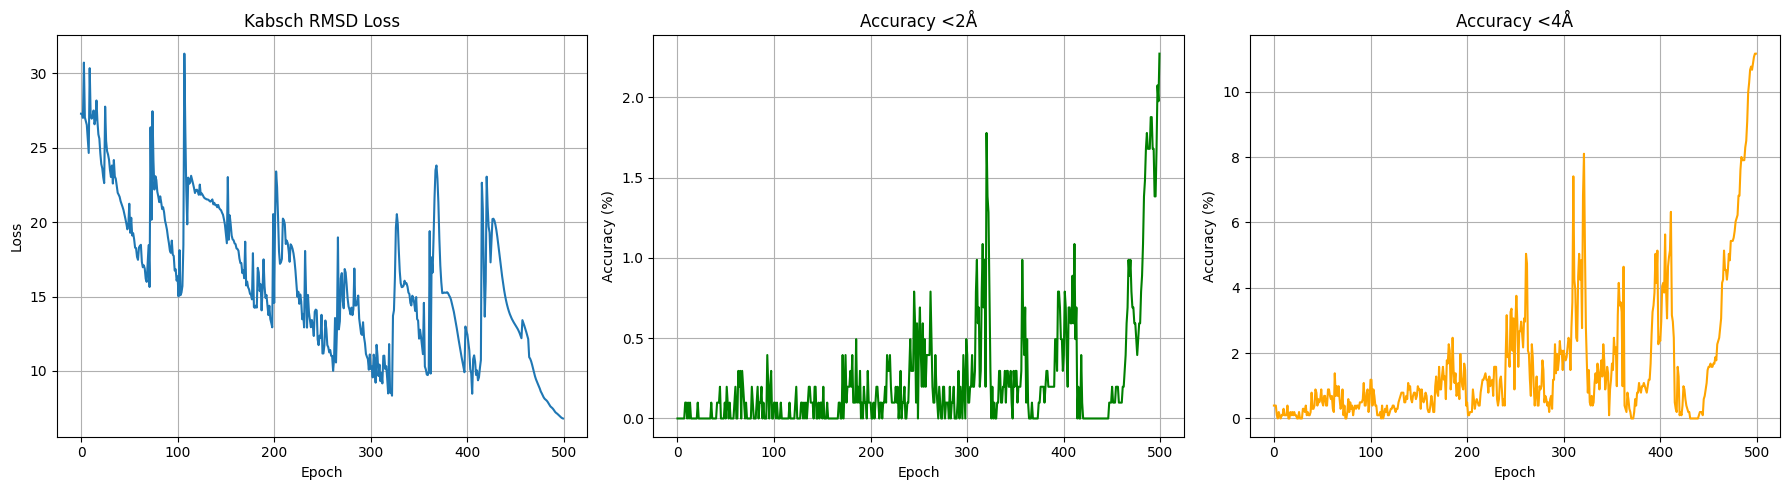

Saved plot to /content/drive/MyDrive/Protein_str/FineTuned_ESM2/plots/model_arch1024_512_256_128_lr0.01_wd0.0001_drop0.0.png

--- Running model with architecture [1024, 512, 256, 128], lr=0.01, wd=0.0001, dropout=0.2 ---
Epoch 1/500 — Loss: 27.2865 — <2Å: 0.0% — <4Å: 0.4%
Epoch 51/500 — Loss: 23.0412 — <2Å: 0.1% — <4Å: 0.2%
Epoch 101/500 — Loss: 15.0682 — <2Å: 0.5% — <4Å: 1.2%
Epoch 151/500 — Loss: 14.5198 — <2Å: 0.1% — <4Å: 1.1%
Epoch 201/500 — Loss: 22.7606 — <2Å: 0.0% — <4Å: 0.0%
Epoch 251/500 — Loss: 15.4515 — <2Å: 0.4% — <4Å: 2.1%
Epoch 301/500 — Loss: 15.6785 — <2Å: 0.3% — <4Å: 1.7%
Epoch 351/500 — Loss: 12.4510 — <2Å: 0.8% — <4Å: 2.8%
Epoch 401/500 — Loss: 10.4614 — <2Å: 0.9% — <4Å: 4.2%
Epoch 451/500 — Loss: 10.3911 — <2Å: 0.8% — <4Å: 4.6%
Epoch 500/500 — Loss: 10.6214 — <2Å: 0.7% — <4Å: 5.8%


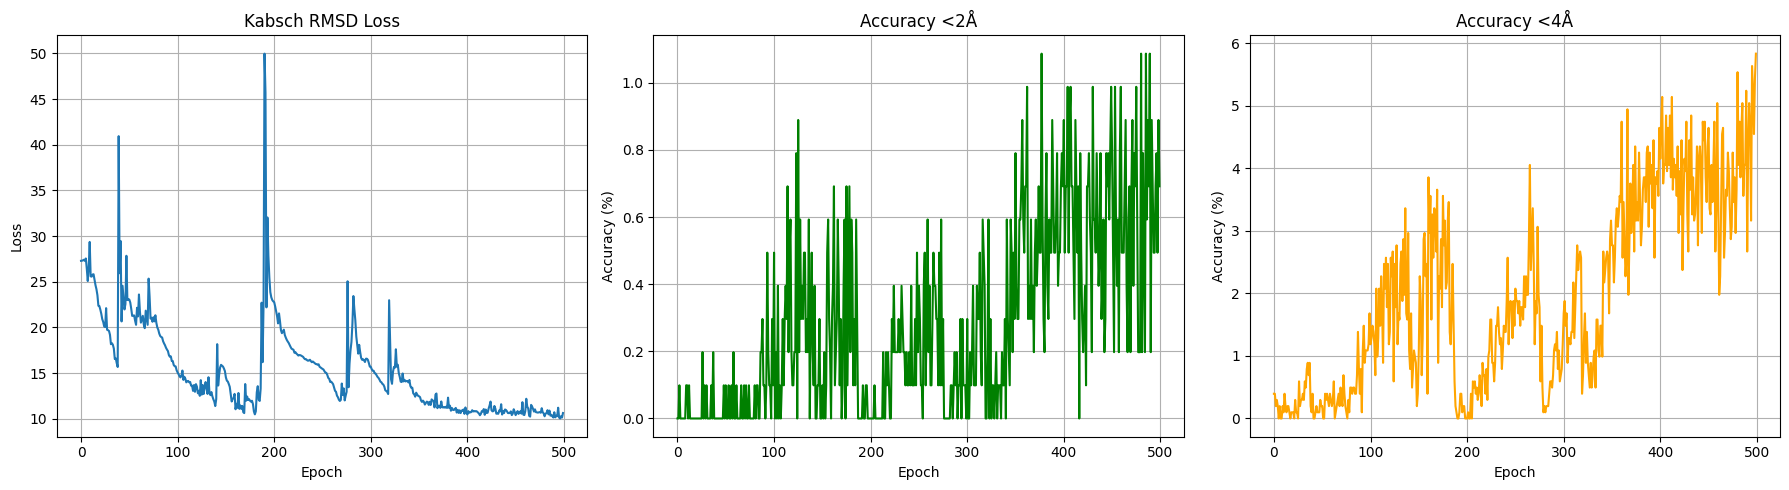

Saved plot to /content/drive/MyDrive/Protein_str/FineTuned_ESM2/plots/model_arch1024_512_256_128_lr0.01_wd0.0001_drop0.2.png

--- Running model with architecture [1024, 512, 256, 128], lr=0.001, wd=0.0, dropout=0.0 ---
Epoch 1/500 — Loss: 27.2864 — <2Å: 0.0% — <4Å: 0.4%
Epoch 51/500 — Loss: 21.5216 — <2Å: 0.1% — <4Å: 0.4%
Epoch 101/500 — Loss: 16.3240 — <2Å: 0.1% — <4Å: 1.2%
Epoch 151/500 — Loss: 16.3421 — <2Å: 0.1% — <4Å: 0.9%
Epoch 201/500 — Loss: 16.5878 — <2Å: 0.2% — <4Å: 0.7%
Epoch 251/500 — Loss: 17.6348 — <2Å: 0.1% — <4Å: 0.4%
Epoch 301/500 — Loss: 9.4374 — <2Å: 0.3% — <4Å: 2.5%
Epoch 351/500 — Loss: 10.0915 — <2Å: 0.2% — <4Å: 2.6%
Epoch 401/500 — Loss: 11.0451 — <2Å: 0.2% — <4Å: 0.8%
Epoch 451/500 — Loss: 9.3605 — <2Å: 0.0% — <4Å: 2.2%
Epoch 500/500 — Loss: 6.8135 — <2Å: 3.5% — <4Å: 14.5%


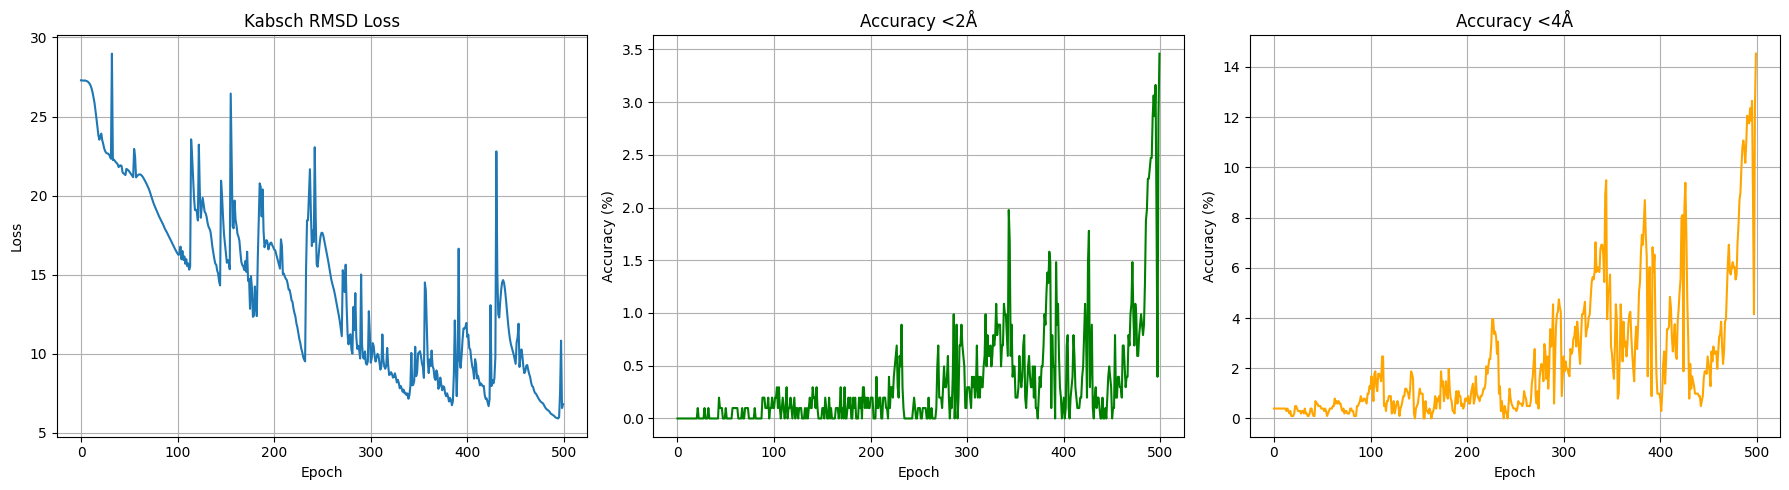

Saved plot to /content/drive/MyDrive/Protein_str/FineTuned_ESM2/plots/model_arch1024_512_256_128_lr0.001_wd0.0_drop0.0.png

--- Running model with architecture [1024, 512, 256, 128], lr=0.001, wd=0.0, dropout=0.2 ---
Epoch 1/500 — Loss: 27.2864 — <2Å: 0.0% — <4Å: 0.4%
Epoch 51/500 — Loss: 20.3863 — <2Å: 0.1% — <4Å: 0.1%
Epoch 101/500 — Loss: 16.3669 — <2Å: 0.1% — <4Å: 1.4%
Epoch 151/500 — Loss: 13.3819 — <2Å: 0.3% — <4Å: 1.9%
Epoch 201/500 — Loss: 17.1004 — <2Å: 0.0% — <4Å: 0.3%
Epoch 251/500 — Loss: 11.4979 — <2Å: 0.8% — <4Å: 3.2%
Epoch 301/500 — Loss: 9.5863 — <2Å: 0.6% — <4Å: 4.4%
Epoch 351/500 — Loss: 8.6916 — <2Å: 0.7% — <4Å: 5.7%
Epoch 401/500 — Loss: 7.8275 — <2Å: 1.4% — <4Å: 7.7%
Epoch 451/500 — Loss: 7.9300 — <2Å: 0.6% — <4Å: 6.7%
Epoch 500/500 — Loss: 7.5755 — <2Å: 0.9% — <4Å: 7.4%


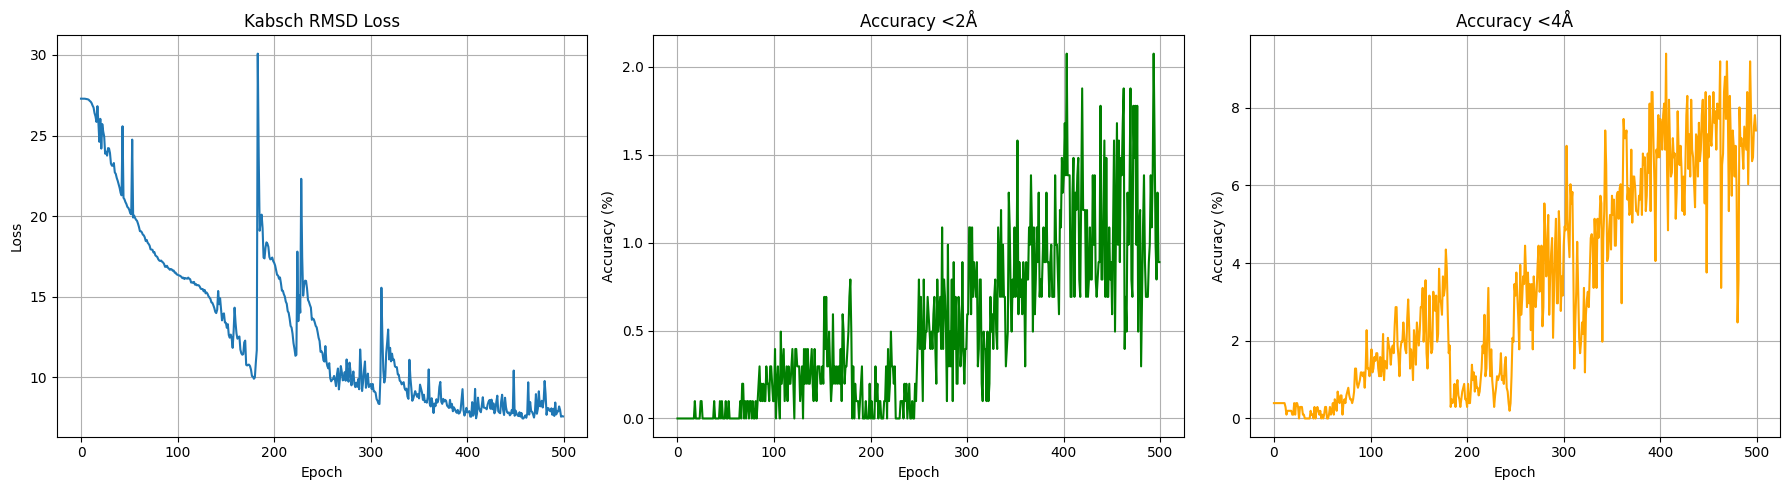

Saved plot to /content/drive/MyDrive/Protein_str/FineTuned_ESM2/plots/model_arch1024_512_256_128_lr0.001_wd0.0_drop0.2.png

--- Running model with architecture [1024, 512, 256, 128], lr=0.001, wd=0.0001, dropout=0.0 ---
Epoch 1/500 — Loss: 27.2864 — <2Å: 0.0% — <4Å: 0.4%
Epoch 51/500 — Loss: 20.2058 — <2Å: 0.0% — <4Å: 0.5%
Epoch 101/500 — Loss: 12.5678 — <2Å: 0.0% — <4Å: 0.8%
Epoch 151/500 — Loss: 11.3496 — <2Å: 0.9% — <4Å: 3.0%
Epoch 201/500 — Loss: 10.9466 — <2Å: 0.2% — <4Å: 1.2%
Epoch 251/500 — Loss: 11.0926 — <2Å: 0.1% — <4Å: 1.4%
Epoch 301/500 — Loss: 6.9169 — <2Å: 1.7% — <4Å: 7.0%
Epoch 351/500 — Loss: 17.6443 — <2Å: 0.0% — <4Å: 0.4%
Epoch 401/500 — Loss: 7.6709 — <2Å: 0.5% — <4Å: 5.1%
Epoch 451/500 — Loss: 5.3333 — <2Å: 3.1% — <4Å: 14.7%
Epoch 500/500 — Loss: 4.6810 — <2Å: 4.4% — <4Å: 19.9%


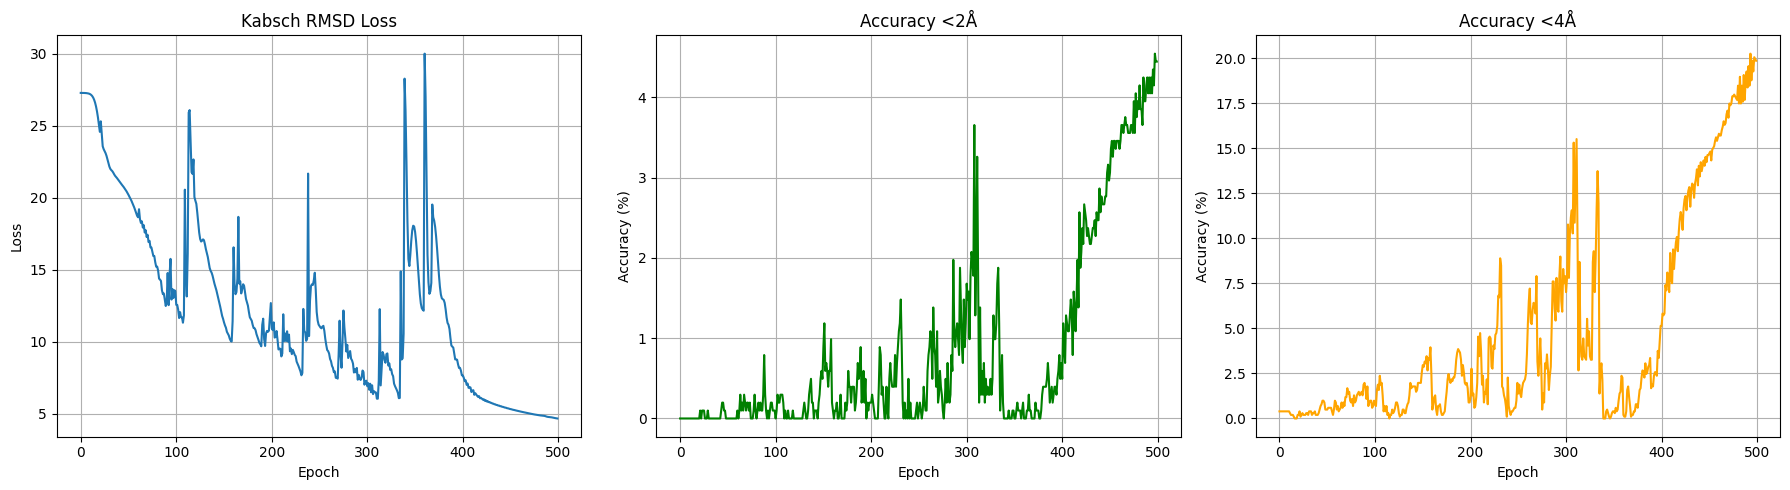

Saved plot to /content/drive/MyDrive/Protein_str/FineTuned_ESM2/plots/model_arch1024_512_256_128_lr0.001_wd0.0001_drop0.0.png

--- Running model with architecture [1024, 512, 256, 128], lr=0.001, wd=0.0001, dropout=0.2 ---
Epoch 1/500 — Loss: 27.2866 — <2Å: 0.0% — <4Å: 0.4%
Epoch 51/500 — Loss: 28.5550 — <2Å: 0.1% — <4Å: 0.4%
Epoch 101/500 — Loss: 19.3617 — <2Å: 0.0% — <4Å: 0.4%
Epoch 151/500 — Loss: 13.2299 — <2Å: 0.1% — <4Å: 1.1%
Epoch 201/500 — Loss: 12.9252 — <2Å: 0.2% — <4Å: 1.9%
Epoch 251/500 — Loss: 9.3801 — <2Å: 0.3% — <4Å: 2.6%
Epoch 301/500 — Loss: 11.4641 — <2Å: 0.6% — <4Å: 2.2%
Epoch 351/500 — Loss: 8.1110 — <2Å: 1.1% — <4Å: 5.8%
Epoch 401/500 — Loss: 8.2823 — <2Å: 0.8% — <4Å: 5.0%
Epoch 451/500 — Loss: 7.5762 — <2Å: 1.5% — <4Å: 7.5%
Epoch 500/500 — Loss: 7.2552 — <2Å: 1.5% — <4Å: 8.9%


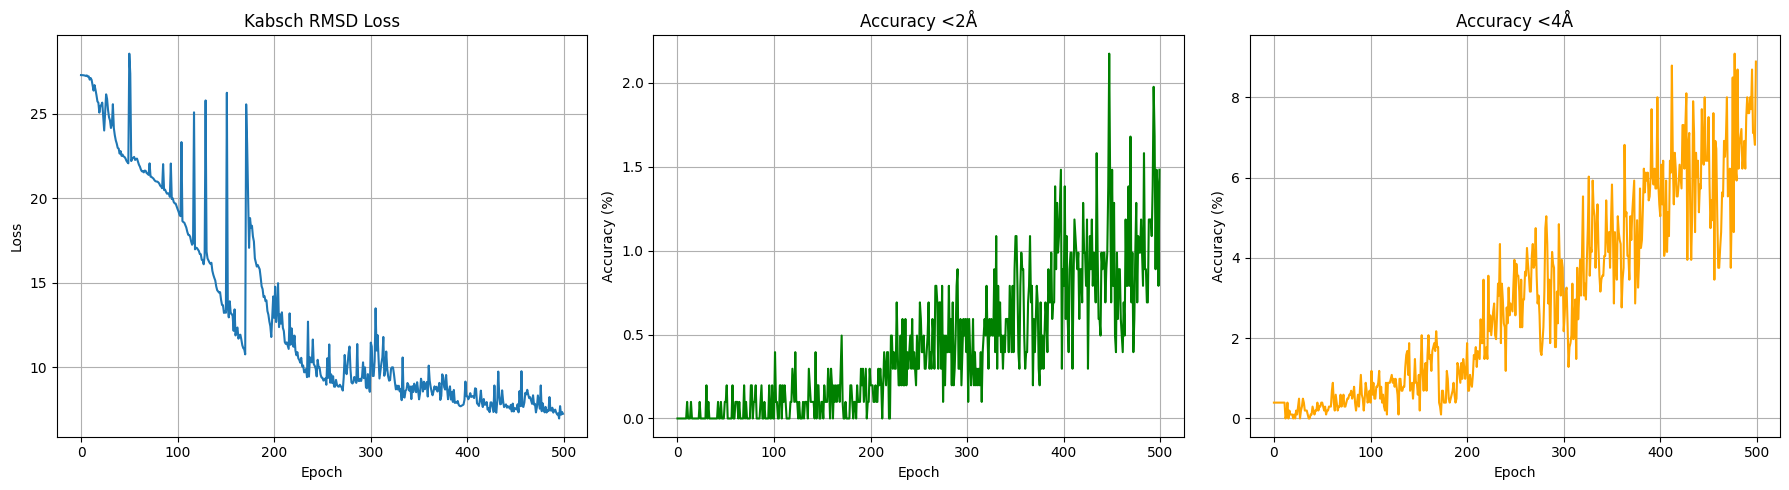

Saved plot to /content/drive/MyDrive/Protein_str/FineTuned_ESM2/plots/model_arch1024_512_256_128_lr0.001_wd0.0001_drop0.2.png

--- Running model with architecture [1024, 512, 256, 128], lr=0.0001, wd=0.0, dropout=0.0 ---
Epoch 1/500 — Loss: 27.2865 — <2Å: 0.0% — <4Å: 0.4%
Epoch 51/500 — Loss: 27.1747 — <2Å: 0.0% — <4Å: 0.4%
Epoch 101/500 — Loss: 24.1206 — <2Å: 0.0% — <4Å: 0.3%
Epoch 151/500 — Loss: 22.6797 — <2Å: 0.0% — <4Å: 0.4%
Epoch 201/500 — Loss: 23.8079 — <2Å: 0.0% — <4Å: 0.3%
Epoch 251/500 — Loss: 21.8864 — <2Å: 0.0% — <4Å: 0.3%
Epoch 301/500 — Loss: 21.2798 — <2Å: 0.1% — <4Å: 0.3%
Epoch 351/500 — Loss: 21.7510 — <2Å: 0.0% — <4Å: 0.5%
Epoch 401/500 — Loss: 20.9352 — <2Å: 0.0% — <4Å: 0.7%
Epoch 451/500 — Loss: 20.5839 — <2Å: 0.0% — <4Å: 0.7%
Epoch 500/500 — Loss: 24.5098 — <2Å: 0.0% — <4Å: 0.1%


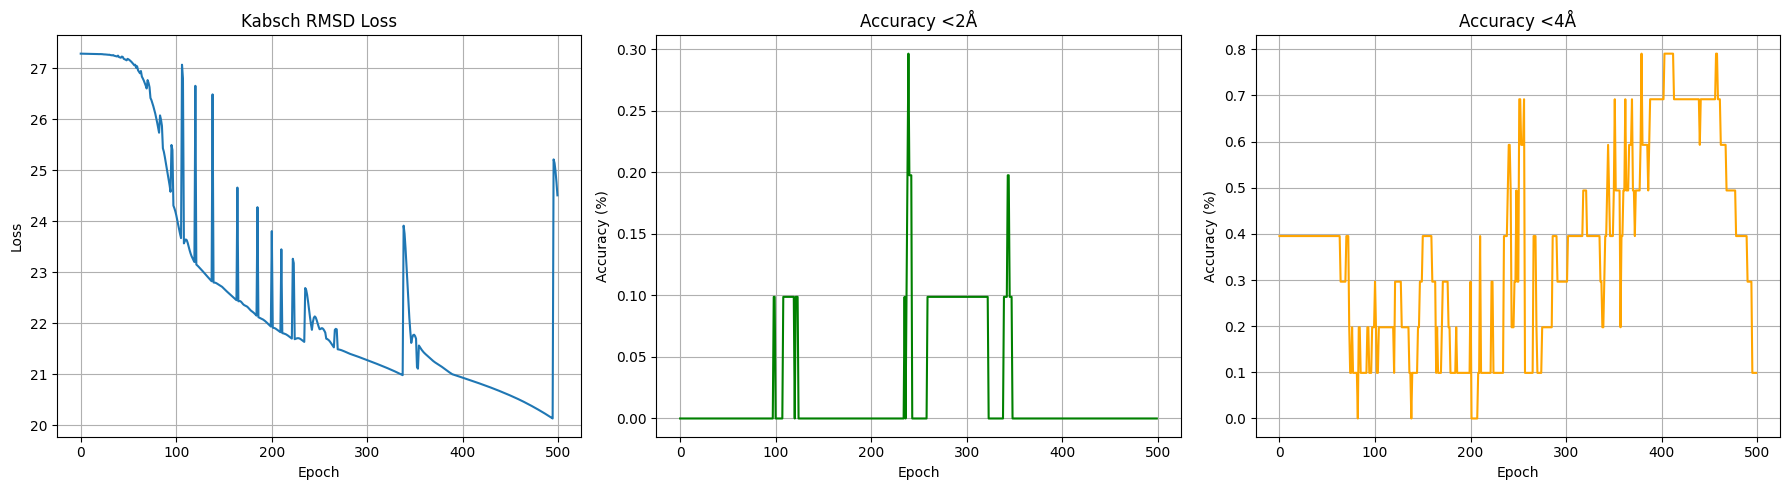

Saved plot to /content/drive/MyDrive/Protein_str/FineTuned_ESM2/plots/model_arch1024_512_256_128_lr0.0001_wd0.0_drop0.0.png

--- Running model with architecture [1024, 512, 256, 128], lr=0.0001, wd=0.0, dropout=0.2 ---
Epoch 1/500 — Loss: 27.2861 — <2Å: 0.0% — <4Å: 0.4%
Epoch 51/500 — Loss: 27.2625 — <2Å: 0.0% — <4Å: 0.4%
Epoch 101/500 — Loss: 26.1213 — <2Å: 0.0% — <4Å: 0.1%
Epoch 151/500 — Loss: 24.5538 — <2Å: 0.0% — <4Å: 0.1%
Epoch 201/500 — Loss: 23.2307 — <2Å: 0.0% — <4Å: 0.0%
Epoch 251/500 — Loss: 21.9125 — <2Å: 0.0% — <4Å: 0.1%
Epoch 301/500 — Loss: 19.5025 — <2Å: 0.0% — <4Å: 0.3%
Epoch 351/500 — Loss: 17.6298 — <2Å: 0.0% — <4Å: 0.8%
Epoch 401/500 — Loss: 16.7360 — <2Å: 0.0% — <4Å: 1.2%
Epoch 451/500 — Loss: 15.8462 — <2Å: 0.2% — <4Å: 1.5%
Epoch 500/500 — Loss: 15.0826 — <2Å: 0.5% — <4Å: 1.8%


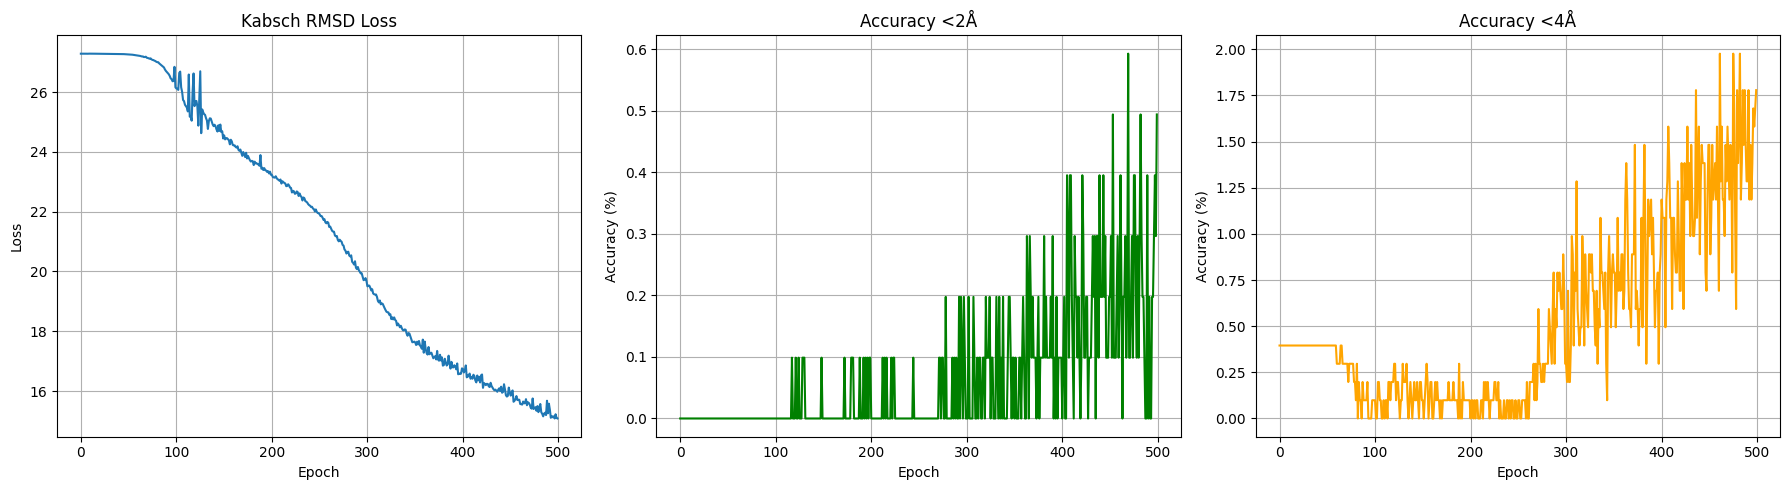

Saved plot to /content/drive/MyDrive/Protein_str/FineTuned_ESM2/plots/model_arch1024_512_256_128_lr0.0001_wd0.0_drop0.2.png

--- Running model with architecture [1024, 512, 256, 128], lr=0.0001, wd=0.0001, dropout=0.0 ---
Epoch 1/500 — Loss: 27.2863 — <2Å: 0.0% — <4Å: 0.4%
Epoch 51/500 — Loss: 27.0697 — <2Å: 0.0% — <4Å: 0.4%
Epoch 101/500 — Loss: 23.8607 — <2Å: 0.0% — <4Å: 0.3%
Epoch 151/500 — Loss: 22.2037 — <2Å: 0.1% — <4Å: 0.2%
Epoch 201/500 — Loss: 21.5494 — <2Å: 0.0% — <4Å: 0.2%
Epoch 251/500 — Loss: 21.1128 — <2Å: 0.1% — <4Å: 0.2%
Epoch 301/500 — Loss: 20.4883 — <2Å: 0.0% — <4Å: 0.4%
Epoch 351/500 — Loss: 19.7737 — <2Å: 0.1% — <4Å: 0.4%
Epoch 401/500 — Loss: 18.6600 — <2Å: 0.1% — <4Å: 0.8%
Epoch 451/500 — Loss: 17.1275 — <2Å: 0.3% — <4Å: 1.5%
Epoch 500/500 — Loss: 16.1722 — <2Å: 0.0% — <4Å: 1.3%


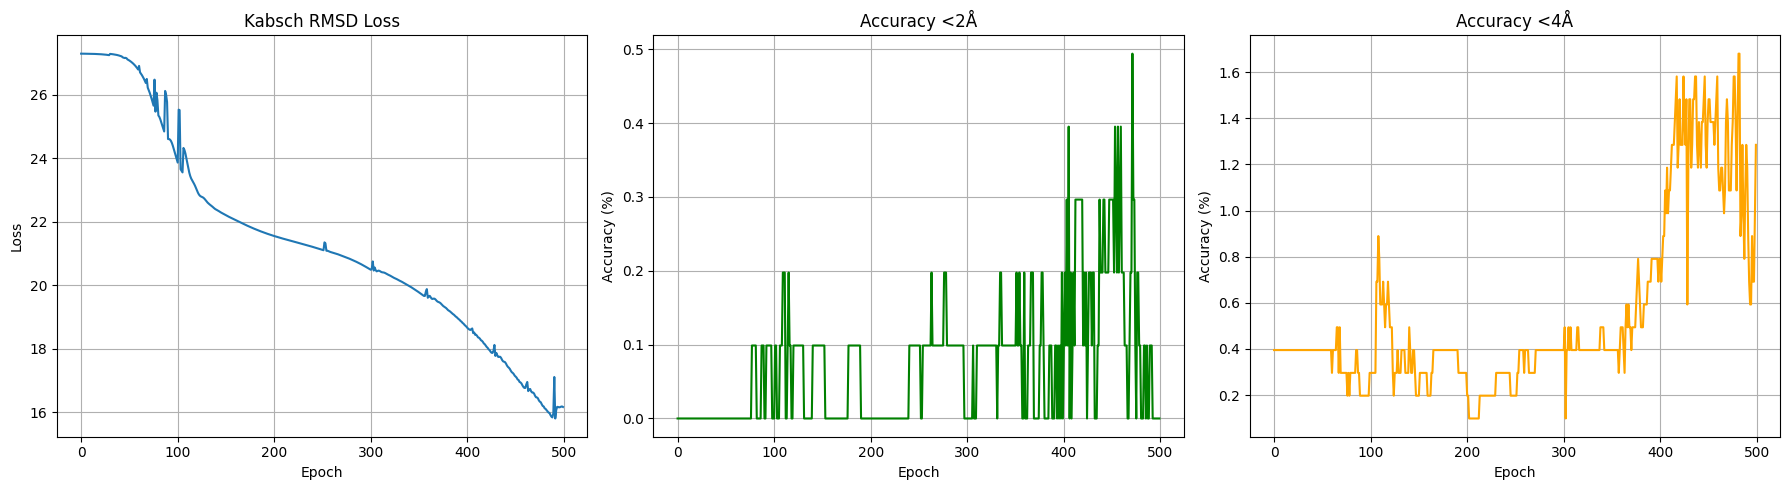

Saved plot to /content/drive/MyDrive/Protein_str/FineTuned_ESM2/plots/model_arch1024_512_256_128_lr0.0001_wd0.0001_drop0.0.png

--- Running model with architecture [1024, 512, 256, 128], lr=0.0001, wd=0.0001, dropout=0.2 ---
Epoch 1/500 — Loss: 27.2865 — <2Å: 0.0% — <4Å: 0.4%
Epoch 51/500 — Loss: 27.2484 — <2Å: 0.0% — <4Å: 0.4%
Epoch 101/500 — Loss: 25.8881 — <2Å: 0.0% — <4Å: 0.0%
Epoch 151/500 — Loss: 26.4371 — <2Å: 0.0% — <4Å: 0.3%
Epoch 201/500 — Loss: 21.9931 — <2Å: 0.1% — <4Å: 0.3%
Epoch 251/500 — Loss: 21.3920 — <2Å: 0.0% — <4Å: 0.1%
Epoch 301/500 — Loss: 20.4660 — <2Å: 0.0% — <4Å: 0.4%
Epoch 351/500 — Loss: 19.0255 — <2Å: 0.2% — <4Å: 0.6%
Epoch 401/500 — Loss: 17.6959 — <2Å: 0.0% — <4Å: 0.1%
Epoch 451/500 — Loss: 16.9393 — <2Å: 0.1% — <4Å: 0.8%
Epoch 500/500 — Loss: 16.5484 — <2Å: 0.3% — <4Å: 1.3%


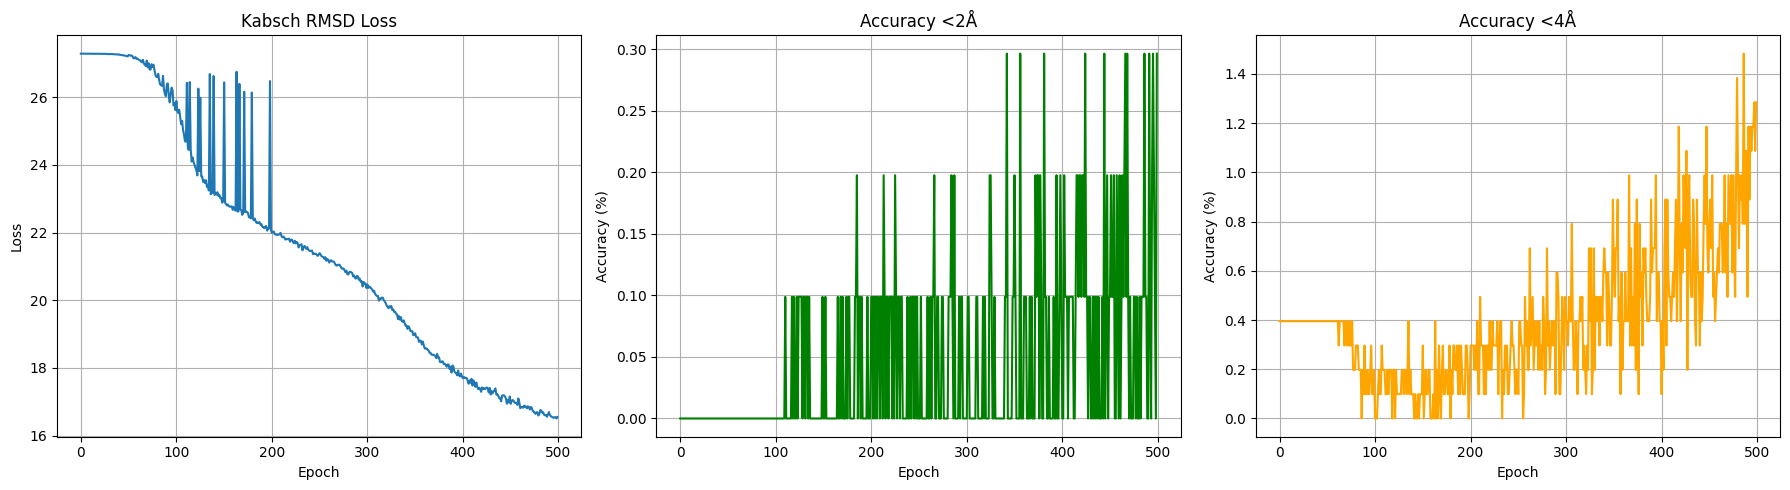

Saved plot to /content/drive/MyDrive/Protein_str/FineTuned_ESM2/plots/model_arch1024_512_256_128_lr0.0001_wd0.0001_drop0.2.png

===== Best Model =====
Architecture: [512, 256, 128]
Learning Rate: 0.01
Weight Decay: 0.0
Dropout: 0.0
Final Kabsch RMSD Loss (squared Å): 0.6437
Final RMSD (Å): 0.80
Accuracy <2Å: 95.06%
Accuracy <4Å: 99.51%


In [ ]:
import os
import copy
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import math
from transformers import AutoTokenizer, EsmModel


# Set random seeds for reproducibility
import random
import numpy as np

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


# Kabsch functions with correction

def kabsch_rmsd(P, Q):
    """
    Compute the RMSD after aligning P onto Q using Kabsch algorithm.
    Both P and Q are tensors of shape [B, N, 3].
    """
    P, Q = P.float(), Q.float()
    P_centered = P - P.mean(1, keepdim=True)
    Q_centered = Q - Q.mean(1, keepdim=True)
    H = torch.matmul(P_centered.transpose(1, 2), Q_centered)
    U, _, Vt = torch.svd(H)
    d = torch.det(torch.matmul(Vt.transpose(1, 2), U.transpose(1, 2))).unsqueeze(-1).unsqueeze(-1)
    Vt_adj = torch.where(d < 0, torch.cat([Vt[:, :, :-1], -Vt[:, :, -1:]], dim=-1), Vt)
    R = torch.matmul(Vt_adj.transpose(1, 2), U.transpose(1, 2))
    aligned = torch.matmul(P_centered, R)
    return torch.sqrt(torch.mean((aligned - Q_centered) ** 2, dim=[1,2])).mean()

def kabsch_align(P, Q):
    """
    Align P onto Q using the Kabsch algorithm.
    Returns the aligned coordinates with target translation restored.
    Both P and Q are tensors of shape [B, N, 3].
    """
    P, Q = P.float(), Q.float()
    P_centered = P - P.mean(1, keepdim=True)
    Q_centered = Q - Q.mean(1, keepdim=True)
    H = torch.matmul(P_centered.transpose(1, 2), Q_centered)
    U, _, Vt = torch.svd(H)
    d = torch.det(torch.matmul(Vt.transpose(1, 2), U.transpose(1, 2))).unsqueeze(-1).unsqueeze(-1)
    Vt_adj = torch.where(d < 0, torch.cat([Vt[:, :, :-1], -Vt[:, :, -1:]], dim=-1), Vt)
    R = torch.matmul(Vt_adj.transpose(1, 2), U.transpose(1, 2))
    aligned = torch.matmul(P_centered, R)
    return aligned + Q.mean(1, keepdim=True)

def rmsd_accuracy(pred, target, thresholds=(2.0, 4.0)):
    """
    Compute the percentage of residues whose distances (after alignment) are below the threshold values.
    """
    pred_aligned = kabsch_align(pred, target)
    dists = torch.norm(pred_aligned - target, dim=2).squeeze(0)
    return {f"<{t}Å": (dists < t).float().mean().item() * 100 for t in thresholds}


# Define a flexible CoordRegressor that accepts architecture and dropout rate.
class CoordRegressor(nn.Module):
    def __init__(self, d_model, architecture, dropout_rate=0.0):
        super().__init__()
        layers = []
        in_dim = d_model
        for hidden in architecture:
            layers.append(nn.Linear(in_dim, hidden))
            layers.append(nn.ReLU())
            if dropout_rate > 0:
                layers.append(nn.Dropout(dropout_rate))
            in_dim = hidden
        layers.append(nn.Linear(in_dim, 3))
        self.mlp = nn.Sequential(*layers)
    def forward(self, x):
        return self.mlp(x)


# Load the ESM2 model and tokenizer
model_id = "facebook/esm2_t12_35M_UR50D"
tokenizer = AutoTokenizer.from_pretrained(model_id)
esm = EsmModel.from_pretrained(model_id).eval().cuda()
esm.train()  # Enable gradients for fine-tuning

# Save the initial state dict of esm so that each run starts with the same parameters.
initial_esm_state = copy.deepcopy(esm.state_dict())


# Hyperparameter candidates

architectures = [
    [128],
    [256, 128],
    [512, 256, 128],
    [1024, 512, 256, 128]
]
learning_rates = [1e-2, 1e-3, 1e-4]
weight_decays = [0.0, 1e-4]
dropout_rates = [0.0, 0.2]

# Training hyperparameter (for tuning, you might use fewer epochs)
n_epochs = 500

# Folder to save plots
plots_dir = "/content/drive/MyDrive/Protein_str/FineTuned_ESM2/plots"
os.makedirs(plots_dir, exist_ok=True)

# To store the results for all runs
results = []


# Hyperparameter tuning loop

# Loop over architecture
for arch in architectures:
    # Loop over learning rate
    for lr in learning_rates:
        # Loop over weight decay
        for wd in weight_decays:
            # Loop over dropout rate
            for drop in dropout_rates:

                print(f"\n--- Running model with architecture {arch}, lr={lr}, wd={wd}, dropout={drop} ---")

                # Reset esm to initial pretrained state
                esm.load_state_dict(initial_esm_state)
                esm.train()  # Ensure esm is in training mode

                # Initialize a new regressor for the current hyperparameters
                regressor = CoordRegressor(d_model=esm.config.hidden_size, architecture=arch, dropout_rate=drop).cuda()

                # Setup optimizer for both esm and regressor with given lr and weight decay
                optimizer = optim.Adam(list(esm.parameters()) + list(regressor.parameters()), lr=lr, weight_decay=wd)

                # setup a learning rate scheduler (ReduceLROnPlateau here)
                scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=50, verbose=False)

                # Containers to record training curves
                losses, acc_2A, acc_4A = [], [], []

                # Training loop
                for epoch in range(n_epochs):
                    optimizer.zero_grad()
                    esm.train()
                    regressor.train()

                    # Extract embeddings; ensure `inputs` and `min_len` are pre-defined.
                    with torch.no_grad():
                        embedding = esm(**inputs).last_hidden_state[:, :min_len, :].float()

                    pred_coords = regressor(embedding)  # [1, N, 3]
                    loss = kabsch_rmsd(pred_coords, ref_coords)

                    loss.backward()
                    optimizer.step()
                    scheduler.step(loss)

                    with torch.no_grad():
                        accs = rmsd_accuracy(pred_coords, ref_coords)

                    losses.append(loss.item())
                    acc_2A.append(accs["<2.0Å"])
                    acc_4A.append(accs["<4.0Å"])

                    if epoch % 50 == 0 or epoch == n_epochs - 1:
                        print(f"Epoch {epoch+1}/{n_epochs} — Loss: {loss.item():.4f} — <2Å: {accs['<2.0Å']:.1f}% — <4Å: {accs['<4.0Å']:.1f}%")

                final_loss = losses[-1]
                final_rmsd = math.sqrt(final_loss)
                final_acc2 = acc_2A[-1]
                final_acc4 = acc_4A[-1]

                run_result = {
                    "architecture": arch,
                    "lr": lr,
                    "wd": wd,
                    "dropout": drop,
                    "final_loss": final_loss,
                    "final_rmsd": final_rmsd,
                    "acc_<2Å": final_acc2,
                    "acc_<4Å": final_acc4,
                    "losses": losses,
                    "acc2": acc_2A,
                    "acc4": acc_4A,
                }
                results.append(run_result)

                # Save training curves plot for this run
                arch_str = "_".join(map(str, arch))
                plot_filename = os.path.join(plots_dir, f"model_arch{arch_str}_lr{lr}_wd{wd}_drop{drop}.png")
                fig, axs = plt.subplots(1, 3, figsize=(18, 5))
                axs[0].plot(losses)
                axs[0].set_title("Kabsch RMSD Loss")
                axs[0].set_xlabel("Epoch")
                axs[0].set_ylabel("Loss")
                axs[0].grid(True)

                axs[1].plot(acc_2A, color='green')
                axs[1].set_title("Accuracy <2Å")
                axs[1].set_xlabel("Epoch")
                axs[1].set_ylabel("Accuracy (%)")
                axs[1].grid(True)

                axs[2].plot(acc_4A, color='orange')
                axs[2].set_title("Accuracy <4Å")
                axs[2].set_xlabel("Epoch")
                axs[2].set_ylabel("Accuracy (%)")
                axs[2].grid(True)

                plt.tight_layout()
                plt.savefig(plot_filename)
                plt.show()
                plt.close(fig)

                print(f"Saved plot to {plot_filename}")


# Determine the best run based on final RMSD (lowest)
best_run = min(results, key=lambda r: r["final_rmsd"])

print("\n===== Best Model =====")
print(f"Architecture: {best_run['architecture']}")
print(f"Learning Rate: {best_run['lr']}")
print(f"Weight Decay: {best_run['wd']}")
print(f"Dropout: {best_run['dropout']}")
print(f"Final Kabsch RMSD Loss (squared Å): {best_run['final_loss']:.4f}")
print(f"Final RMSD (Å): {best_run['final_rmsd']:.2f}")
print(f"Accuracy <2Å: {best_run['acc_<2Å']:.2f}%")
print(f"Accuracy <4Å: {best_run['acc_<4Å']:.2f}%")


Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t12_35M_UR50D and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



===== Training with 1000 epochs =====
Epoch 1/1000 — Loss: 27.2862 — <2Å: 0.00% — <4Å: 0.40%
Epoch 51/1000 — Loss: 17.5894 — <2Å: 0.30% — <4Å: 0.89%
Epoch 101/1000 — Loss: 17.1616 — <2Å: 0.20% — <4Å: 0.40%
Epoch 151/1000 — Loss: 17.3298 — <2Å: 0.20% — <4Å: 0.69%
Epoch 201/1000 — Loss: 14.3601 — <2Å: 0.10% — <4Å: 0.79%
Epoch 251/1000 — Loss: 8.2481 — <2Å: 0.59% — <4Å: 5.14%
Epoch 301/1000 — Loss: 9.7415 — <2Å: 0.40% — <4Å: 3.36%
Epoch 351/1000 — Loss: 13.5525 — <2Å: 0.20% — <4Å: 1.09%
Epoch 401/1000 — Loss: 7.5259 — <2Å: 2.87% — <4Å: 9.78%
Epoch 451/1000 — Loss: 6.0225 — <2Å: 4.05% — <4Å: 17.98%
Epoch 501/1000 — Loss: 5.2714 — <2Å: 3.46% — <4Å: 16.30%
Epoch 551/1000 — Loss: 5.2957 — <2Å: 4.15% — <4Å: 17.29%
Epoch 601/1000 — Loss: 10.9254 — <2Å: 0.59% — <4Å: 3.06%
Epoch 651/1000 — Loss: 4.2709 — <2Å: 3.75% — <4Å: 23.02%
Epoch 701/1000 — Loss: 4.2854 — <2Å: 4.05% — <4Å: 25.40%
Epoch 751/1000 — Loss: 4.6935 — <2Å: 4.45% — <4Å: 21.25%
Epoch 801/1000 — Loss: 5.1387 — <2Å: 4.55% — <4Å: 22.53

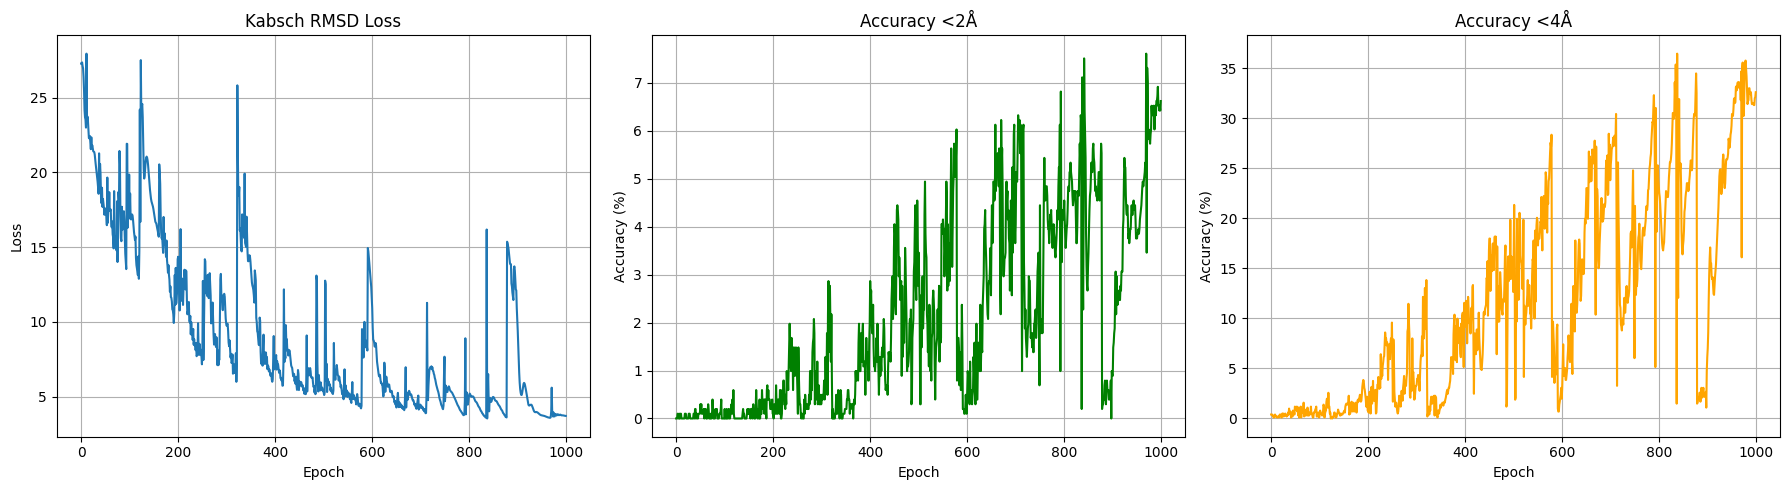

Saved plot to /content/drive/MyDrive/Protein_str/FineTuned_ESM2/plots/model_1000epochs.png

===== Training with 1500 epochs =====
Epoch 1/1500 — Loss: 27.2866 — <2Å: 0.00% — <4Å: 0.40%
Epoch 51/1500 — Loss: 20.0086 — <2Å: 0.00% — <4Å: 0.10%
Epoch 101/1500 — Loss: 18.9457 — <2Å: 0.00% — <4Å: 0.69%
Epoch 151/1500 — Loss: 15.4150 — <2Å: 0.40% — <4Å: 2.57%
Epoch 201/1500 — Loss: 9.0965 — <2Å: 0.79% — <4Å: 8.40%
Epoch 251/1500 — Loss: 5.6695 — <2Å: 5.04% — <4Å: 19.57%
Epoch 301/1500 — Loss: 4.9496 — <2Å: 4.45% — <4Å: 21.15%
Epoch 351/1500 — Loss: 3.5001 — <2Å: 12.75% — <4Å: 41.90%
Epoch 401/1500 — Loss: 3.1197 — <2Å: 14.43% — <4Å: 49.90%
Epoch 451/1500 — Loss: 2.6388 — <2Å: 17.39% — <4Å: 58.89%
Epoch 501/1500 — Loss: 2.4615 — <2Å: 18.28% — <4Å: 62.55%
Epoch 551/1500 — Loss: 1.8682 — <2Å: 36.76% — <4Å: 78.85%
Epoch 601/1500 — Loss: 1.8488 — <2Å: 33.60% — <4Å: 78.66%
Epoch 651/1500 — Loss: 1.3616 — <2Å: 58.30% — <4Å: 92.59%
Epoch 701/1500 — Loss: 0.8500 — <2Å: 86.17% — <4Å: 98.91%
Epoch 751/1

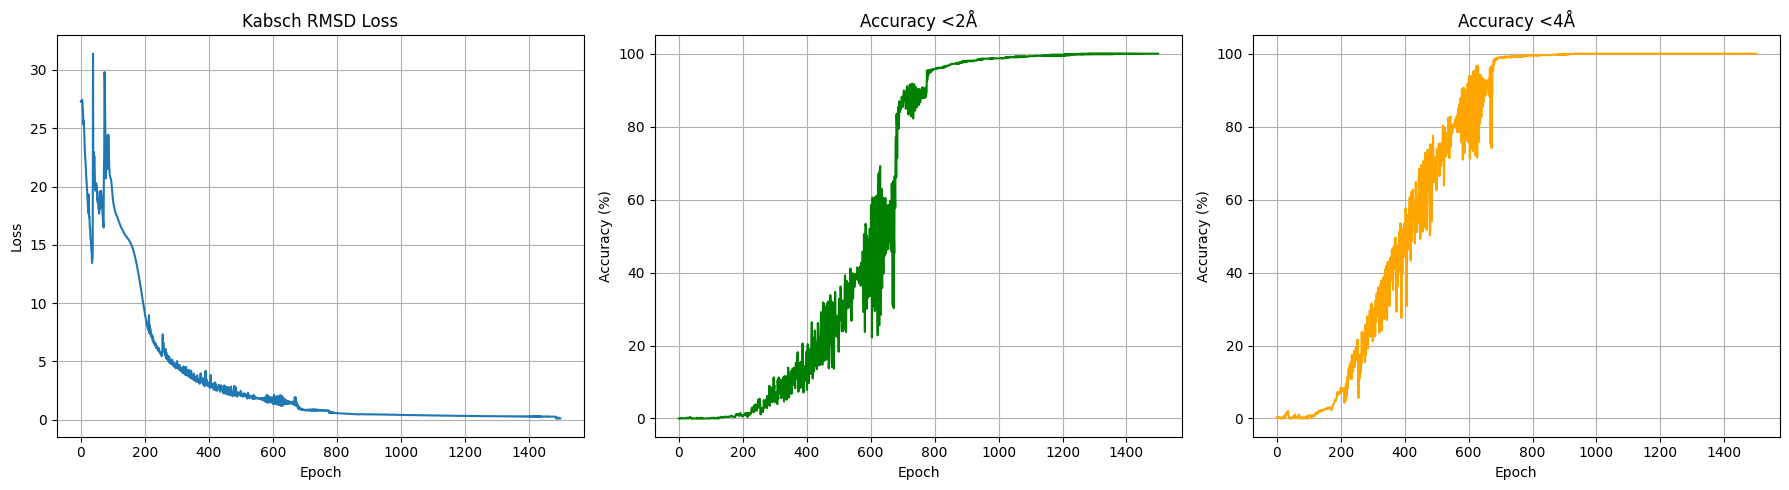

Saved plot to /content/drive/MyDrive/Protein_str/FineTuned_ESM2/plots/model_1500epochs.png

===== Training with 2000 epochs =====
Epoch 1/2000 — Loss: 27.2867 — <2Å: 0.00% — <4Å: 0.40%
Epoch 51/2000 — Loss: 20.6989 — <2Å: 0.00% — <4Å: 0.40%
Epoch 101/2000 — Loss: 25.9623 — <2Å: 0.00% — <4Å: 0.10%
Epoch 151/2000 — Loss: 15.6321 — <2Å: 0.10% — <4Å: 0.89%
Epoch 201/2000 — Loss: 9.6208 — <2Å: 0.40% — <4Å: 2.67%
Epoch 251/2000 — Loss: 14.9379 — <2Å: 0.30% — <4Å: 1.28%
Epoch 301/2000 — Loss: 37.2626 — <2Å: 0.00% — <4Å: 0.00%
Epoch 351/2000 — Loss: 6.6560 — <2Å: 1.38% — <4Å: 8.60%
Epoch 401/2000 — Loss: 4.6943 — <2Å: 6.13% — <4Å: 27.57%
Epoch 451/2000 — Loss: 9.0589 — <2Å: 0.99% — <4Å: 6.03%
Epoch 501/2000 — Loss: 4.0052 — <2Å: 8.00% — <4Å: 32.61%
Epoch 551/2000 — Loss: 4.5296 — <2Å: 2.47% — <4Å: 20.75%
Epoch 601/2000 — Loss: 4.3795 — <2Å: 2.57% — <4Å: 20.65%
Epoch 651/2000 — Loss: 3.3363 — <2Å: 16.21% — <4Å: 43.87%
Epoch 701/2000 — Loss: 4.2205 — <2Å: 6.03% — <4Å: 25.69%
Epoch 751/2000 — Los

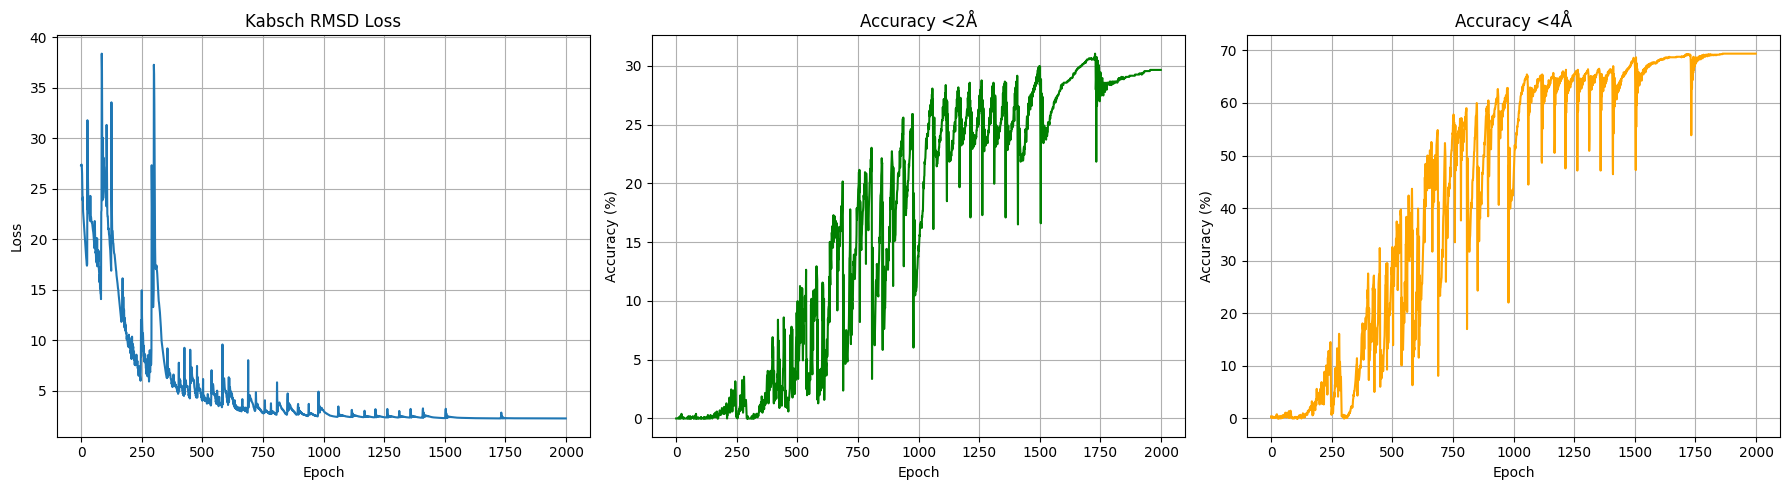

Saved plot to /content/drive/MyDrive/Protein_str/FineTuned_ESM2/plots/model_2000epochs.png

===== Training with 2500 epochs =====
Epoch 1/2500 — Loss: 27.2865 — <2Å: 0.00% — <4Å: 0.40%
Epoch 51/2500 — Loss: 21.3896 — <2Å: 0.10% — <4Å: 0.20%
Epoch 101/2500 — Loss: 22.6899 — <2Å: 0.20% — <4Å: 0.59%
Epoch 151/2500 — Loss: 16.9495 — <2Å: 0.10% — <4Å: 0.69%
Epoch 201/2500 — Loss: 9.5660 — <2Å: 0.00% — <4Å: 3.06%
Epoch 251/2500 — Loss: 8.5947 — <2Å: 1.19% — <4Å: 6.13%
Epoch 301/2500 — Loss: 9.8056 — <2Å: 0.40% — <4Å: 3.26%
Epoch 351/2500 — Loss: 7.4580 — <2Å: 0.99% — <4Å: 6.23%
Epoch 401/2500 — Loss: 7.4206 — <2Å: 0.30% — <4Å: 5.04%
Epoch 451/2500 — Loss: 5.5296 — <2Å: 2.37% — <4Å: 15.51%
Epoch 501/2500 — Loss: 5.8238 — <2Å: 2.77% — <4Å: 11.56%
Epoch 551/2500 — Loss: 5.4122 — <2Å: 1.38% — <4Å: 13.04%
Epoch 601/2500 — Loss: 7.7729 — <2Å: 0.79% — <4Å: 6.52%
Epoch 651/2500 — Loss: 5.5511 — <2Å: 1.38% — <4Å: 10.08%
Epoch 701/2500 — Loss: 5.2848 — <2Å: 2.47% — <4Å: 12.06%
Epoch 751/2500 — Loss: 5

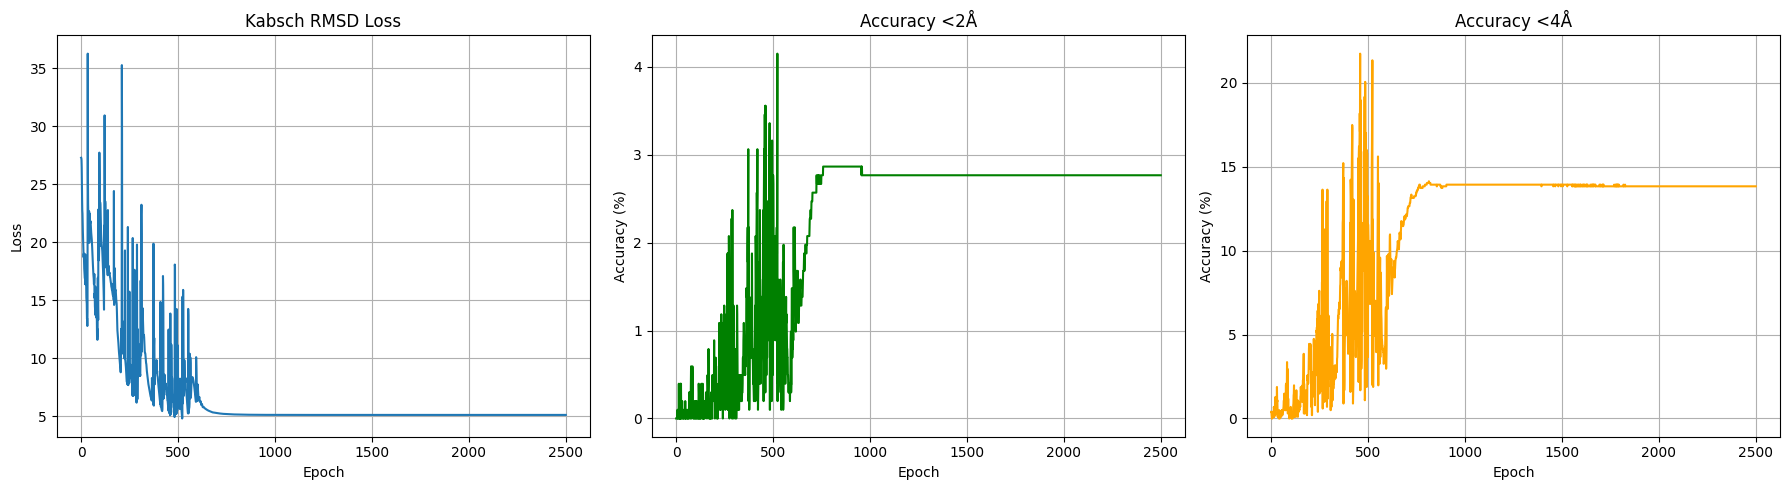

Saved plot to /content/drive/MyDrive/Protein_str/FineTuned_ESM2/plots/model_2500epochs.png

===== Training with 3000 epochs =====
Epoch 1/3000 — Loss: 27.2866 — <2Å: 0.00% — <4Å: 0.40%
Epoch 51/3000 — Loss: 11.0551 — <2Å: 0.30% — <4Å: 1.78%
Epoch 101/3000 — Loss: 11.2689 — <2Å: 0.40% — <4Å: 1.48%
Epoch 151/3000 — Loss: 6.5500 — <2Å: 0.89% — <4Å: 8.20%
Epoch 201/3000 — Loss: 15.1974 — <2Å: 0.20% — <4Å: 1.68%
Epoch 251/3000 — Loss: 10.6646 — <2Å: 0.40% — <4Å: 3.95%
Epoch 301/3000 — Loss: 8.0908 — <2Å: 0.00% — <4Å: 2.77%
Epoch 351/3000 — Loss: 4.8091 — <2Å: 4.25% — <4Å: 22.23%
Epoch 401/3000 — Loss: 3.1416 — <2Å: 17.98% — <4Å: 49.51%
Epoch 451/3000 — Loss: 23.0133 — <2Å: 0.00% — <4Å: 0.00%
Epoch 501/3000 — Loss: 3.2599 — <2Å: 11.56% — <4Å: 44.57%
Epoch 551/3000 — Loss: 3.1523 — <2Å: 13.44% — <4Å: 45.75%
Epoch 601/3000 — Loss: 2.3086 — <2Å: 29.55% — <4Å: 68.48%
Epoch 651/3000 — Loss: 2.2342 — <2Å: 29.55% — <4Å: 69.76%
Epoch 701/3000 — Loss: 2.2677 — <2Å: 28.95% — <4Å: 68.18%
Epoch 751/3000

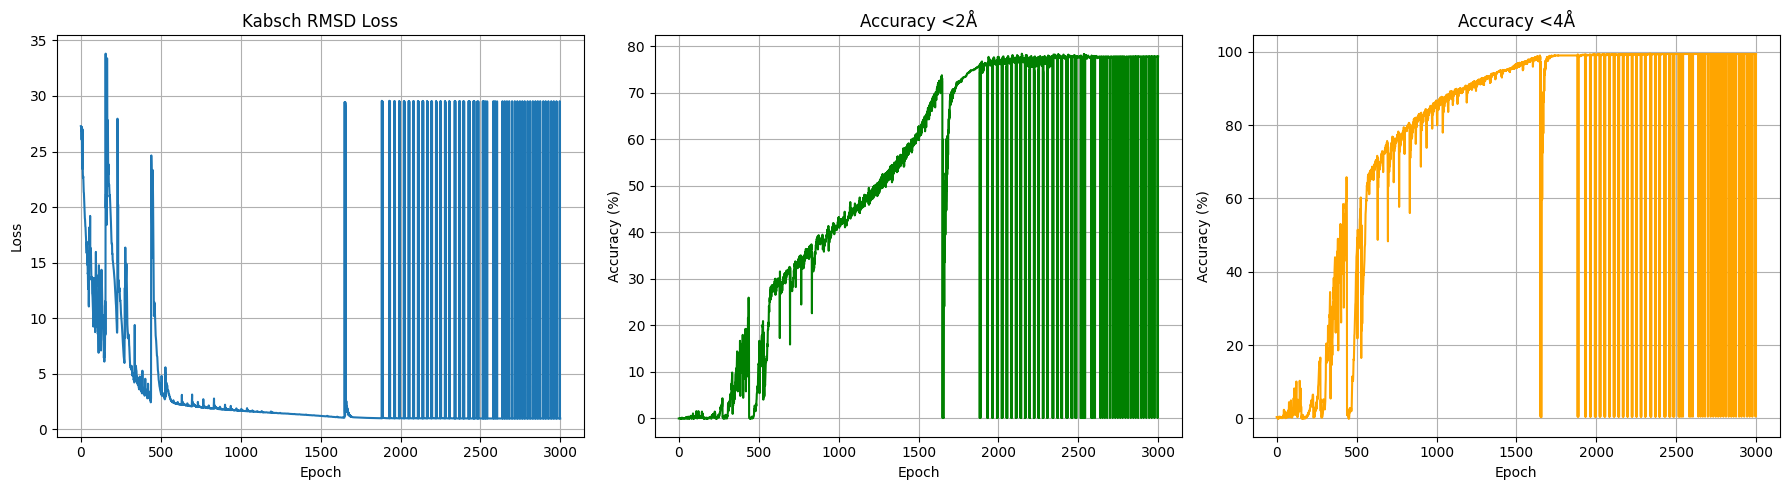

Saved plot to /content/drive/MyDrive/Protein_str/FineTuned_ESM2/plots/model_3000epochs.png

===== Training with 3500 epochs =====
Epoch 1/3500 — Loss: 27.2859 — <2Å: 0.00% — <4Å: 0.40%
Epoch 51/3500 — Loss: 20.6554 — <2Å: 0.00% — <4Å: 0.00%
Epoch 101/3500 — Loss: 15.7113 — <2Å: 0.00% — <4Å: 0.49%
Epoch 151/3500 — Loss: 15.4556 — <2Å: 0.30% — <4Å: 1.09%
Epoch 201/3500 — Loss: 21.1431 — <2Å: 0.10% — <4Å: 0.49%
Epoch 251/3500 — Loss: 16.9631 — <2Å: 0.00% — <4Å: 0.69%
Epoch 301/3500 — Loss: 14.3818 — <2Å: 0.10% — <4Å: 1.58%
Epoch 351/3500 — Loss: 12.4376 — <2Å: 0.49% — <4Å: 2.37%
Epoch 401/3500 — Loss: 11.2195 — <2Å: 0.40% — <4Å: 3.75%
Epoch 451/3500 — Loss: 10.5501 — <2Å: 0.30% — <4Å: 3.75%
Epoch 501/3500 — Loss: 10.1362 — <2Å: 0.40% — <4Å: 3.66%
Epoch 551/3500 — Loss: 9.7153 — <2Å: 0.49% — <4Å: 4.25%
Epoch 601/3500 — Loss: 9.2914 — <2Å: 0.49% — <4Å: 4.45%
Epoch 651/3500 — Loss: 8.8687 — <2Å: 0.49% — <4Å: 5.24%
Epoch 701/3500 — Loss: 8.4542 — <2Å: 1.09% — <4Å: 6.13%
Epoch 751/3500 — Loss:

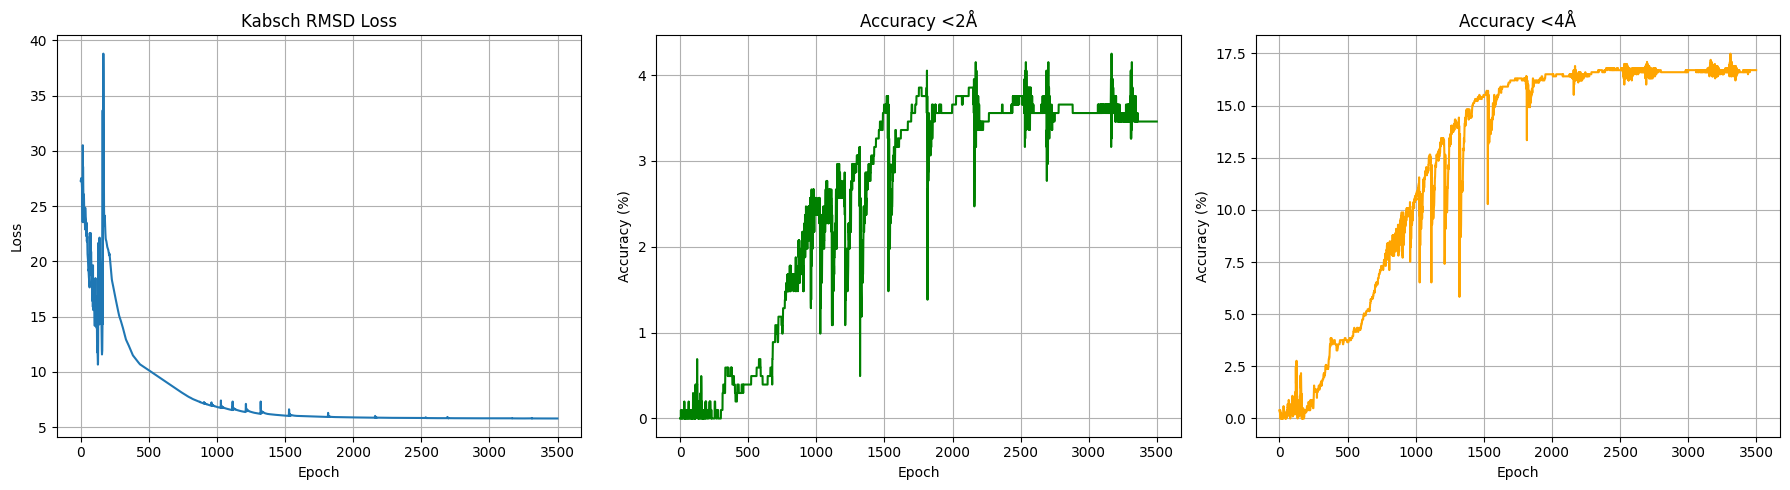

Saved plot to /content/drive/MyDrive/Protein_str/FineTuned_ESM2/plots/model_3500epochs.png

===== Best Run Overall =====
Total Epochs: 1500
Final Kabsch RMSD Loss (squared Å): 0.1009
Final RMSD (Å): 0.32
Accuracy <2Å: 100.00%
Accuracy <4Å: 100.00%
Best plot saved at: /content/drive/MyDrive/Protein_str/FineTuned_ESM2/plots/model_1500epochs.png

===== Summary of All Runs =====
Epochs: 1000, Final RMSD (Å): 1.93, Accuracy <2Å: 6.62%, Accuracy <4Å: 32.61%
Epochs: 1500, Final RMSD (Å): 0.32, Accuracy <2Å: 100.00%, Accuracy <4Å: 100.00%
Epochs: 2000, Final RMSD (Å): 1.50, Accuracy <2Å: 29.64%, Accuracy <4Å: 69.37%
Epochs: 2500, Final RMSD (Å): 2.26, Accuracy <2Å: 2.77%, Accuracy <4Å: 13.83%
Epochs: 3000, Final RMSD (Å): 0.99, Accuracy <2Å: 77.87%, Accuracy <4Å: 99.41%
Epochs: 3500, Final RMSD (Å): 2.40, Accuracy <2Å: 3.46%, Accuracy <4Å: 16.70%


In [ ]:
import os
import copy
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import math
from transformers import AutoTokenizer, EsmModel


# Set random seeds for reproducibility
import random
import numpy as np

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


# Kabsch functions with correction

def kabsch_rmsd(P, Q):
    """
    Compute the RMSD after aligning P onto Q using Kabsch algorithm.
    Both P and Q are tensors of shape [B, N, 3].
    """
    P, Q = P.float(), Q.float()
    P_centered = P - P.mean(1, keepdim=True)
    Q_centered = Q - Q.mean(1, keepdim=True)
    H = torch.matmul(P_centered.transpose(1, 2), Q_centered)
    U, _, Vt = torch.svd(H)
    d = torch.det(torch.matmul(Vt.transpose(1, 2), U.transpose(1, 2))).unsqueeze(-1).unsqueeze(-1)
    # Adjust for reflection if necessary
    Vt_adj = torch.where(d < 0, torch.cat([Vt[:, :, :-1], -Vt[:, :, -1:]], dim=-1), Vt)
    R = torch.matmul(Vt_adj.transpose(1, 2), U.transpose(1, 2))
    aligned = torch.matmul(P_centered, R)
    return torch.sqrt(torch.mean((aligned - Q_centered) ** 2, dim=[1,2])).mean()

def kabsch_align(P, Q):
    """
    Align P onto Q using the Kabsch algorithm.
    Returns the aligned coordinates with target translation restored.
    Both P and Q are tensors of shape [B, N, 3].
    """
    P, Q = P.float(), Q.float()
    P_centered = P - P.mean(1, keepdim=True)
    Q_centered = Q - Q.mean(1, keepdim=True)
    H = torch.matmul(P_centered.transpose(1, 2), Q_centered)
    U, _, Vt = torch.svd(H)
    d = torch.det(torch.matmul(Vt.transpose(1, 2), U.transpose(1, 2))).unsqueeze(-1).unsqueeze(-1)
    Vt_adj = torch.where(d < 0, torch.cat([Vt[:, :, :-1], -Vt[:, :, -1:]], dim=-1), Vt)
    R = torch.matmul(Vt_adj.transpose(1, 2), U.transpose(1, 2))
    aligned = torch.matmul(P_centered, R)
    return aligned + Q.mean(1, keepdim=True)

def rmsd_accuracy(pred, target, thresholds=(2.0, 4.0)):
    """
    Compute the percentage of residues whose distances (after alignment) are below the threshold values.
    """
    pred_aligned = kabsch_align(pred, target)
    dists = torch.norm(pred_aligned - target, dim=2).squeeze(0)
    # Percentage is computed as (fraction below threshold)*100.
    return {f"<{t}Å": (dists < t).float().mean().item() * 100 for t in thresholds}


# Define a flexible CoordRegressor that accepts architecture and dropout rate.
class CoordRegressor(nn.Module):
    def __init__(self, d_model, architecture, dropout_rate=0.0):
        super().__init__()
        layers = []
        in_dim = d_model
        for hidden in architecture:
            layers.append(nn.Linear(in_dim, hidden))
            layers.append(nn.ReLU())
            if dropout_rate > 0:
                layers.append(nn.Dropout(dropout_rate))
            in_dim = hidden
        layers.append(nn.Linear(in_dim, 3))
        self.mlp = nn.Sequential(*layers)
    def forward(self, x):
        return self.mlp(x)


# Load the ESM2 model and tokenizer
model_id = "facebook/esm2_t12_35M_UR50D"
tokenizer = AutoTokenizer.from_pretrained(model_id)
esm = EsmModel.from_pretrained(model_id).eval().cuda()
esm.train()  # Enable gradients for fine-tuning

# Save the initial state of ESM2 for each new run.
initial_esm_state = copy.deepcopy(esm.state_dict())


# Best hyperparameters from previous tuning:
#best_arch = [1024, 512, 256, 128]
best_arch = [512, 256, 128]
best_lr = 1e-2
best_wd = 0.0
best_dropout = 0.0


# Training hyperparameters for this final tuning run:
epochs_list = [1000, 1500, 2000, 2500, 3000, 3500]

# Folder to save plots and best model checkpoint
plots_dir = "/content/drive/MyDrive/Protein_str/FineTuned_ESM2/plots"
os.makedirs(plots_dir, exist_ok=True)
best_model_dir = "/content/drive/MyDrive/Protein_str/FineTuned_ESM2"
best_model_path = os.path.join(best_model_dir, "best_model.pt")

# We'll store results for each run
final_runs = []
best_run = None  # To hold the best run info
best_model_state = None  # To hold the best model checkpoint
best_plot_filename = None

for total_epochs in epochs_list:
    print(f"\n===== Training with {total_epochs} epochs =====")

    # Reset ESM2 for each run
    esm.load_state_dict(initial_esm_state)
    esm.train()

    # Create a new regressor with the best hyperparameters
    regressor = CoordRegressor(d_model=esm.config.hidden_size, architecture=best_arch, dropout_rate=best_dropout).cuda()

    # Set up optimizer and a learning rate scheduler
    optimizer = optim.Adam(list(esm.parameters()) + list(regressor.parameters()), lr=best_lr, weight_decay=best_wd)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=50, verbose=False)

    losses, acc_2A, acc_4A = [], [], []

    for epoch in range(total_epochs):
        optimizer.zero_grad()
        esm.train()
        regressor.train()


        with torch.no_grad():
            embedding = esm(**inputs).last_hidden_state[:, :min_len, :].float()

        pred_coords = regressor(embedding)  # Shape: [1, N, 3]
        loss = kabsch_rmsd(pred_coords, ref_coords)

        loss.backward()
        optimizer.step()
        scheduler.step(loss)

        with torch.no_grad():
            accs = rmsd_accuracy(pred_coords, ref_coords)

        losses.append(loss.item())
        acc_2A.append(accs["<2.0Å"])
        acc_4A.append(accs["<4.0Å"])

        if epoch % 50 == 0 or epoch == total_epochs - 1:
            print(f"Epoch {epoch+1}/{total_epochs} — Loss: {loss.item():.4f} — <2Å: {accs['<2.0Å']:.2f}% — <4Å: {accs['<4.0Å']:.2f}%")

    final_loss = losses[-1]
    final_rmsd = math.sqrt(final_loss)
    final_acc2 = acc_2A[-1]
    final_acc4 = acc_4A[-1]

    run_result = {
        "epochs": total_epochs,
        "final_loss": final_loss,
        "final_rmsd": final_rmsd,
        "acc_<2Å": final_acc2,
        "acc_<4Å": final_acc4,
        "losses": losses,
        "acc2": acc_2A,
        "acc4": acc_4A,
    }
    final_runs.append(run_result)

    # Create and save the training curves plot
    plot_filename = os.path.join(plots_dir, f"model_{total_epochs}epochs.png")
    fig, axs = plt.subplots(1, 3, figsize=(18, 5))

    axs[0].plot(losses)
    axs[0].set_title("Kabsch RMSD Loss")
    axs[0].set_xlabel("Epoch")
    axs[0].set_ylabel("Loss")
    axs[0].grid(True)

    axs[1].plot(acc_2A, color='green')
    axs[1].set_title("Accuracy <2Å")
    axs[1].set_xlabel("Epoch")
    axs[1].set_ylabel("Accuracy (%)")
    axs[1].grid(True)

    axs[2].plot(acc_4A, color='orange')
    axs[2].set_title("Accuracy <4Å")
    axs[2].set_xlabel("Epoch")
    axs[2].set_ylabel("Accuracy (%)")
    axs[2].grid(True)

    plt.tight_layout()
    plt.savefig(plot_filename)
    plt.show()  # Display the plot interactively.
    plt.close(fig)

    print(f"Saved plot to {plot_filename}")

    # Determine if this run is the best so far (lowest final RMSD)
    if best_run is None or run_result["final_rmsd"] < best_run["final_rmsd"]:
        best_run = run_result
        best_model_state = {
            "esm_state_dict": copy.deepcopy(esm.state_dict()),
            "regressor_state_dict": copy.deepcopy(regressor.state_dict())
        }
        best_plot_filename = plot_filename

# Save only the best model checkpoint (overwrite previous best if any)
torch.save(best_model_state, best_model_path)
print("\n===== Best Run Overall =====")
print(f"Total Epochs: {best_run['epochs']}")
print(f"Final Kabsch RMSD Loss (squared Å): {best_run['final_loss']:.4f}")
print(f"Final RMSD (Å): {best_run['final_rmsd']:.2f}")
print(f"Accuracy <2Å: {best_run['acc_<2Å']:.2f}%")
print(f"Accuracy <4Å: {best_run['acc_<4Å']:.2f}%")
print(f"Best plot saved at: {best_plot_filename}")

# Display summary for each run
print("\n===== Summary of All Runs =====")
for run in final_runs:
    print(f"Epochs: {run['epochs']}, Final RMSD (Å): {run['final_rmsd']:.2f}, Accuracy <2Å: {run['acc_<2Å']:.2f}%, Accuracy <4Å: {run['acc_<4Å']:.2f}%")


### Converting the ESMFold output (logits) i.e. x,y,z coordinates into a PDB file

In [ ]:
import torch
from Bio.PDB import PDBIO, Atom, Residue, Chain, Model, Structure
from Bio.Data.IUPACData import protein_letters_1to3

def save_ca_pdb(sequence, coords):
    """
    Save a Cα-only PDB file for the given protein sequence and coordinates.
    The output file is saved to a fixed path.

    Parameters:
      sequence (str): Protein sequence (one-letter codes).
      coords (torch.Tensor): Tensor of shape [1, N, 3] of Cα coordinates.
    """
    out_path = "/content/drive/MyDrive/Protein_str/FineTuned_ESM2/predicted_ca_best_model_100ns.pdb"  # Fixed output path
    coords = coords.squeeze(0).detach().cpu().numpy()  # Convert to NumPy array of shape [N, 3]

    structure = Structure.Structure("X")
    model = Model.Model(0)
    chain = Chain.Chain("A")

    for i, (aa, pos) in enumerate(zip(sequence, coords), start=1):
        resname = protein_letters_1to3.get(aa.upper(), "GLY")
        res_id = (" ", i, " ")  # Required tuple format
        residue = Residue.Residue(res_id, resname, "")
        atom = Atom.Atom(
            name="CA",
            coord=pos,
            bfactor=0.0,
            occupancy=1.0,
            altloc=" ",
            fullname=" CA ",
            serial_number=i,
            element="C"
        )
        residue.add(atom)
        chain.add(residue)

    model.add(chain)
    structure.add(model)

    io = PDBIO()
    io.set_structure(structure)
    io.save(out_path)
    print(f"Saved fine-tuned Cα-only structure to: {out_path}")


# Load best model checkpoint
checkpoint = torch.load(best_model_path)

# using best hyperparameters
esm.load_state_dict(checkpoint["esm_state_dict"])
regressor.load_state_dict(checkpoint["regressor_state_dict"])

esm.eval()
regressor.eval()

with torch.no_grad():
    embedding = esm(**inputs).last_hidden_state[:, :min_len, :].float()
    best_pred_coords = regressor(embedding)  # predicted coordinates: shape [1, N, 3]
    #best_pred_coords *= 10

# Save the predicted CA-only structure as a PDB file.
save_ca_pdb(sequence, best_pred_coords)


Saved fine-tuned Cα-only structure to: /content/drive/MyDrive/Protein_str/FineTuned_ESM2/predicted_ca_best_model_100ns.pdb


### Post Processing and Analysis

In [ ]:
import numpy as np
import pandas as pd
import mdtraj as md


# Load the structures
ref = md.load_pdb("/content/drive/MyDrive/Protein_str/protein_100ns_fixed.pdb")

# Load the best model's predicted structure
pred = md.load_pdb("/content/drive/MyDrive/Protein_str/FineTuned_ESM2/predicted_ca_best_model_100ns.pdb")

# Slice structures to include only Cα atoms
ref_ca = ref.atom_slice(ref.topology.select("name CA"))
pred_ca = pred.atom_slice(pred.topology.select("name CA"))

print(f"Reference CA shape: {ref_ca.xyz.shape}")
print(f"Predicted CA shape: {pred_ca.xyz.shape}")


# Superpose predicted CA onto reference CA for proper alignment
pred_ca.superpose(ref_ca)

# Compute per-atom (Cα) deviations after superposition (in Å if mdtraj is converted)
# Note: mdtraj returns coordinates in nm by default. If your PDB file coordinates are in Å or you have converted them, it's fine.

per_residue_dist = np.linalg.norm(pred_ca.xyz[0] - ref_ca.xyz[0], axis=1)


# Extract residue info from CA atoms from both structures
ref_atoms = list(ref_ca.topology.atoms)
ref_residue_ids     = [atom.residue.index for atom in ref_atoms]
ref_residue_names   = [atom.residue.name for atom in ref_atoms]
ref_residue_numbers = [atom.residue.resSeq for atom in ref_atoms]

pred_atoms = list(pred_ca.topology.atoms)
pred_residue_names   = [atom.residue.name for atom in pred_atoms]
pred_residue_numbers = [atom.residue.resSeq for atom in pred_atoms]


# Classification function for deviation levels
def classify(d):
    if d < 2.0:
        return "Good"
    elif d < 4.0:
        return "Acceptable"
    else:
        return "Misaligned"

flags = [classify(d) for d in per_residue_dist]

# Build the DataFrame
df = pd.DataFrame({
    "ResID": ref_residue_ids,
    "RefResName": ref_residue_names,
    "PredResName": pred_residue_names,
    "RefResSeq": ref_residue_numbers,
    "PredResSeq": pred_residue_numbers,
    "Deviation (Å)": per_residue_dist,
    "Status": flags
})

# Normalize residue names by converting to uppercase for comparison
df["RefResName_norm"] = df["RefResName"].str.upper()
df["PredResName_norm"] = df["PredResName"].str.upper()

# Sort the DataFrame by deviation in descending order
df_sorted = df.sort_values(by="Deviation (Å)", ascending=False)

# Print the top 20 residues by deviation
print("Top 20 residues by deviation:")
print(df_sorted.head(20))

# Check for misaligned residues based on thresholds
mismatches = df_sorted[df_sorted["Status"] == "Misaligned"]
if not mismatches.empty:
    print("\nMismatched residues (Deviation >= 4.0 Å):")
    print(mismatches)
else:
    print("\nThere are no mismatched residues (all deviations are below 4.0 Å).")

# Check for residue name mismatches after normalization
name_mismatch = df[df["RefResName_norm"] != df["PredResName_norm"]]
if not name_mismatch.empty:
    print("\nResidue name mismatches found (after normalization):")
    print(name_mismatch[['ResID', 'RefResName', 'PredResName', 'RefResSeq', 'PredResSeq']])
else:
    print("\nAll residue names match between the reference and predicted structures (after normalizing case).")

# Confirm that residue sequence numbers match
seq_mismatch = df[df["RefResSeq"] != df["PredResSeq"]]
if not seq_mismatch.empty:
    print("\nResidue sequence number mismatches found:")
    print(seq_mismatch[['ResID', 'RefResSeq', 'PredResSeq']])
else:
    print("\nAll residue sequence numbers match between the reference and predicted structures.")


# Calculate percentages for residues with deviation <2Å and <4Å.
total_residues = len(per_residue_dist)
num_less2 = np.sum(per_residue_dist < 2.0)
num_less4 = np.sum(per_residue_dist < 4.0)

percent_less2 = (num_less2 / total_residues) * 100
percent_less4 = (num_less4 / total_residues) * 100

print(f"\nPercentage of residues with deviation <2Å: {percent_less2:.2f}%")
print(f"Percentage of residues with deviation <4Å: {percent_less4:.2f}%")


Reference CA shape: (1, 1012, 3)
Predicted CA shape: (1, 1012, 3)
Top 20 residues by deviation:
     ResID RefResName PredResName  RefResSeq  PredResSeq  Deviation (Å)  \
182    182        LYS         Lys        183         183       3.522278   
181    181        ASP         Asp        182         182       3.279697   
180    180        GLU         Glu        181         181       3.146180   
184    184        LEU         Leu        185         185       3.065636   
183    183        PRO         Pro        184         184       3.042444   
185    185        LYS         Lys        186         186       3.035370   
186    186        THR         Thr        187         187       2.701169   
187    187        GLU         Glu        188         188       2.697204   
179    179        LYS         Lys        180         180       2.539048   
188    188        LYS         Lys        189         189       2.449660   
417    417        VAL         Val        418         418       2.445290   
411 

In [ ]:
# compute in nm
rmsd_nm = md.rmsd(pred_ca, ref_ca, frame=0)[0]
# convert to Å
rmsd = rmsd_nm
print(f"RMSD between predicted and reference (Cα only): {rmsd:.2f} Å")


RMSD between predicted and reference (Cα only): 0.97 Å


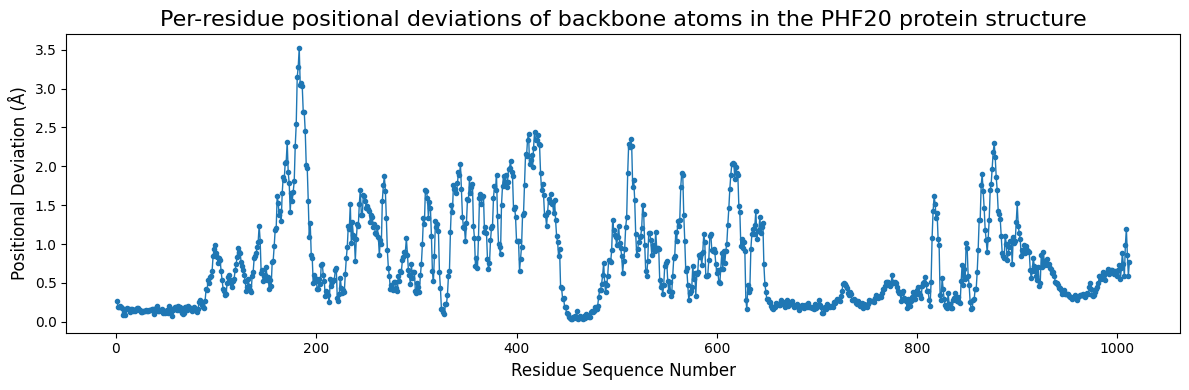

In [ ]:
import matplotlib.pyplot as plt

# X-axis: residue sequence numbers
# Y-axis: per-residue deviation (Å)
plt.figure(figsize=(12, 4))
plt.plot(ref_residue_numbers, per_residue_dist, marker='o', linestyle='-', linewidth=1, markersize=3)
plt.xlabel("Residue Sequence Number", fontsize=12)
plt.ylabel("Positional Deviation (Å)", fontsize=12)
plt.title("Per-residue positional deviations of backbone atoms in the PHF20 protein structure", fontsize=16)
#plt.grid(True)
plt.tight_layout()
plt.savefig("/content/drive/MyDrive/Protein_str/FineTuned_ESM2/plots/per_residue_backbone-deviations.png")
plt.show()


In [ ]:
import numpy as np

# Assuming per_residue_dist and total_residues are already defined:
# per_residue_dist = np.linalg.norm(pred_ca.xyz[0] - ref_ca.xyz[0], axis=1)
total_residues = len(per_residue_dist)

def calculate_tm_score(distances, L_target):
    """Approximate TM-score using standard TM-align equation."""
    d0 = 1.24 * ((L_target - 15) ** (1/3)) - 1.8
    score = np.sum(1 / (1 + (distances / d0)**2)) / L_target
    return score

def calculate_gdt_ts(distances):
    """Compute approximate GDT-TS as the average of fractions below 1, 2, 4, and 8 Å."""
    thresholds = [1.0, 2.0, 4.0, 8.0]
    scores = [np.sum(distances < t) / len(distances) for t in thresholds]
    return 100 * np.mean(scores)

# Calculate metrics
tm_score = calculate_tm_score(per_residue_dist, total_residues)
gdt_ts = calculate_gdt_ts(per_residue_dist)

# Display results
print(f"Estimated TM-score: {tm_score:.4f}")
print(f"Estimated GDT-TS: {gdt_ts:.2f}")


Estimated TM-score: 0.9917
Estimated GDT-TS: 91.60
